# Import Python Libraries

In [1]:
import glob
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from interpret.glassbox import ExplainableBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, roc_curve, average_precision_score, precision_recall_curve, auc)
from fancyimpute import IterativeImputer
from sklearn.impute import KNNImputer
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Carpeta de datos
path_train = "Data/Train"
path_test = "Data/Test"

# 1. Load Data

## 1.1. Checking ESP data 2019

In [3]:
# Load esp data 2019
data_pump_2019 = pd.read_csv(path_train + "/high_freq_2019.csv")
data_pump_2019

WELL_ID        DATE  CURRENT  PRESS_DESC  FREQUENCY  \
0      DEEPWATER-000XAR  2019-02-25    72.42     4252.87      57.44   
1      DEEPWATER-000XAR  2019-02-26    72.77     4203.62      57.44   
2      DEEPWATER-000XAR  2019-02-27    72.29     4271.55      57.45   
3      DEEPWATER-000XAR  2019-03-03    72.25     4235.13      57.44   
4      DEEPWATER-000XAR  2019-03-04    71.97     4216.12      57.44   
...                 ...         ...      ...         ...        ...   
19114  DEEPWATER-ZSZCSG  2019-11-07     0.00        0.00       0.00   
19115  DEEPWATER-ZSZCSG  2019-11-08     0.00        0.00       0.00   
19116  DEEPWATER-ZSZCSG  2019-11-09     0.00        0.00       0.00   
19117  DEEPWATER-ZSZCSG  2019-11-10     0.00        0.00       0.00   
19118  DEEPWATER-ZSZCSG  2019-11-11     0.00        0.00       0.00   

       PRESS_INT  TEMP_INT  TEMP_MOT  OUT_VOLT  VIBRATION  PRESS_INTK  \
0            NaN       NaN    281.56       0.0       0.17     1443.97   
1            NaN       NaN    281.09       0.0       0.15     1414.84   
2            NaN       NaN    281.55       0.0       0.15     1449.17   
3            NaN       NaN    280.89       0.0       0.17     1432.86   
4            NaN       NaN    280.57       0.0       0.16     1425.79   
...          ...       ...       ...       ...        ...         ...   
19114        NaN       NaN    223.24       0.0       0.11     4127.67   
19115        NaN       NaN    223.20       0.0       0.11     4127.75   
19116        NaN       NaN    223.11       0.0       0.15     4125.95   
19117        NaN       NaN    223.12       0.0       0.11     4126.17   
19118        NaN       NaN    222.84       0.0       0.13     4122.66   

       TEMP_INTK WellFailure  
0         222.71         NaN  
1         222.80         NaN  
2         222.72         NaN  
3         222.72         NaN  
4         222.77         NaN  
...          ...         ...  
19114     223.00         NaN  
19115     222.98         NaN  
19116     222.84         NaN  
19117     222.79         NaN  
19118     222.63         NaN  

[19119 rows x 13 columns]

In [4]:
data_pump_2019.isna().sum()

WELL_ID            0
DATE               0
CURRENT            0
PRESS_DESC         0
FREQUENCY          0
PRESS_INT      19119
TEMP_INT       19119
TEMP_MOT           0
OUT_VOLT           0
VIBRATION          0
PRESS_INTK         0
TEMP_INTK          0
WellFailure    19071
dtype: int64

In [5]:
# Drop columns PRESS_INT and TEMP_INT
data_pump_2019.drop(['PRESS_INT', 'TEMP_INT'], axis=1, inplace=True)
data_pump_2019

WELL_ID        DATE  CURRENT  PRESS_DESC  FREQUENCY  TEMP_MOT  \
0      DEEPWATER-000XAR  2019-02-25    72.42     4252.87      57.44    281.56   
1      DEEPWATER-000XAR  2019-02-26    72.77     4203.62      57.44    281.09   
2      DEEPWATER-000XAR  2019-02-27    72.29     4271.55      57.45    281.55   
3      DEEPWATER-000XAR  2019-03-03    72.25     4235.13      57.44    280.89   
4      DEEPWATER-000XAR  2019-03-04    71.97     4216.12      57.44    280.57   
...                 ...         ...      ...         ...        ...       ...   
19114  DEEPWATER-ZSZCSG  2019-11-07     0.00        0.00       0.00    223.24   
19115  DEEPWATER-ZSZCSG  2019-11-08     0.00        0.00       0.00    223.20   
19116  DEEPWATER-ZSZCSG  2019-11-09     0.00        0.00       0.00    223.11   
19117  DEEPWATER-ZSZCSG  2019-11-10     0.00        0.00       0.00    223.12   
19118  DEEPWATER-ZSZCSG  2019-11-11     0.00        0.00       0.00    222.84   

       OUT_VOLT  VIBRATION  PRESS_INTK  TEMP_INTK WellFailure  
0           0.0       0.17     1443.97     222.71         NaN  
1           0.0       0.15     1414.84     222.80         NaN  
2           0.0       0.15     1449.17     222.72         NaN  
3           0.0       0.17     1432.86     222.72         NaN  
4           0.0       0.16     1425.79     222.77         NaN  
...         ...        ...         ...        ...         ...  
19114       0.0       0.11     4127.67     223.00         NaN  
19115       0.0       0.11     4127.75     222.98         NaN  
19116       0.0       0.15     4125.95     222.84         NaN  
19117       0.0       0.11     4126.17     222.79         NaN  
19118       0.0       0.13     4122.66     222.63         NaN  

[19119 rows x 11 columns]

## 1.2. Load production data

In [6]:
prod_train= pd.read_csv(path_train + "/production_train.csv", parse_dates=[1])
prod_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14508 entries, 0 to 14507
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   WELL_ID         14508 non-null  object 
 1   DATE            14508 non-null  object 
 2   BFPD            14503 non-null  float64
 3   BOPD            14462 non-null  float64
 4   BWPD            14504 non-null  float64
 5   MSCF            14484 non-null  float64
 6   BSW             14504 non-null  float64
 7   GOR(MSFC/BPPD)  14508 non-null  float64
 8   GLR(SCF/BFPD)   14508 non-null  float64
 9   API             14359 non-null  float64
 10  FREC(Hz)        9832 non-null   float64
 11  PIP(PSI)        9171 non-null   float64
 12  PROF_INTAKE     10200 non-null  float64
 13  AMPERAGE        11305 non-null  float64
 14  PUMP            14508 non-null  object 
 15  PSI_CAB         14308 non-null  float64
dtypes: float64(13), object(3)
memory usage: 1.8+ MB


In [7]:
len(prod_train.WELL_ID.unique())

99

## 1.3. Checking ESP data January 2020

In [8]:
data_jan = pd.read_csv(path_train + "/2020_01_JAN.csv")
data_jan.head()

WELL_ID                 DATE    CURRENT  PRESS_DESC  FREQUENCY  \
0  DEEPWATER-VVBMZ0  2020-01-01 00:00:00   4.480000   2659.0600       0.55   
1  DEEPWATER-VKCG0Y  2020-01-01 08:00:31  24.799999   4172.1997      54.00   
2  DEEPWATER-HOQZS1  2020-01-01 08:01:14  39.200001   4008.9998      59.00   
3  DEEPWATER-IXZFOT  2020-01-01 08:01:54  20.900000   3996.2000     133.00   
4  DEEPWATER-3PEB5I  2020-01-01 08:02:22        NaN   3742.3000        NaN   

   PRESS_INT   TEMP_INT   TEMP_MOT   OUT_VOLT  VIBRATION  PRESS_INTK  \
0        NaN        NaN  105.57000    0.00000   2.550000      1966.8   
1  460.50000  235.39999  279.09998  425.10001   0.200136         NaN   
2  354.20001  223.50000  280.19998  459.89999        NaN         NaN   
3  518.39996  243.50000  319.10001  304.00000        NaN         NaN   
4        NaN  232.20000  276.39999        NaN        NaN         NaN   

   TEMP_INTK WellFailure  
0      80.64         yes  
1        NaN         NaN  
2        NaN         NaN  
3        NaN         NaN  
4        NaN         NaN

In [9]:
data_jan.isna().sum()

WELL_ID             0
DATE                0
CURRENT         58352
PRESS_DESC      11763
FREQUENCY       38613
PRESS_INT       14762
TEMP_INT        21629
TEMP_MOT        12167
OUT_VOLT       100719
VIBRATION       53354
PRESS_INTK     173075
TEMP_INTK      173075
WellFailure    173065
dtype: int64

## 1.4. Load Train and Test ESP data 2019-2021

In [10]:
## Directory train files
files_train = glob.glob(path_train + "/*.csv")
files_train[:-1]

['Data/Train\\2020_01_JAN.csv',
 'Data/Train\\2020_02_FEB.csv',
 'Data/Train\\2020_03_MAR.csv',
 'Data/Train\\2020_04_APR.csv',
 'Data/Train\\2020_05_MAY.csv',
 'Data/Train\\2020_06_JUN.csv',
 'Data/Train\\2020_07_JUL.csv',
 'Data/Train\\2020_08_AUG.csv',
 'Data/Train\\2020_09_SEP.csv',
 'Data/Train\\2020_10_OCT.csv',
 'Data/Train\\2020_11_NOV.csv',
 'Data/Train\\2020_12_DEC.csv',
 'Data/Train\\2021_01_JAN.csv',
 'Data/Train\\2021_02_FEB.csv',
 'Data/Train\\2021_03_MAR.csv',
 'Data/Train\\2021_04_APR.csv',
 'Data/Train\\2021_05_MAY.csv',
 'Data/Train\\high_freq_2019.csv']

In [11]:
# Directory test files
files_test = glob.glob(path_test + "/*.csv")
files_test[:-1]

['Data/Test\\2020_01_JAN.csv',
 'Data/Test\\2020_02_FEB.csv',
 'Data/Test\\2020_03_MAR.csv',
 'Data/Test\\2020_04_APR.csv',
 'Data/Test\\2020_05_MAY.csv',
 'Data/Test\\2020_06_JUN.csv',
 'Data/Test\\2020_07_JUL.csv',
 'Data/Test\\2020_08_AUG.csv',
 'Data/Test\\2020_09_SEP.csv',
 'Data/Test\\2020_10_OCT.csv',
 'Data/Test\\2020_11_NOV.csv',
 'Data/Test\\2020_12_DEC.csv',
 'Data/Test\\2021_01_JAN.csv',
 'Data/Test\\2021_02_FEB.csv',
 'Data/Test\\2021_03_MAR.csv',
 'Data/Test\\2021_04_APR.csv',
 'Data/Test\\2021_05_MAY.csv',
 'Data/Test\\high_freq_2019.csv']

In [12]:
# Merge Frequency Files
def concat_data(files):
    
    dataframes = [pd.read_csv(file, parse_dates=[1]) for file in files]
    return pd.concat(dataframes,axis=0).reset_index(drop=True)

In [13]:
# Concat High Frequency Data
train_esp = concat_data(files_train[:-1])
test_esp = concat_data(files_test[:-1])

In [14]:
train_esp

WELL_ID                DATE    CURRENT  PRESS_DESC  \
0        DEEPWATER-VVBMZ0 2020-01-01 00:00:00   4.480000   2659.0600   
1        DEEPWATER-VKCG0Y 2020-01-01 08:00:31  24.799999   4172.1997   
2        DEEPWATER-HOQZS1 2020-01-01 08:01:14  39.200001   4008.9998   
3        DEEPWATER-IXZFOT 2020-01-01 08:01:54  20.900000   3996.2000   
4        DEEPWATER-3PEB5I 2020-01-01 08:02:22        NaN   3742.3000   
...                   ...                 ...        ...         ...   
7866952  DEEPWATER-ZSZCSG 2019-11-07 00:00:00   0.000000      0.0000   
7866953  DEEPWATER-ZSZCSG 2019-11-08 00:00:00   0.000000      0.0000   
7866954  DEEPWATER-ZSZCSG 2019-11-09 00:00:00   0.000000      0.0000   
7866955  DEEPWATER-ZSZCSG 2019-11-10 00:00:00   0.000000      0.0000   
7866956  DEEPWATER-ZSZCSG 2019-11-11 00:00:00   0.000000      0.0000   

         FREQUENCY  PRESS_INT   TEMP_INT   TEMP_MOT   OUT_VOLT  VIBRATION  \
0             0.55        NaN        NaN  105.57000    0.00000   2.550000   
1            54.00  460.50000  235.39999  279.09998  425.10001   0.200136   
2            59.00  354.20001  223.50000  280.19998  459.89999        NaN   
3           133.00  518.39996  243.50000  319.10001  304.00000        NaN   
4              NaN        NaN  232.20000  276.39999        NaN        NaN   
...            ...        ...        ...        ...        ...        ...   
7866952       0.00        NaN        NaN  223.24000    0.00000   0.110000   
7866953       0.00        NaN        NaN  223.20000    0.00000   0.110000   
7866954       0.00        NaN        NaN  223.11000    0.00000   0.150000   
7866955       0.00        NaN        NaN  223.12000    0.00000   0.110000   
7866956       0.00        NaN        NaN  222.84000    0.00000   0.130000   

         PRESS_INTK  TEMP_INTK WellFailure  
0           1966.80      80.64         yes  
1               NaN        NaN         NaN  
2               NaN        NaN         NaN  
3               NaN        NaN         NaN  
4               NaN        NaN         NaN  
...             ...        ...         ...  
7866952     4127.67     223.00         NaN  
7866953     4127.75     222.98         NaN  
7866954     4125.95     222.84         NaN  
7866955     4126.17     222.79         NaN  
7866956     4122.66     222.63         NaN  

[7866957 rows x 13 columns]

In [15]:
# Make a copy of pump data
esp_train = train_esp.copy()

In [16]:
# Merge both columns: PRESS_INT and PRESS_INTK - TEMP_INT and TEMP_INTK
esp_train['PRESS_INT'] = esp_train['PRESS_INT'].fillna(esp_train['PRESS_INTK'])
esp_train['TEMP_INT'] = esp_train['TEMP_INT'].fillna(esp_train['TEMP_INTK'])

In [17]:
esp_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7866957 entries, 0 to 7866956
Data columns (total 13 columns):
 #   Column       Dtype         
---  ------       -----         
 0   WELL_ID      object        
 1   DATE         datetime64[ns]
 2   CURRENT      float64       
 3   PRESS_DESC   float64       
 4   FREQUENCY    float64       
 5   PRESS_INT    float64       
 6   TEMP_INT     float64       
 7   TEMP_MOT     float64       
 8   OUT_VOLT     float64       
 9   VIBRATION    float64       
 10  PRESS_INTK   float64       
 11  TEMP_INTK    float64       
 12  WellFailure  object        
dtypes: datetime64[ns](1), float64(10), object(2)
memory usage: 780.3+ MB


In [18]:
# Count null values
esp_train.isna().sum()

WELL_ID              0
DATE                 0
CURRENT         496585
PRESS_DESC      533143
FREQUENCY       313068
PRESS_INT       256490
TEMP_INT        386948
TEMP_MOT        291044
OUT_VOLT       7512093
VIBRATION       581164
PRESS_INTK     7847837
TEMP_INTK      7847837
WellFailure    7866846
dtype: int64

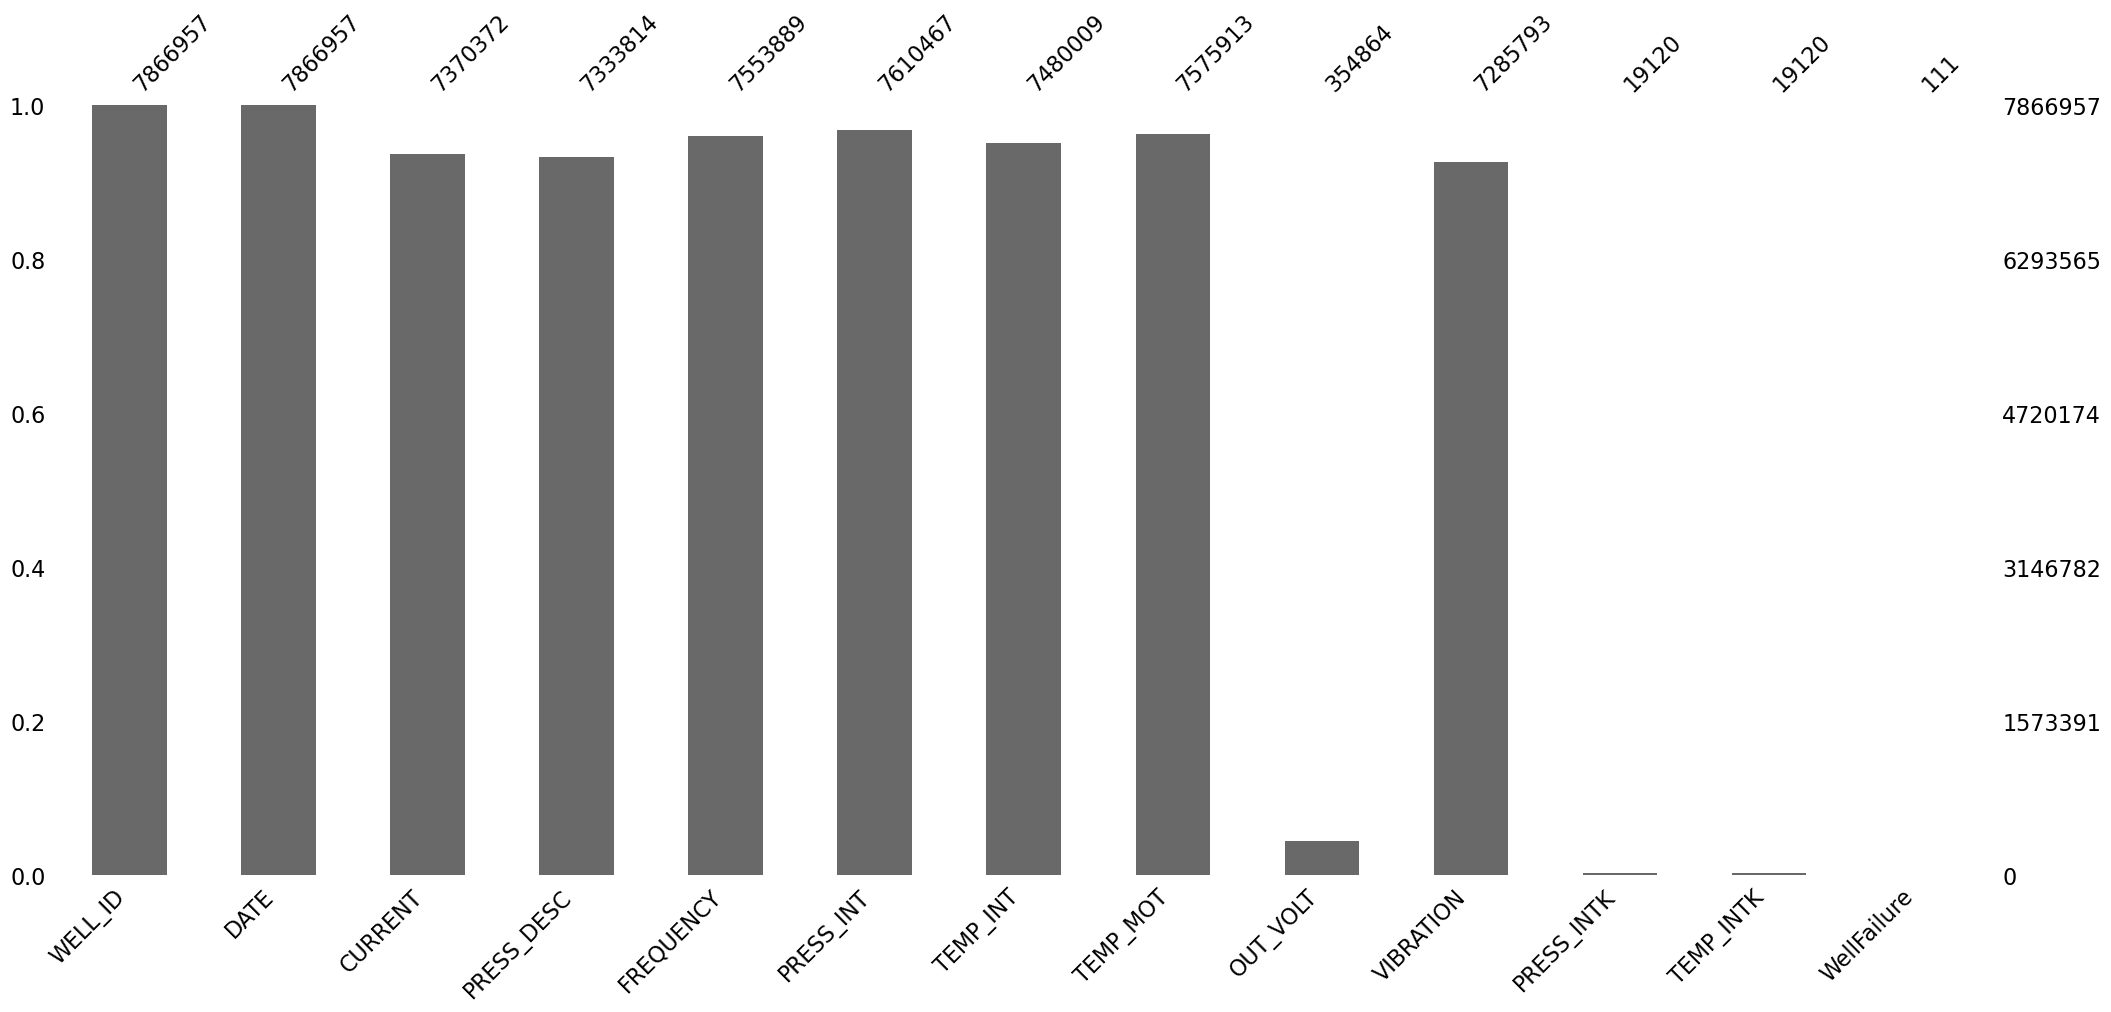

In [19]:
# Visualizing null values
msno.bar(esp_train)
plt.show()

In [20]:
# Drop PRESS_INTK and TEMP_INTK columns
esp_train.drop(['PRESS_INTK', 'TEMP_INTK'], axis=1, inplace=True)

In [21]:
# Checking number of wells
len(esp_train['WELL_ID'].unique())

100

---

In [22]:
# Make a copy of the test data
esp_test = test_esp.copy()

In [23]:
# Merge both columns: PRESS_INT and PRESS_INTK - TEMP_INT and TEMP_INTK
esp_test['PRESS_INT'] = esp_test['PRESS_INT'].fillna(esp_test['PRESS_INTK'])
esp_test['TEMP_INT'] = esp_test['TEMP_INT'].fillna(esp_test['TEMP_INTK'])

In [24]:
esp_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143020 entries, 0 to 1143019
Data columns (total 13 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   WELL_ID      1143020 non-null  object        
 1   DATE         1143020 non-null  datetime64[ns]
 2   CURRENT      1081076 non-null  float64       
 3   PRESS_DESC   988449 non-null   float64       
 4   FREQUENCY    1108460 non-null  float64       
 5   PRESS_INT    1075544 non-null  float64       
 6   TEMP_INT     1059757 non-null  float64       
 7   TEMP_MOT     1076759 non-null  float64       
 8   OUT_VOLT     45406 non-null    float64       
 9   VIBRATION    1018841 non-null  float64       
 10  PRESS_INTK   3628 non-null     float64       
 11  TEMP_INTK    3628 non-null     float64       
 12  WellFailure  0 non-null        float64       
dtypes: datetime64[ns](1), float64(11), object(1)
memory usage: 113.4+ MB


In [25]:
# Counting null values
esp_test.isna().sum()

WELL_ID              0
DATE                 0
CURRENT          61944
PRESS_DESC      154571
FREQUENCY        34560
PRESS_INT        67476
TEMP_INT         83263
TEMP_MOT         66261
OUT_VOLT       1097614
VIBRATION       124179
PRESS_INTK     1139392
TEMP_INTK      1139392
WellFailure    1143020
dtype: int64

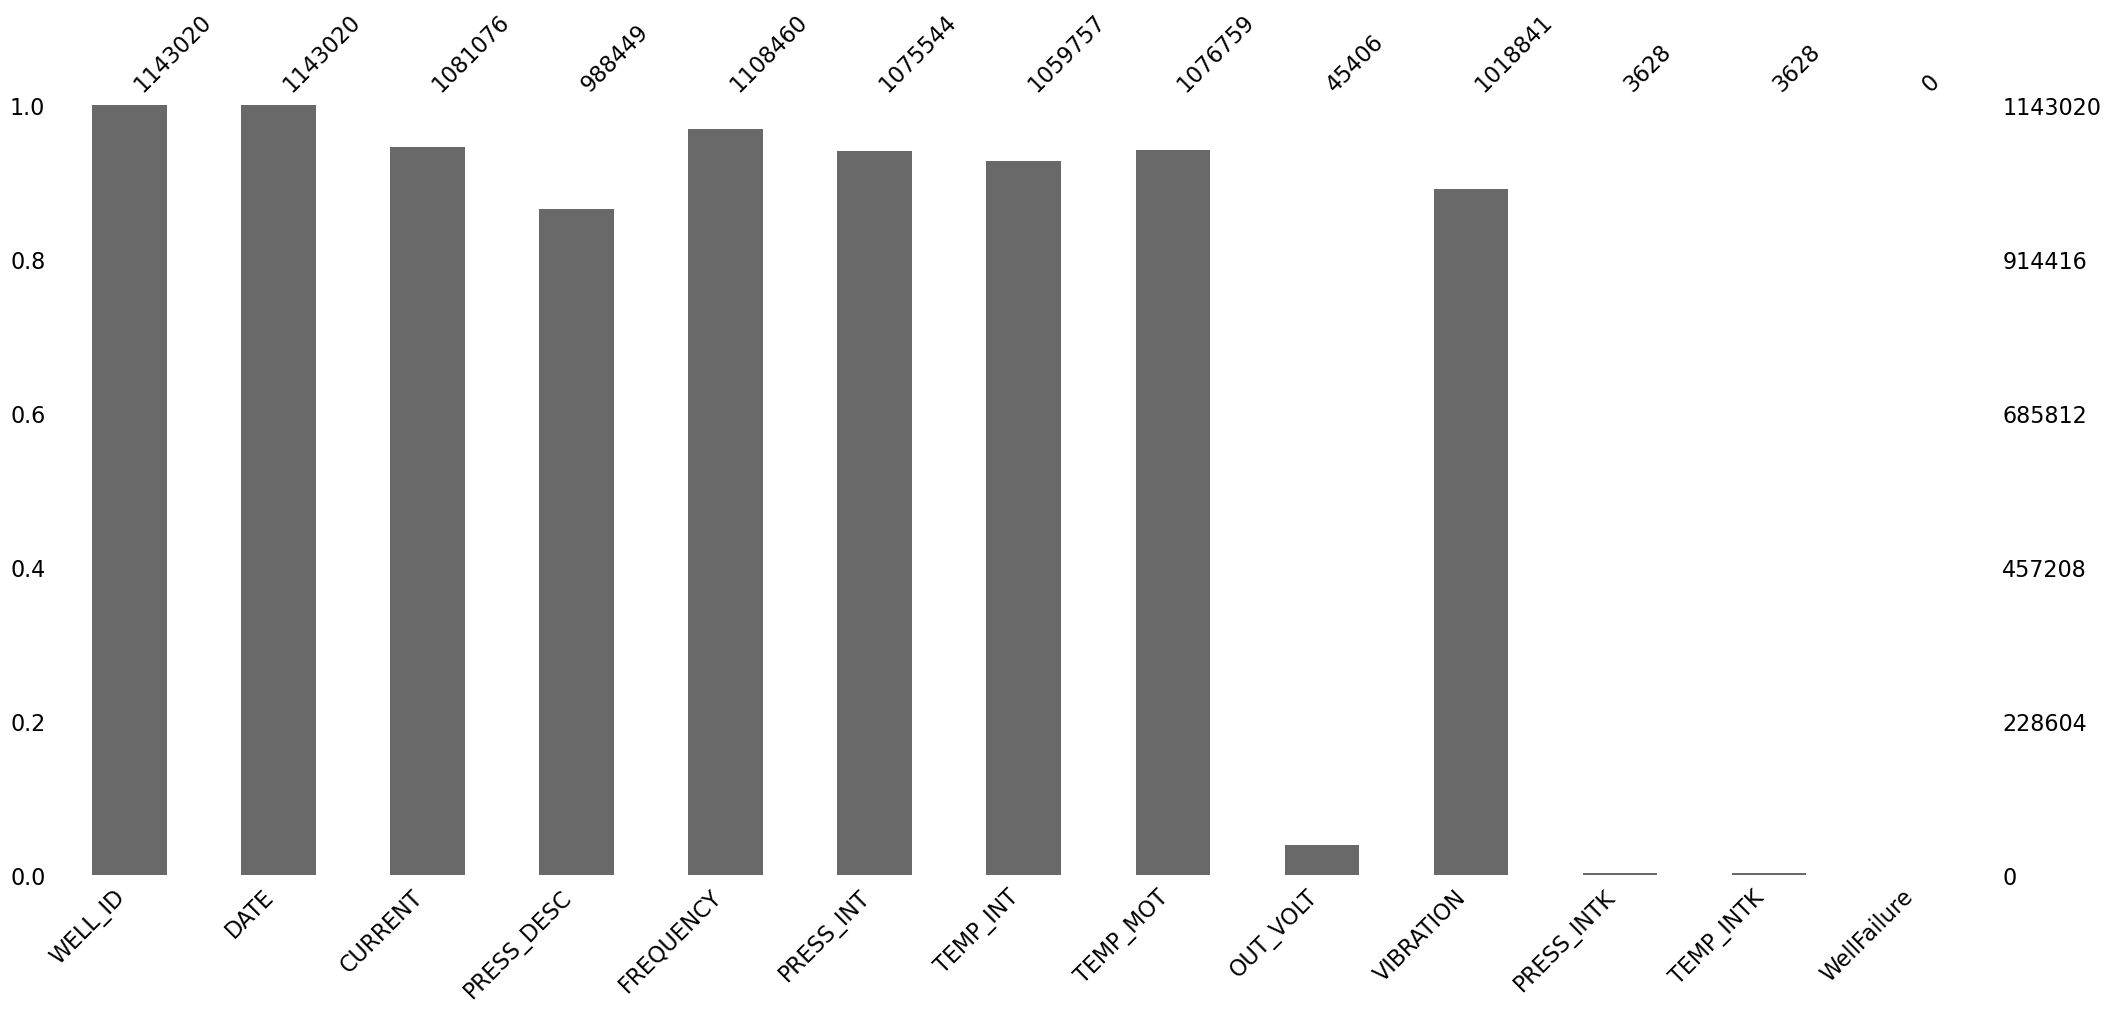

In [26]:
# Visualizing null values in the test set
msno.bar(esp_test)
plt.show()

---

In [27]:
# Drop columns PRESS_INTK and TEMP_INTK
esp_test.drop(['PRESS_INTK', 'TEMP_INTK'], axis=1, inplace=True)

In [28]:
# Checking number of wells
len(esp_test['WELL_ID'].unique())

15

## 1.5. Load Well Locations Data

In [29]:
well_locations = pd.read_csv("Data/well_locations.csv")
well_locations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115 entries, 0 to 114
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   WELL_ID  115 non-null    object 
 1   lat      115 non-null    float64
 2   lon      115 non-null    float64
dtypes: float64(2), object(1)
memory usage: 2.8+ KB


In [30]:
# Plotting well locations
fig = px.scatter(well_locations, x='lon', y='lat', hover_data=['WELL_ID'], title='Well locations')
fig.update_layout(
    width = 1200,
    height = 400,
    title = "Well Locations")

fig.show()

# 2. Exploratory data analysis

## 2.1. Boxplots ESP train data

In [31]:
# ESP data
esp_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7866957 entries, 0 to 7866956
Data columns (total 11 columns):
 #   Column       Dtype         
---  ------       -----         
 0   WELL_ID      object        
 1   DATE         datetime64[ns]
 2   CURRENT      float64       
 3   PRESS_DESC   float64       
 4   FREQUENCY    float64       
 5   PRESS_INT    float64       
 6   TEMP_INT     float64       
 7   TEMP_MOT     float64       
 8   OUT_VOLT     float64       
 9   VIBRATION    float64       
 10  WellFailure  object        
dtypes: datetime64[ns](1), float64(8), object(2)
memory usage: 660.2+ MB


In [32]:
esp_train.describe().T

count                           mean                  min  \
DATE          7866957  2020-10-17 14:12:43.863721984  2019-02-25 00:00:00   
CURRENT     7370372.0                      36.429865                  0.0   
PRESS_DESC  7333814.0                    3587.021914              -3276.0   
FREQUENCY   7553889.0                       57.09056                  0.0   
PRESS_INT   7610467.0                    1233.715153                  0.0   
TEMP_INT    7480009.0                     295.235469              -3180.4   
TEMP_MOT    7575913.0                     275.791108               -17.78   
OUT_VOLT     354864.0                     336.477454                  0.0   
VIBRATION   7285793.0                     261.849375                  0.0   

                            25%                  50%                  75%  \
DATE        2020-08-11 12:31:00  2020-10-14 19:02:00  2021-01-03 05:03:35   
CURRENT                    22.0                 33.0                 54.0   
PRESS_DESC               3650.0               3952.3               4123.0   
FREQUENCY                  53.0                 56.0                 60.0   
PRESS_INT                 259.0                362.0                722.0   
TEMP_INT                  226.0                230.0                235.0   
TEMP_MOT                  267.0            283.59998                296.0   
OUT_VOLT              378.20001            433.89999            458.60001   
VIBRATION                   0.0                  0.0                  0.0   

                            max          std  
DATE        2021-05-25 09:28:53          NaN  
CURRENT                 51970.0    29.104395  
PRESS_DESC              94906.9  2130.708516  
FREQUENCY                5051.0    26.831815  
PRESS_INT            189813.796  7865.707366  
TEMP_INT                11827.0   917.426733  
TEMP_MOT                 6553.5   146.389727  
OUT_VOLT                  953.0   186.673191  
VIBRATION               65535.0  4127.618675

In [33]:
# Counting null values
esp_train.isna().sum()

WELL_ID              0
DATE                 0
CURRENT         496585
PRESS_DESC      533143
FREQUENCY       313068
PRESS_INT       256490
TEMP_INT        386948
TEMP_MOT        291044
OUT_VOLT       7512093
VIBRATION       581164
WellFailure    7866846
dtype: int64

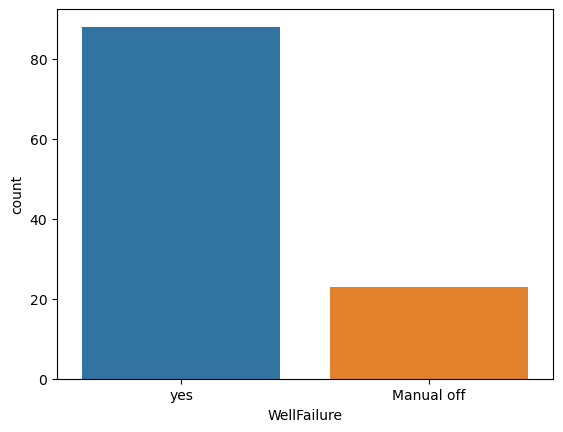

In [34]:
# Checking ESP Failures
sns.countplot(data=esp_train, x='WellFailure')
plt.show()

In [35]:
# Create function to make a boxplot
def box_plot(df, x, y, ylabel=None, ylim=None):
    fig, ax = plt.subplots(figsize=(16, 8))
    fig = sns.boxplot(data=df, x=x, y=y)
    
    # Set y-axis limits if provided
    if ylim:
        ax.set_ylim(0, ylim)
    
    plt.xticks(rotation=90)
    ax.set_ylabel(ylabel)
    plt.show()

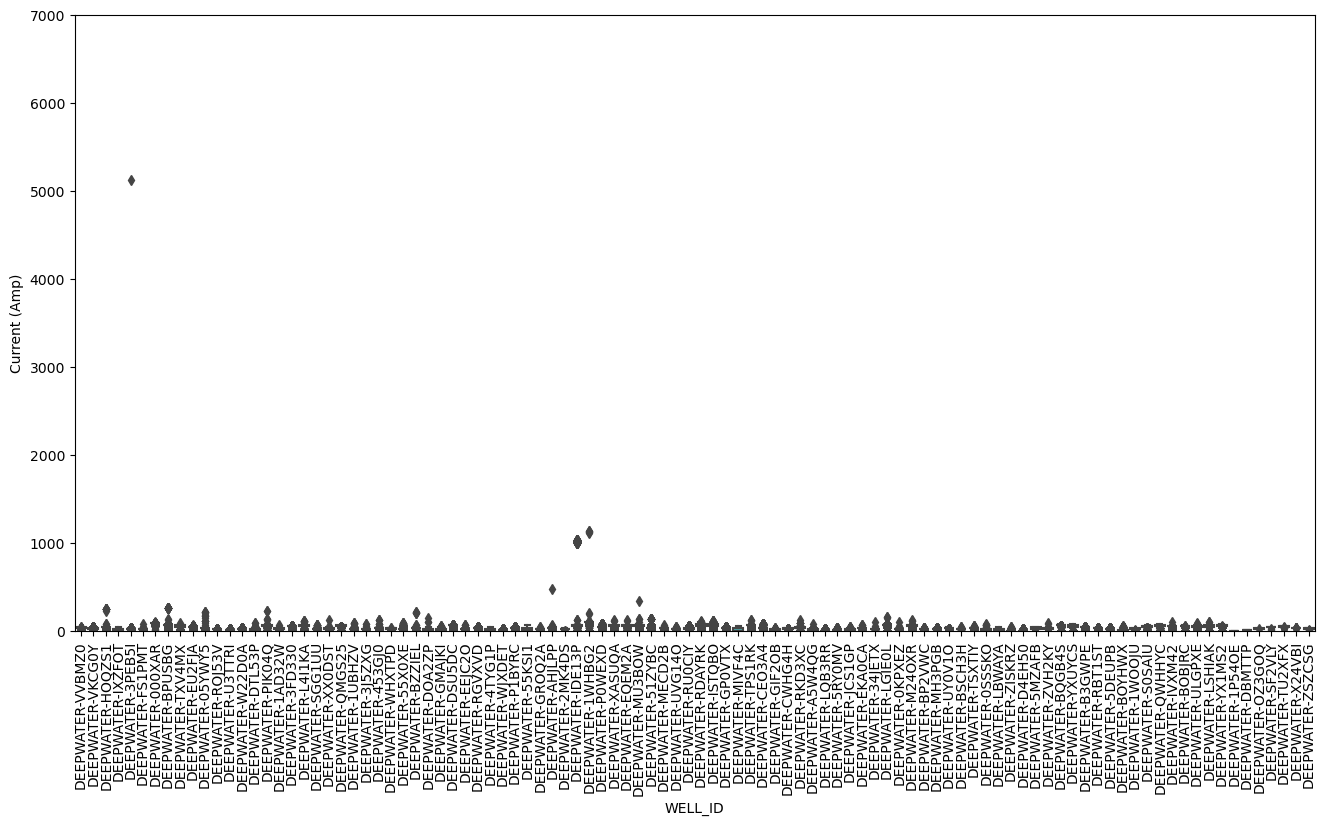

In [36]:
# Current variable 
box_plot(esp_train, 'WELL_ID', 'CURRENT', "Current (Amp)", 7000)
# considerar valores de corriente entre 0 y 100
#--'DEEPWATER-1WHBG2', 'DEEPWATER-HOQZS1', 'DEEPWATER-BPUSBG',
#'DEEPWATER-BZZIEL', --'DEEPWATER-MU3BOW', 'DEEPWATER-PIK04Q',
#--'DEEPWATER-IDE13P', 'DEEPWATER-LGIE0L', --'DEEPWATER-AHJLPP',
#'DEEPWATER-EQEM2A', --'DEEPWATER-3PEB5I', 'DEEPWATER-05YWY5'

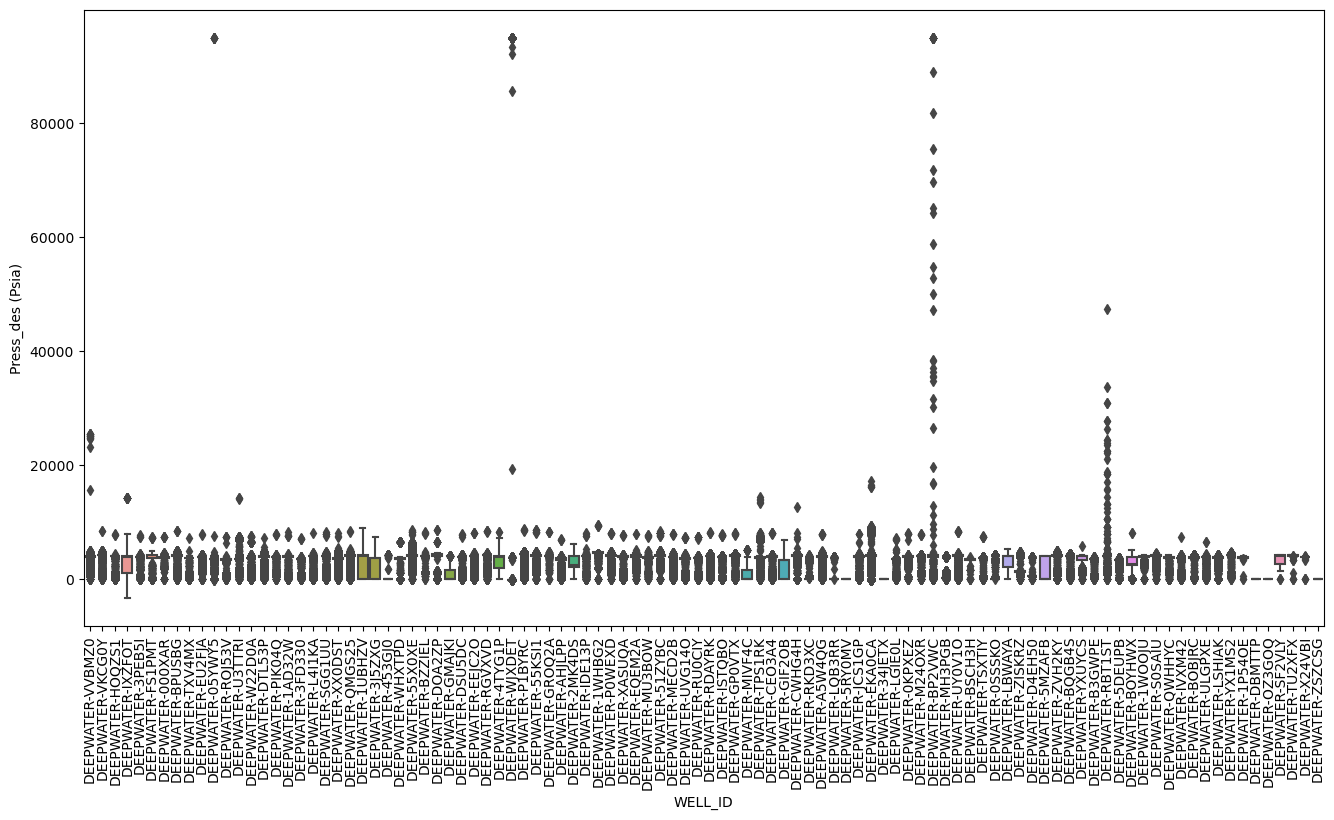

In [37]:
# Boxplot: Descharge pressure variable
box_plot(esp_train, 'WELL_ID', 'PRESS_DESC', "Press_des (Psia)")
#considerar valores hasta 4500


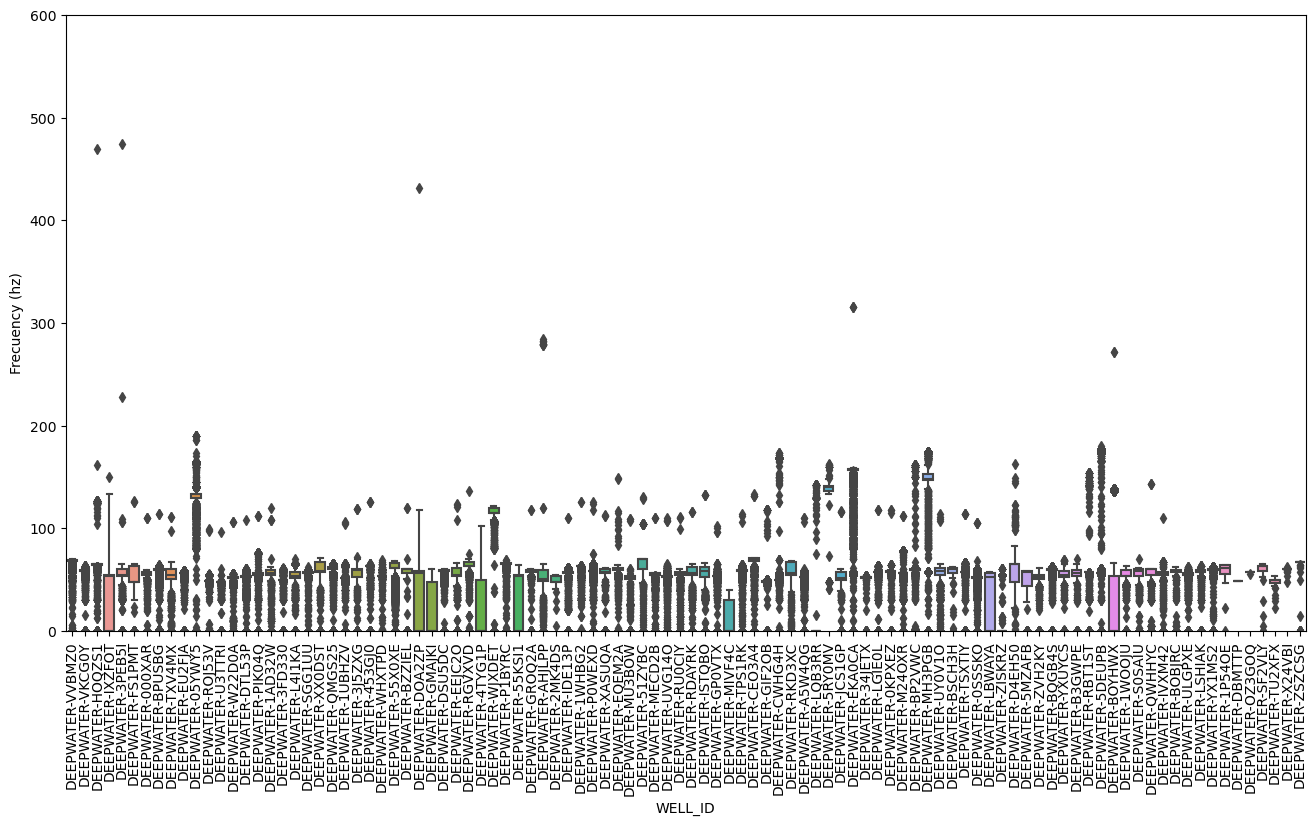

In [38]:
# Boxplot: frequency variable
box_plot(esp_train, 'WELL_ID', 'FREQUENCY', "Frecuency (hz)", 600) 
# considerar valores de frecuencia hasta 65 hz

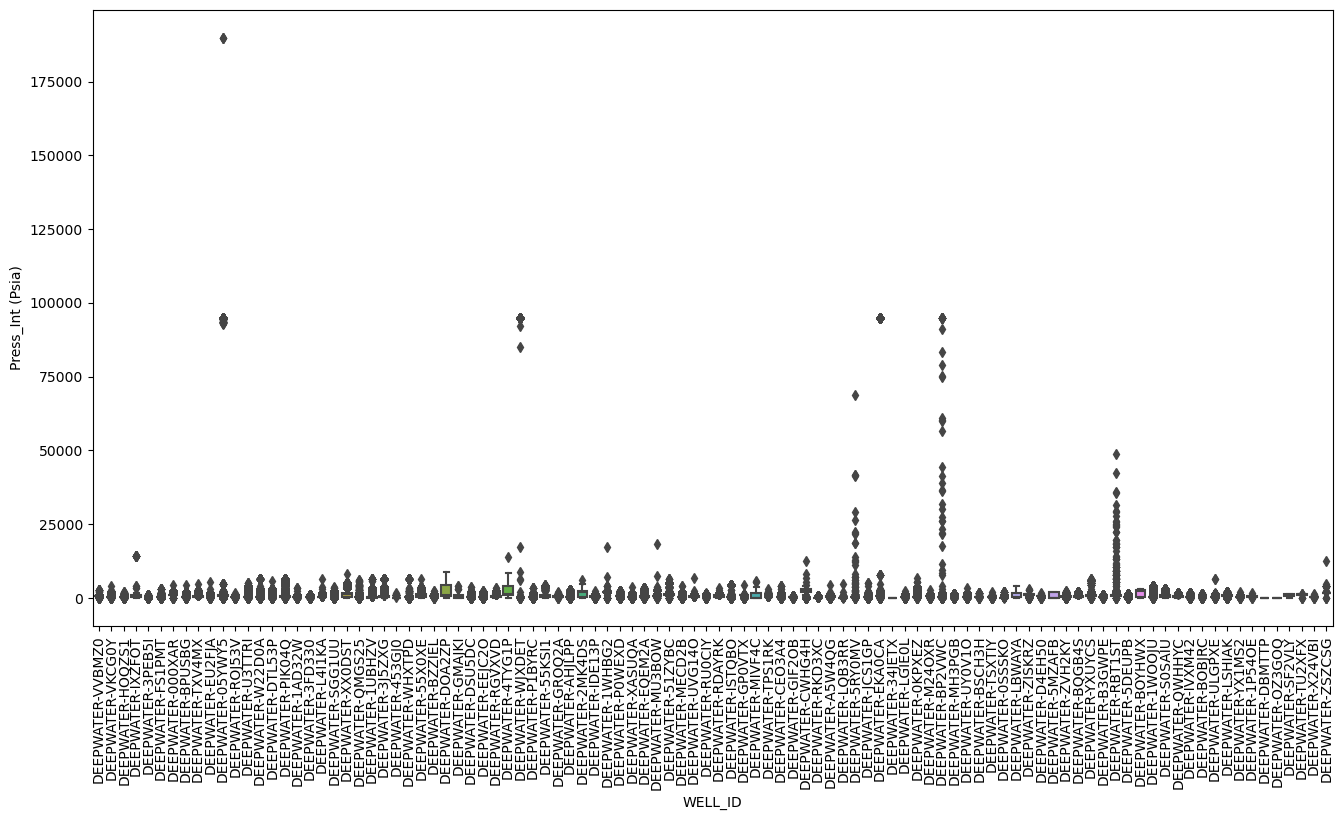

In [39]:
# Boxplot: intake pressure
box_plot(esp_train, 'WELL_ID', 'PRESS_INT', "Press_Int (Psia)")
# valores hasta 4500

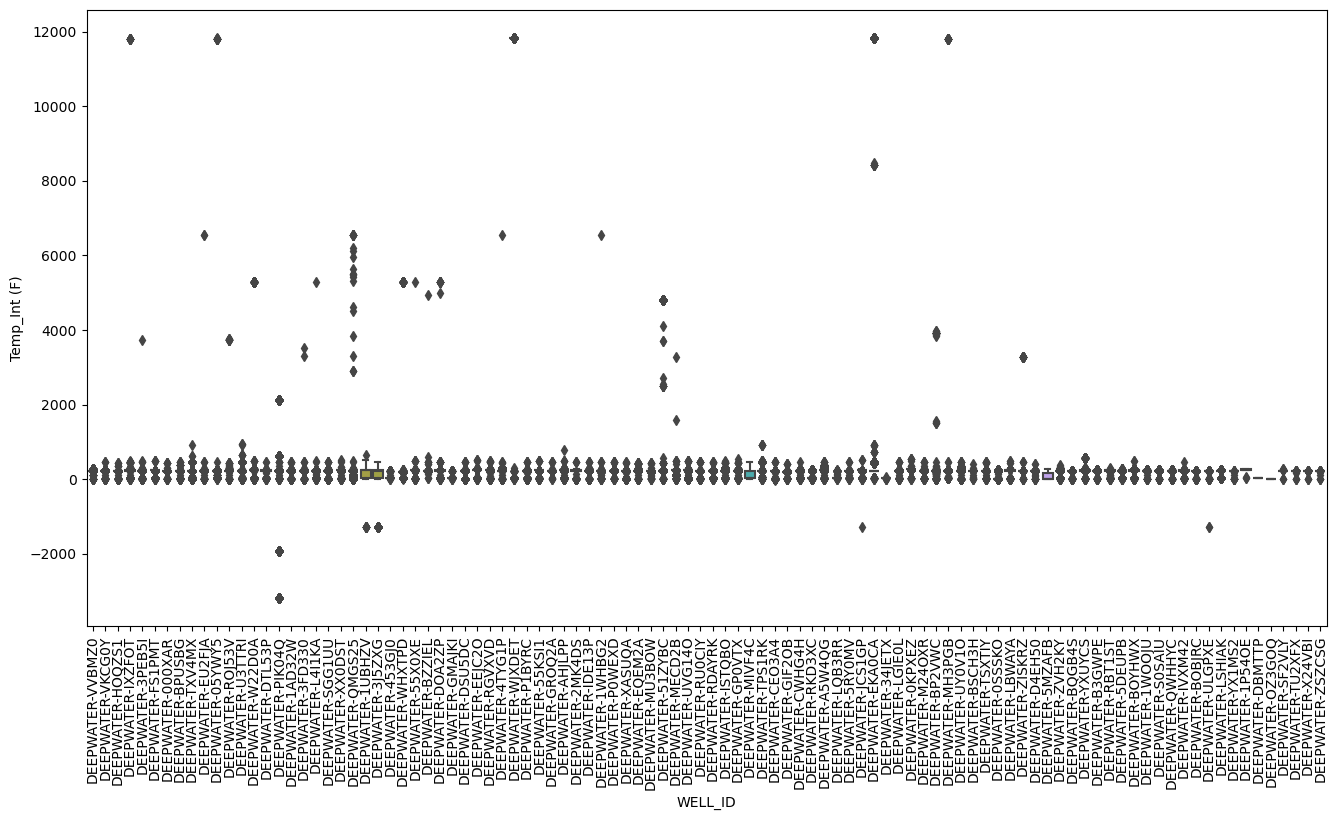

In [40]:
# Boxplot: intake temperature
box_plot(esp_train, 'WELL_ID', 'TEMP_INT', "Temp_Int (F)")
# valores de temperatura hasta 300

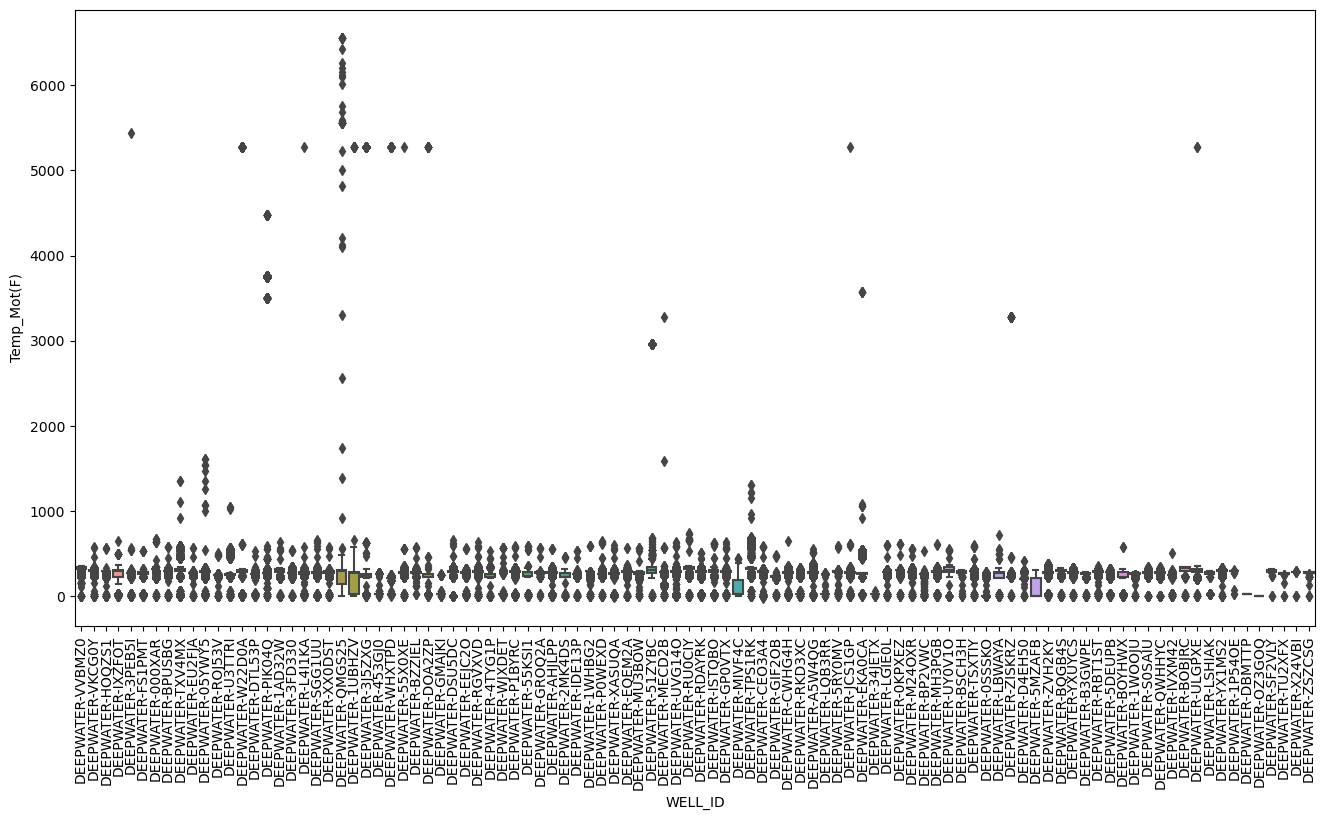

In [41]:
# Boxplot: motor temperature
box_plot(esp_train, 'WELL_ID', 'TEMP_MOT', "Temp_Mot(F)")
# valores hasta 350

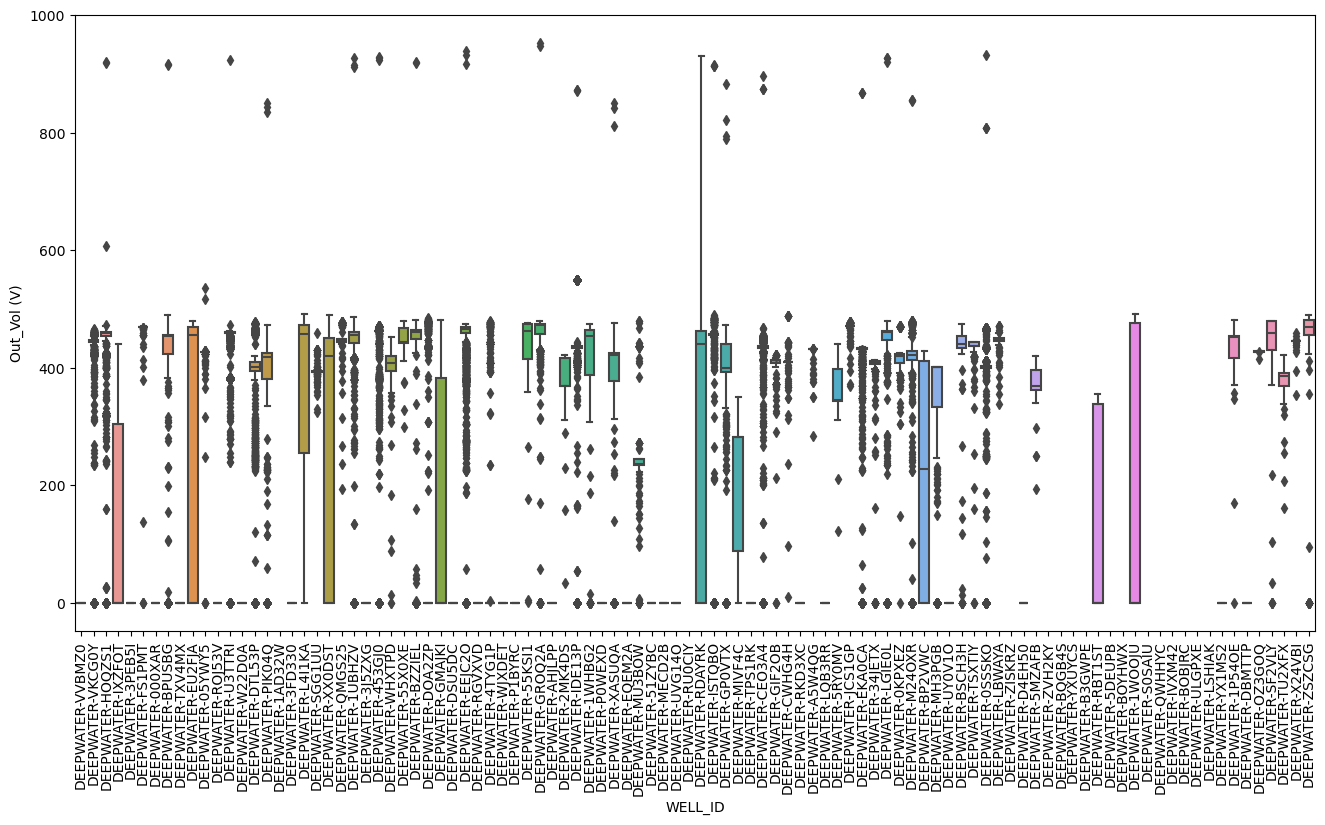

In [42]:
# Boxplot: motor temperature
box_plot(esp_train, 'WELL_ID', 'OUT_VOLT', "Out_Vol (V)")
# podria considerarse hasta 480

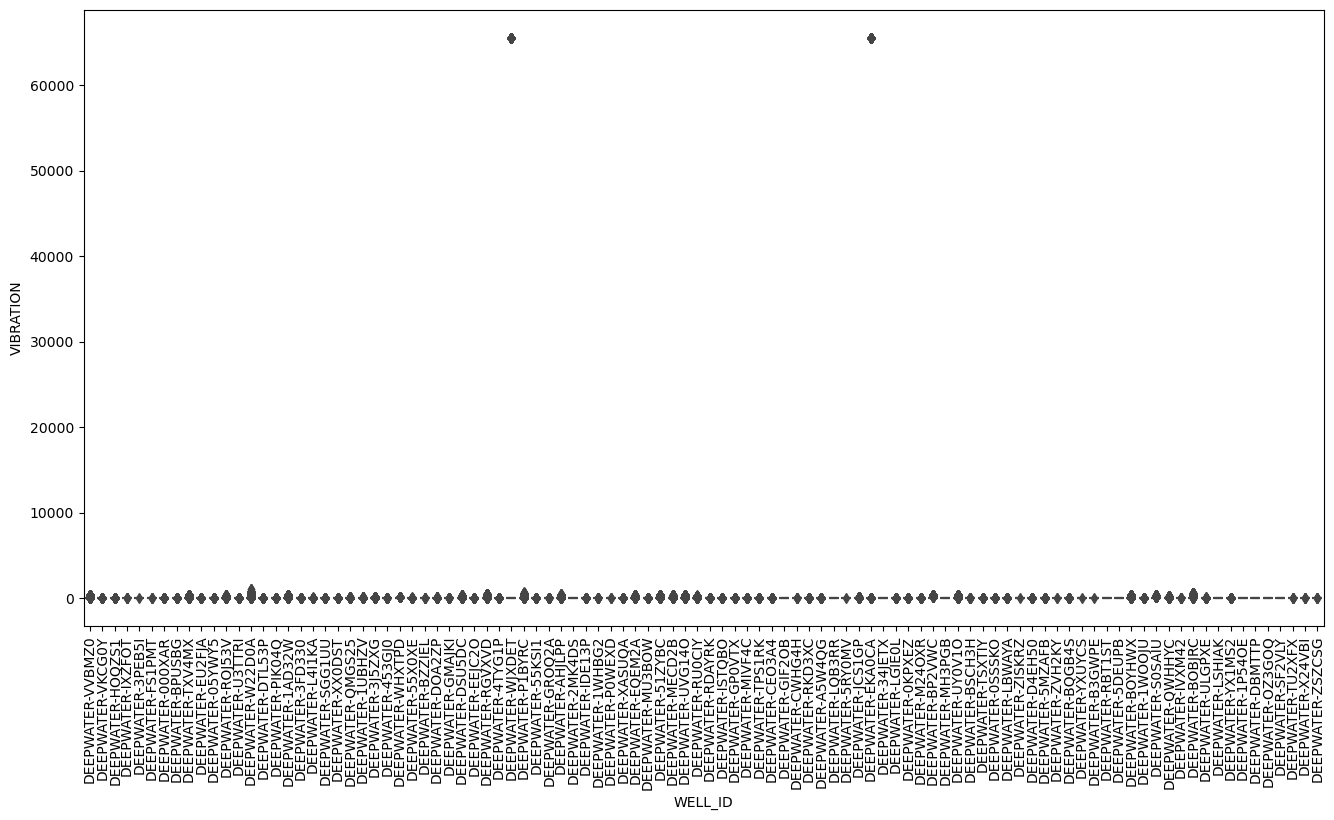

In [43]:
# Boxplot: motor temperature
box_plot(esp_train, 'WELL_ID', 'VIBRATION', "VIBRATION")
# considerar hasta 5

## 2.2. Boxplots ESP test data

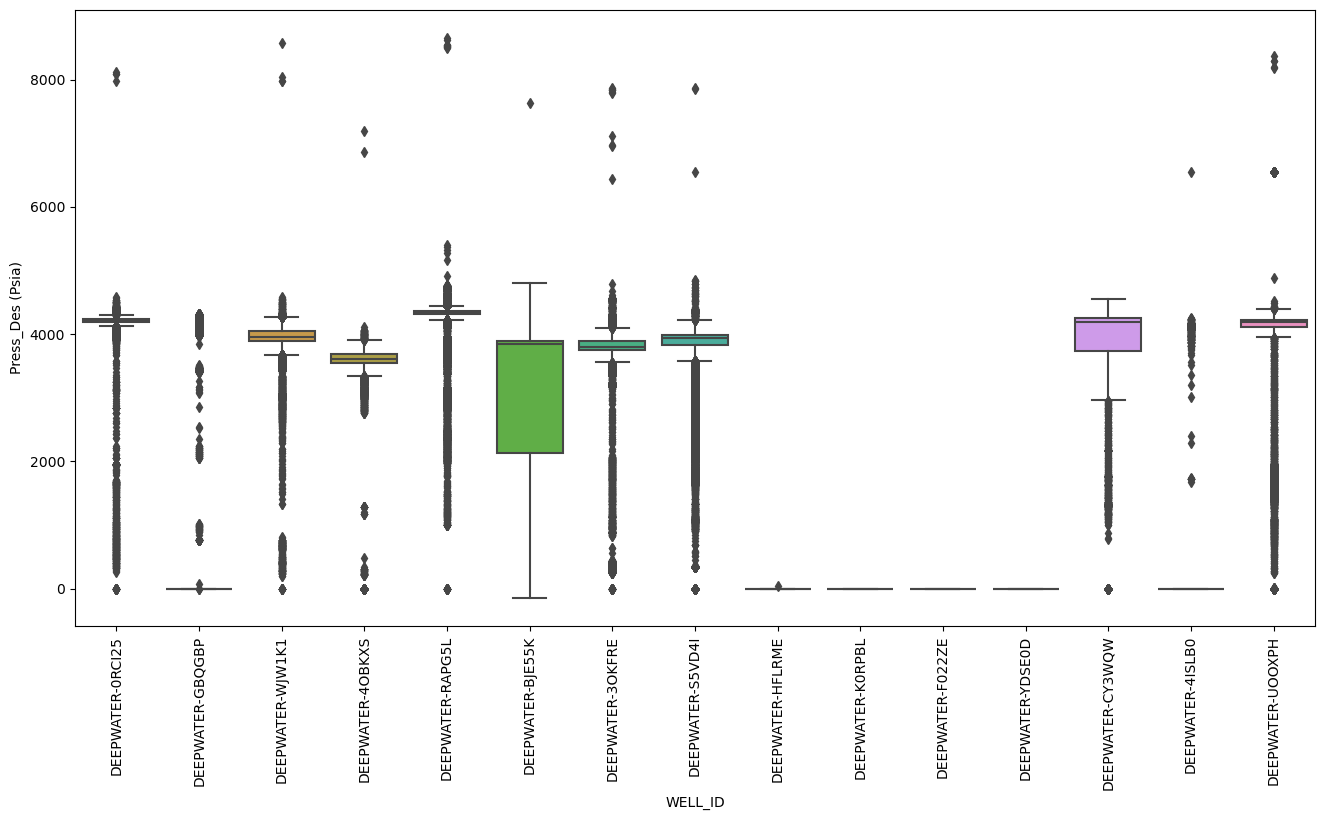

In [44]:
# Current variable 
box_plot(esp_test, 'WELL_ID', 'PRESS_DESC', "Press_Des (Psia)")

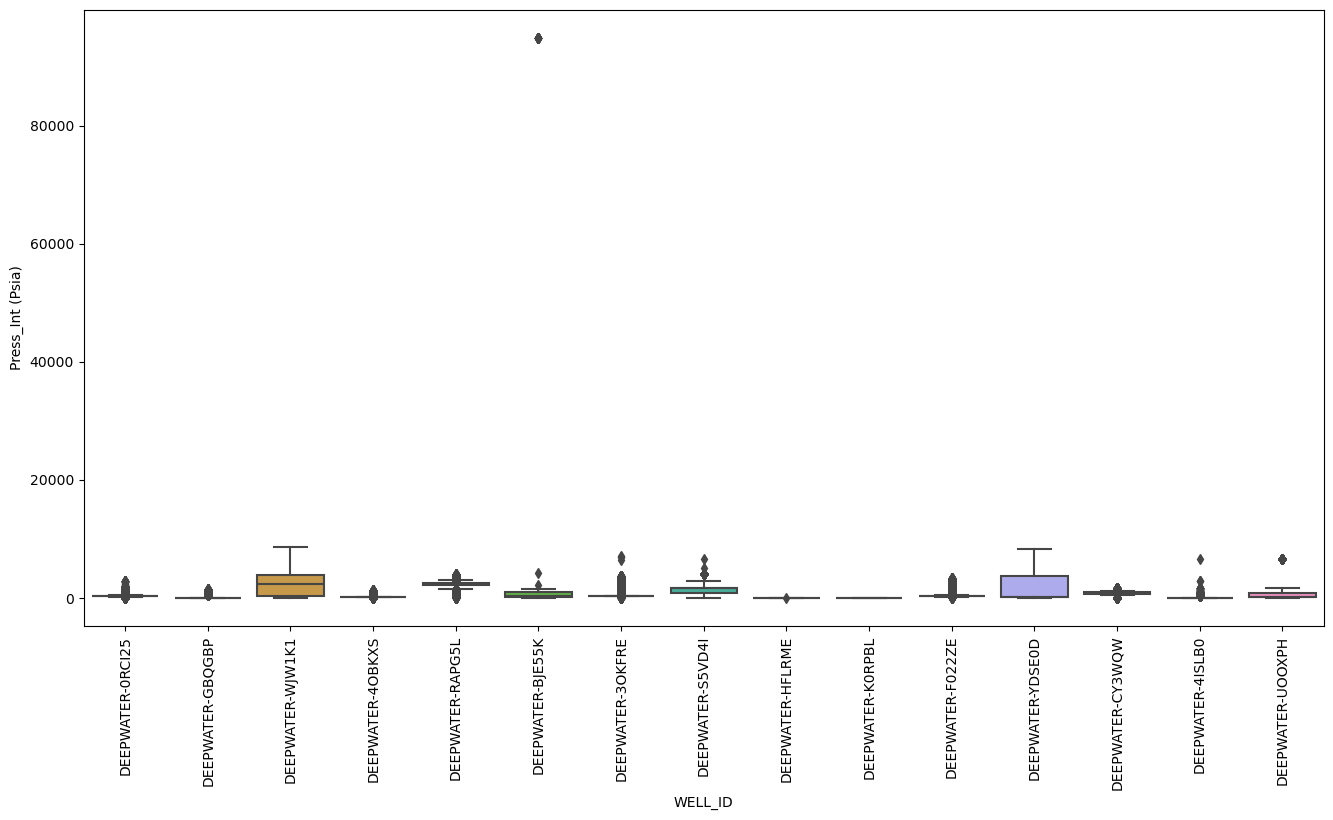

In [45]:
# Current variable 
box_plot(esp_test, 'WELL_ID', 'PRESS_INT', "Press_Int (Psia)")

## 2.3. Boxplots production data

In [46]:
# Production data
prod_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14508 entries, 0 to 14507
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   WELL_ID         14508 non-null  object 
 1   DATE            14508 non-null  object 
 2   BFPD            14503 non-null  float64
 3   BOPD            14462 non-null  float64
 4   BWPD            14504 non-null  float64
 5   MSCF            14484 non-null  float64
 6   BSW             14504 non-null  float64
 7   GOR(MSFC/BPPD)  14508 non-null  float64
 8   GLR(SCF/BFPD)   14508 non-null  float64
 9   API             14359 non-null  float64
 10  FREC(Hz)        9832 non-null   float64
 11  PIP(PSI)        9171 non-null   float64
 12  PROF_INTAKE     10200 non-null  float64
 13  AMPERAGE        11305 non-null  float64
 14  PUMP            14508 non-null  object 
 15  PSI_CAB         14308 non-null  float64
dtypes: float64(13), object(3)
memory usage: 1.8+ MB


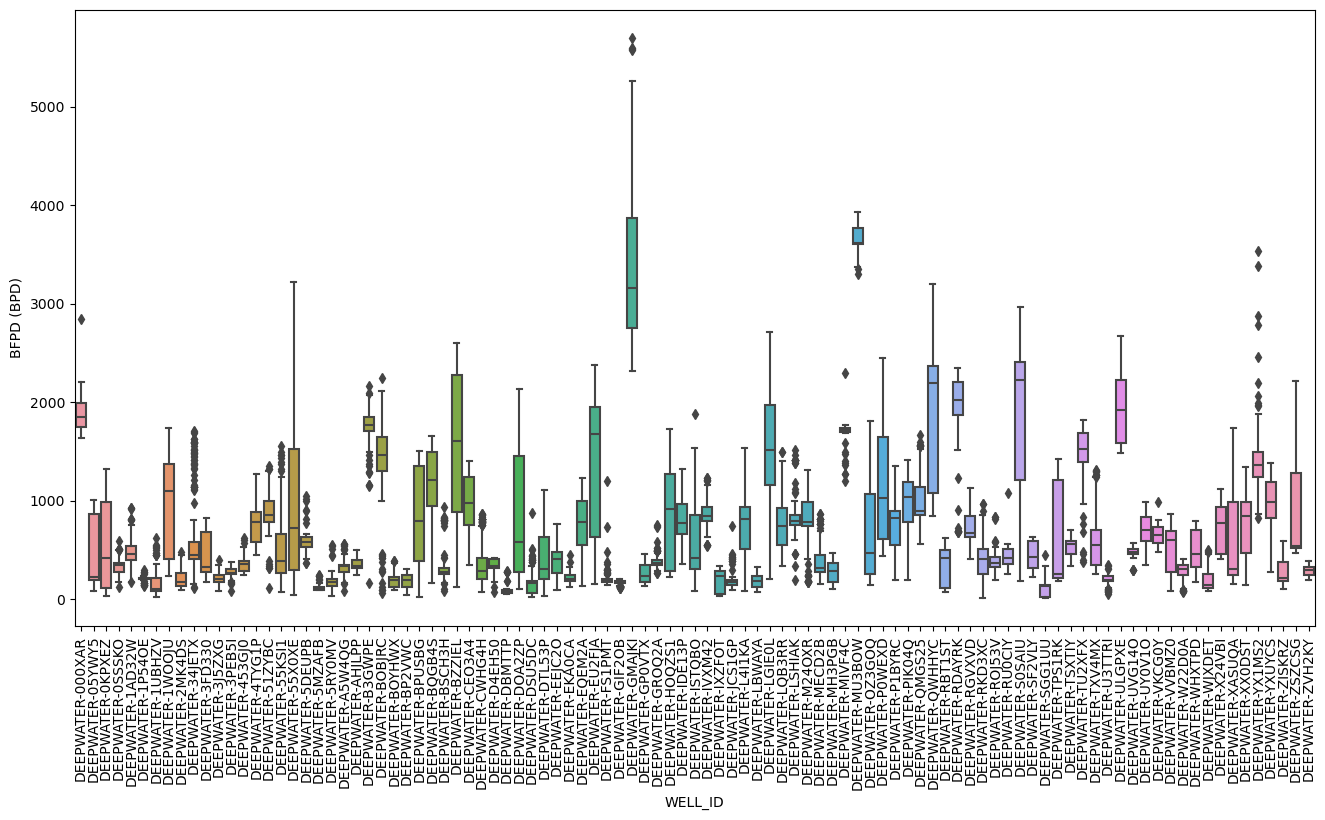

In [47]:
# Boxplot: liquid rate
box_plot(prod_train, 'WELL_ID', 'BFPD', "BFPD (BPD)")

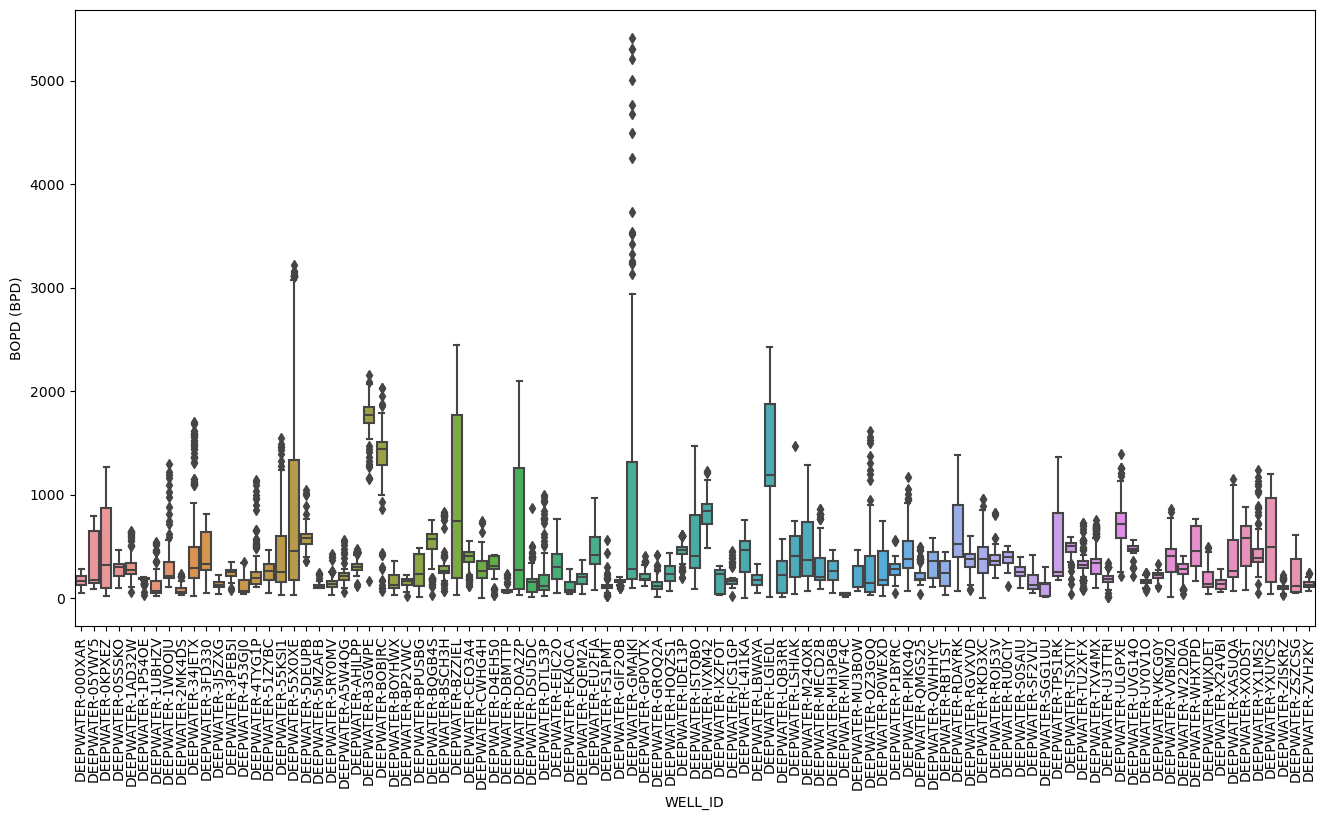

In [48]:
# Boxplot: oil rate
box_plot(prod_train, 'WELL_ID', 'BOPD', "BOPD (BPD)")

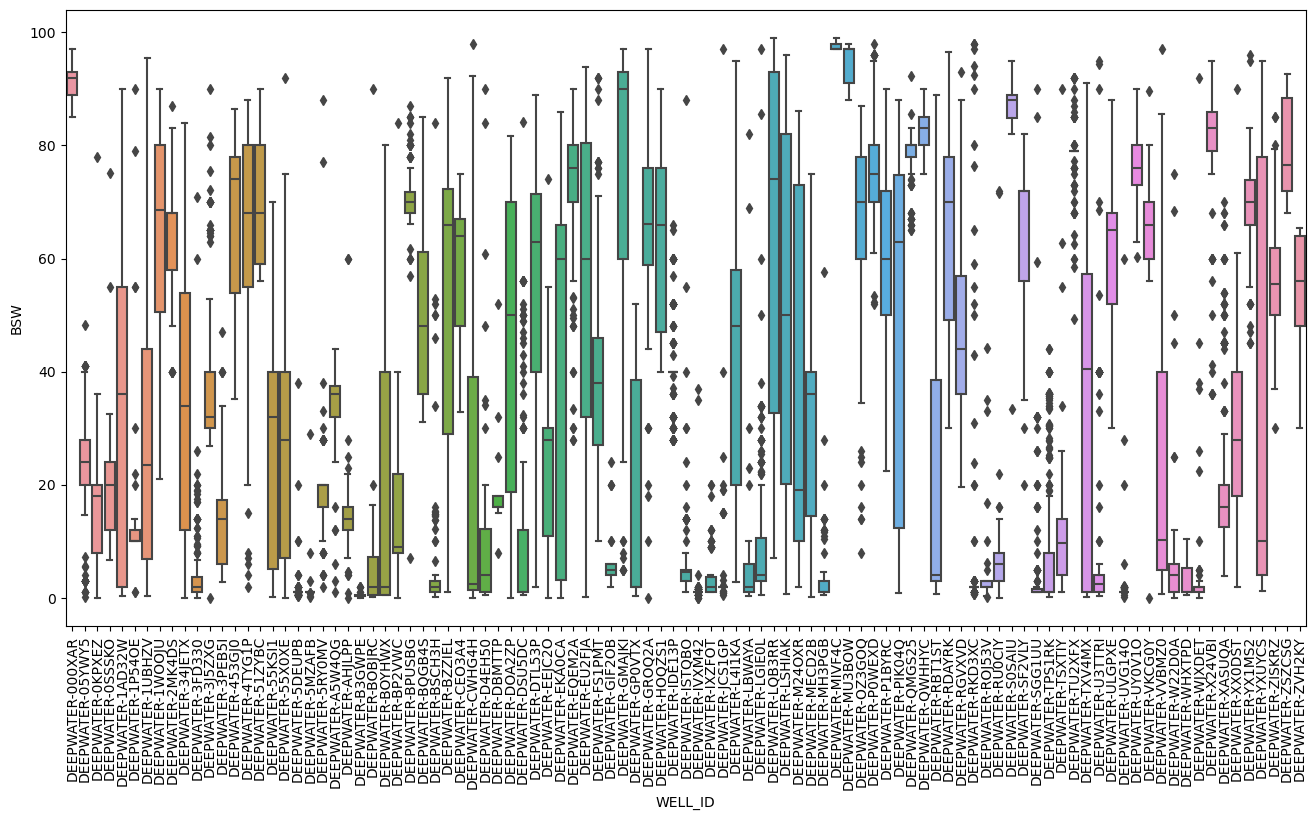

In [49]:
# Boxplot:  water cut
box_plot(prod_train, 'WELL_ID', 'BSW', "BSW")

In [50]:
# Counting the wells with reported failure
wells_failure = esp_train[esp_train['WellFailure'] == 'yes']
len(wells_failure.WELL_ID.unique())

83

In [51]:
# Counting the wells with reported manual off
wells_manual_offs = esp_train[esp_train['WellFailure'] == 'Manual off']
len(wells_manual_offs.WELL_ID.unique())

23

In [52]:
# There are wells that have a reported failure and manual off as the well 'DEEPWATER-L4I1KA'
esp_train[(esp_train['WELL_ID'] == 'DEEPWATER-L4I1KA') & (esp_train['WellFailure'] == 'yes')]

WELL_ID                DATE  CURRENT  PRESS_DESC  FREQUENCY  \
920331  DEEPWATER-L4I1KA 2020-06-01 00:19:47      0.0      1687.0        0.0   

        PRESS_INT  TEMP_INT  TEMP_MOT  OUT_VOLT  VIBRATION WellFailure  
920331     1057.0     231.6     231.0       NaN        0.0         yes

In [53]:
esp_train[(esp_train['WELL_ID'] == 'DEEPWATER-L4I1KA') & (esp_train['WellFailure'] == 'Manual off')]

WELL_ID                DATE    CURRENT  PRESS_DESC  \
247140  DEEPWATER-L4I1KA 2020-02-20 00:25:38  43.400002         NaN   

        FREQUENCY  PRESS_INT  TEMP_INT  TEMP_MOT   OUT_VOLT  VIBRATION  \
247140       65.5        0.0      32.0      32.0  476.60001        0.0   

       WellFailure  
247140  Manual off

In [54]:
# Other wells with doble report: Wellfailure and manual off
#'DEEPWATER-CWHG4H'
#'DEEPWATER-TXV4MX'
#'DEEPWATER-ISTQBO'

# 3. Filtering ESP data

## 3.1. Setting conditions to filter data

In [55]:
# Posible situations for abnormal values
# 1. Frozen sensor
# 2. Station Shutdown 
# 3. Sensor out of calibration

In [56]:
# Ranges for each esp parameter where these values are still considered as NORMAL
esp_train_fil = esp_train[ (esp_train['CURRENT'] >= 0) & (esp_train['CURRENT'] <= 500) ]
#esp_train_fil = esp_train[ (esp_train['PRESS_DESC'] >= 0) & (esp_train['PRESS_DESC'] <= 4500) ]
#esp_train_fil = esp_train[ (esp_train['FREQUENCY'] >= 0) & (esp_train['FREQUENCY'] <= 65) ]
#esp_train_fil = esp_train[ (esp_train['PRESS_INTK'] >= 0) & (esp_train['PRESS_INTK'] <= 4500) ]
#esp_train_fil = esp_train[ (esp_train['TEMP_INT'] >= 0) & (esp_train['TEMP_INT'] <= 300) ]
#esp_train_fil = esp_train[ (esp_train['TEMP_MOT'] >= 0) & (esp_train['TEMP_MOT'] <= 350) ]
#esp_train_fil = esp_train[ (esp_train['VIBRATION'] >= 0) & (esp_train['VIBRATION'] <= 5) ]
#esp_train_fil = esp_train[ (esp_train['TEMP_INTK'] >= 0) & (esp_train['TEMP_INTK'] <= 300) ]


In [57]:
# After filtering values according CURRENT parameter, 3 recordings are lost respect to wellfailure=yes:
# 'DEEPWATER-DSU5DC'
# 'DEEPWATER-P0WEXD'
# 'DEEPWATER-EEJC2O'

# Aftering filter values acordding current parameter, 3 recordings are lost respect to wellfailure=manual off:
# 'DEEPWATER-TXV4MX'
# 'DEEPWATER-CWHG4H'

# These two well are not counted as wellfailure or manual off , they appear in the df but not with the label 'Manual off'
#'DEEPWATER-3FD330'
#'DEEPWATER-55KSI1'


In [58]:
# Total wells are losing their label as manual off or yes
# yes:  'DEEPWATER-DSU5DC', 'DEEPWATER-P0WEXD', 'DEEPWATER-EEJC2O'
# Manual off: # 'DEEPWATER-TXV4MX', # 'DEEPWATER-CWHG4H'
# These two well are not counted as wellfailure or manual off , they appear in the df but not with the label 'Manual off'
#'DEEPWATER-3FD330', #'DEEPWATER-55KSI1'

esp_train[esp_train['WELL_ID'] == 'DEEPWATER-DSU5DC'] # not filtered due to current null values when wellfailure=yes
esp_train[esp_train['WELL_ID'] == 'DEEPWATER-P0WEXD'] # not filtered due to current null values when wellfailure=yes
esp_train[esp_train['WELL_ID'] == 'DEEPWATER-EEJC2O'] # not filtered due to current null values when wellfailure=yes


WELL_ID                DATE    CURRENT  PRESS_DESC  \
33       DEEPWATER-EEJC2O 2020-01-01 08:11:27  20.900000   4120.5996   
95       DEEPWATER-EEJC2O 2020-01-01 08:31:27  21.000000   4115.2998   
166      DEEPWATER-EEJC2O 2020-01-01 08:51:27  20.900000   4116.1001   
230      DEEPWATER-EEJC2O 2020-01-01 09:11:27  21.000000   4116.3999   
301      DEEPWATER-EEJC2O 2020-01-01 09:31:27  21.200001   4104.2998   
...                   ...                 ...        ...         ...   
7855509  DEEPWATER-EEJC2O 2019-12-27 00:00:00  21.090000   4115.2000   
7855510  DEEPWATER-EEJC2O 2019-12-28 00:00:00  20.970000   4109.6600   
7855511  DEEPWATER-EEJC2O 2019-12-29 00:00:00  20.910000   4111.3300   
7855512  DEEPWATER-EEJC2O 2019-12-30 00:00:00  20.860000   4114.7100   
7855513  DEEPWATER-EEJC2O 2019-12-31 00:00:00  20.900000   4126.4500   

         FREQUENCY  PRESS_INT   TEMP_INT   TEMP_MOT   OUT_VOLT  VIBRATION  \
33            62.0  316.89999  251.10001  277.70001  468.79999   0.300204   
95            62.0  316.29999  250.90001  277.70001  470.39999   0.300204   
166           62.0  317.09998  251.10001  277.70001  471.50000   0.400271   
230           62.0  317.19998  250.90001  277.70001  468.00000   0.200136   
301           62.0  316.09998  250.90001  277.70001  470.20001   0.300204   
...            ...        ...        ...        ...        ...        ...   
7855509       62.0  323.89000  252.32000  279.53000  470.38000   0.300000   
7855510       62.0  305.79000  252.59000  279.32000  470.49000   0.290000   
7855511       62.0  309.95000  253.31000  279.74000  470.45000   0.300000   
7855512       62.0  320.37000  253.07000  279.56000  470.57000   0.290000   
7855513       62.0  338.12000  253.10000  279.57000  470.37000   0.290000   

        WellFailure  
33              NaN  
95              NaN  
166             NaN  
230             NaN  
301             NaN  
...             ...  
7855509         NaN  
7855510         NaN  
7855511         NaN  
7855512         NaN  
7855513         NaN  

[48940 rows x 11 columns]

In [59]:
# manual off: 'DEEPWATER-TXV4MX', 'DEEPWATER-CWHG4H', 'DEEPWATER-3FD330', 'DEEPWATER-55KSI1'
# not filtered due to current null values when wellfailure ='Manual off'
esp_train[(esp_train['WELL_ID'] == 'DEEPWATER-TXV4MX') & (esp_train['WellFailure'] == 'Manual off')]
esp_train[(esp_train['WELL_ID'] == 'DEEPWATER-CWHG4H') & (esp_train['WellFailure'] == 'Manual off')]
esp_train[(esp_train['WELL_ID'] == 'DEEPWATER-3FD330') & (esp_train['WellFailure'] == 'Manual off')]
esp_train[(esp_train['WELL_ID'] == 'DEEPWATER-55KSI1') & (esp_train['WellFailure'] == 'Manual off')]

WELL_ID       DATE  CURRENT  PRESS_DESC  FREQUENCY  \
178802  DEEPWATER-55KSI1 2020-02-02      NaN   4351.1997        NaN   

        PRESS_INT   TEMP_INT   TEMP_MOT  OUT_VOLT  VIBRATION WellFailure  
178802  468.19998  239.20001  273.89999       NaN   0.800543  Manual off

## 3.2 Filtering ESP Train data

In [60]:
# Applying proper filtering conditions in order to do not lose data
filt_2 = esp_train[(esp_train['CURRENT'] <= 500) | (esp_train['CURRENT'].isnull())]
filt_2_v2 = filt_2[(filt_2['FREQUENCY'] <= 200) | (filt_2['FREQUENCY'].isnull())]
filt_2_v3 = filt_2_v2[(filt_2_v2['TEMP_MOT'] <= 800) | (filt_2_v2['TEMP_MOT'].isnull())]
filt_2_v4 = filt_2_v3[(filt_2_v3['TEMP_INT'] <= 15000) | (filt_2_v3['WellFailure'] != 'yes') | (filt_2_v3['TEMP_INT'].isnull())]
filt_2_v5 = filt_2_v4[(filt_2_v4['VIBRATION'] <= 70000) | (filt_2_v4['WellFailure'] != 'yes') | (filt_2_v4['VIBRATION'].isnull())]
filt_2_v6 = filt_2_v5[(filt_2_v5['OUT_VOLT'] <= 500) | (filt_2_v5['OUT_VOLT'].isnull())]
filt_2_v7 = filt_2_v6[(filt_2_v6['PRESS_DESC'] < 90000) | (filt_2_v6['PRESS_DESC'].isnull()) | (filt_2_v6['WellFailure'].notnull())]
filt_2_v8 = filt_2_v7[(filt_2_v7['PRESS_INT'] <= 100000) | (filt_2_v7['PRESS_INT'].isnull()) | (filt_2_v7['WellFailure'].notnull())]
filt_2_v9 = filt_2_v8[(filt_2_v8['TEMP_MOT'] <= 700)  | (filt_2_v8['WellFailure'].notnull()) | (filt_2_v8['TEMP_MOT'].isnull())]
filt_2_v10 = filt_2_v9[(filt_2_v9['TEMP_INT'] <= 700)  | (filt_2_v9['WellFailure'].notnull()) | (filt_2_v9['TEMP_INT'].isnull())]

In [61]:
filt_2_v10.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7810960 entries, 0 to 7866956
Data columns (total 11 columns):
 #   Column       Dtype         
---  ------       -----         
 0   WELL_ID      object        
 1   DATE         datetime64[ns]
 2   CURRENT      float64       
 3   PRESS_DESC   float64       
 4   FREQUENCY    float64       
 5   PRESS_INT    float64       
 6   TEMP_INT     float64       
 7   TEMP_MOT     float64       
 8   OUT_VOLT     float64       
 9   VIBRATION    float64       
 10  WellFailure  object        
dtypes: datetime64[ns](1), float64(8), object(2)
memory usage: 715.1+ MB


In [62]:
# Counting wells to check if data is complete
len(filt_2_v10[filt_2_v10['WellFailure'] == 'yes'].WELL_ID.unique())

83

In [63]:
len(filt_2_v10[filt_2_v10['WellFailure'] == 'Manual off'].WELL_ID.unique())

23

In [64]:
# Final dataframe after filtering noise data
train_data = filt_2_v10.copy()
train_data

WELL_ID                DATE    CURRENT  PRESS_DESC  \
0        DEEPWATER-VVBMZ0 2020-01-01 00:00:00   4.480000   2659.0600   
1        DEEPWATER-VKCG0Y 2020-01-01 08:00:31  24.799999   4172.1997   
2        DEEPWATER-HOQZS1 2020-01-01 08:01:14  39.200001   4008.9998   
3        DEEPWATER-IXZFOT 2020-01-01 08:01:54  20.900000   3996.2000   
4        DEEPWATER-3PEB5I 2020-01-01 08:02:22        NaN   3742.3000   
...                   ...                 ...        ...         ...   
7866952  DEEPWATER-ZSZCSG 2019-11-07 00:00:00   0.000000      0.0000   
7866953  DEEPWATER-ZSZCSG 2019-11-08 00:00:00   0.000000      0.0000   
7866954  DEEPWATER-ZSZCSG 2019-11-09 00:00:00   0.000000      0.0000   
7866955  DEEPWATER-ZSZCSG 2019-11-10 00:00:00   0.000000      0.0000   
7866956  DEEPWATER-ZSZCSG 2019-11-11 00:00:00   0.000000      0.0000   

         FREQUENCY   PRESS_INT   TEMP_INT   TEMP_MOT   OUT_VOLT  VIBRATION  \
0             0.55  1966.80000   80.64000  105.57000    0.00000   2.550000   
1            54.00   460.50000  235.39999  279.09998  425.10001   0.200136   
2            59.00   354.20001  223.50000  280.19998  459.89999        NaN   
3           133.00   518.39996  243.50000  319.10001  304.00000        NaN   
4              NaN         NaN  232.20000  276.39999        NaN        NaN   
...            ...         ...        ...        ...        ...        ...   
7866952       0.00  4127.67000  223.00000  223.24000    0.00000   0.110000   
7866953       0.00  4127.75000  222.98000  223.20000    0.00000   0.110000   
7866954       0.00  4125.95000  222.84000  223.11000    0.00000   0.150000   
7866955       0.00  4126.17000  222.79000  223.12000    0.00000   0.110000   
7866956       0.00  4122.66000  222.63000  222.84000    0.00000   0.130000   

        WellFailure  
0               yes  
1               NaN  
2               NaN  
3               NaN  
4               NaN  
...             ...  
7866952         NaN  
7866953         NaN  
7866954         NaN  
7866955         NaN  
7866956         NaN  

[7810960 rows x 11 columns]

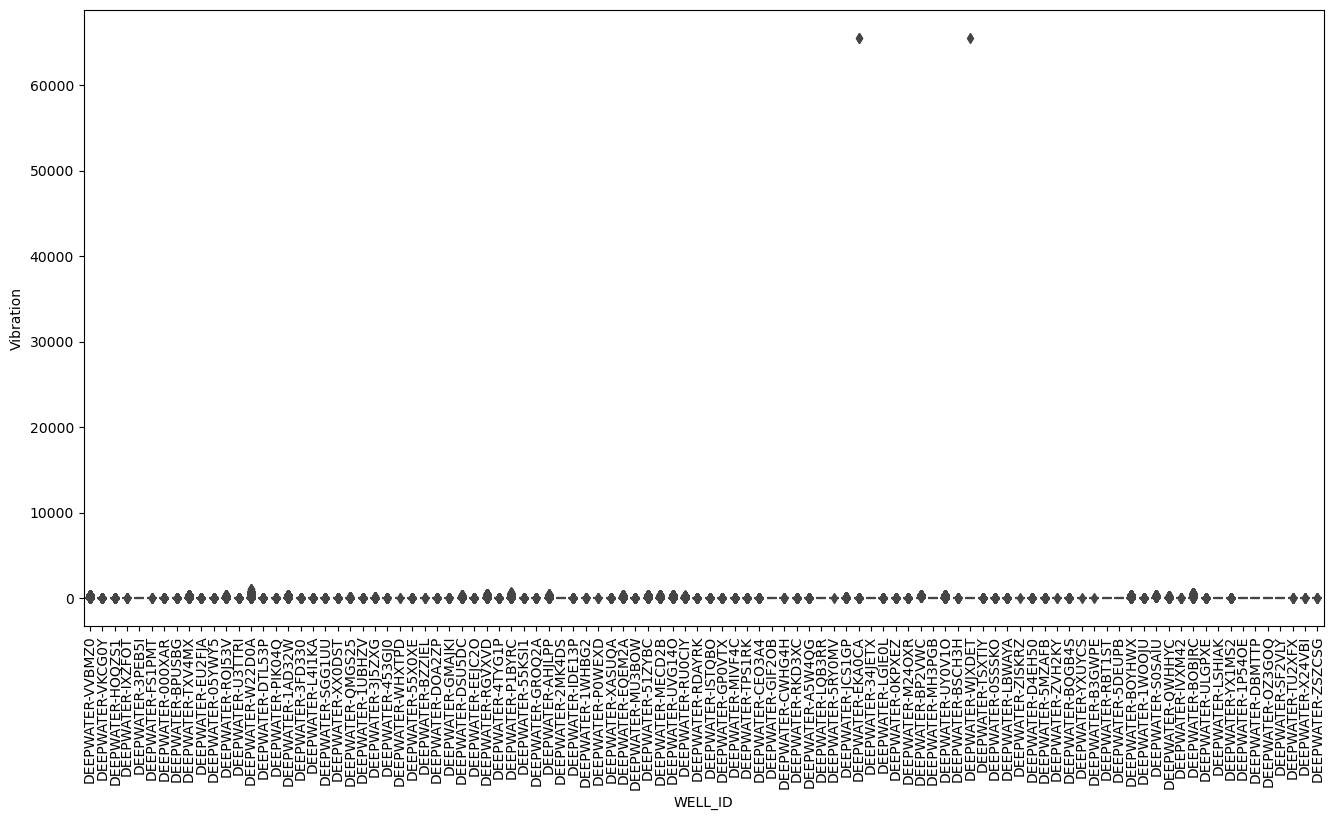

In [168]:
# Plot to check the distribution of the filtered data
box_plot(train_data, 'WELL_ID', 'VIBRATION', "Vibration")

## 3.2 Analyzing filtered data

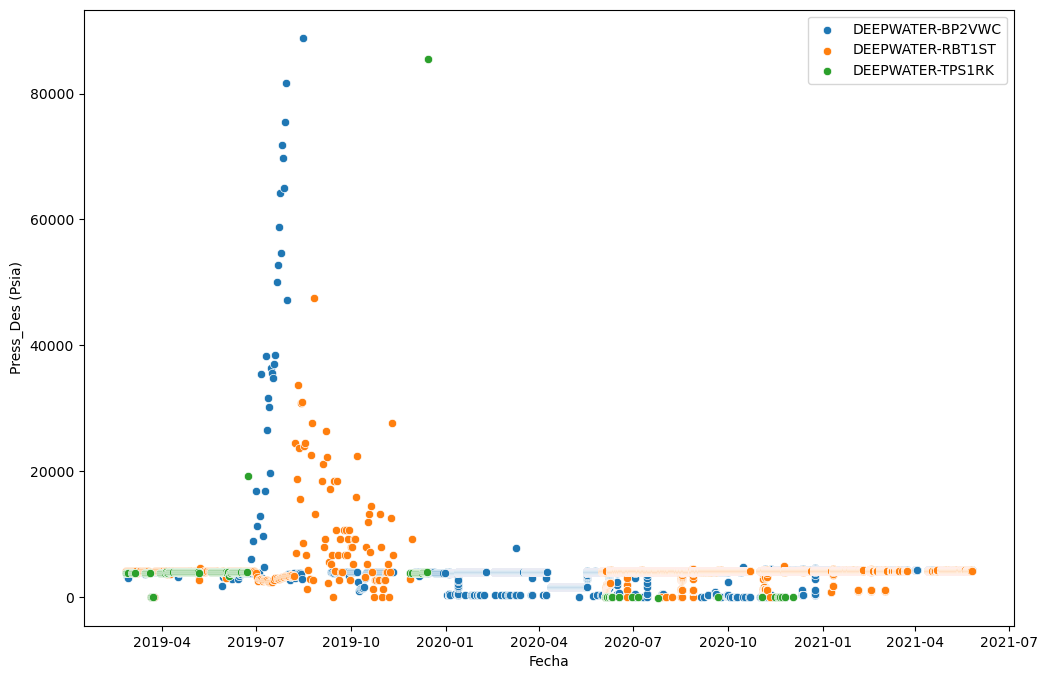

In [66]:
# Discharge Pressure
well_bp = train_data[train_data['WELL_ID'] == 'DEEPWATER-BP2VWC']
well_rb = train_data[train_data['WELL_ID'] == 'DEEPWATER-RBT1ST']
well_wj = train_data[train_data['WELL_ID'] == 'DEEPWATER-WJXDET']
well_tp = train_data[train_data['WELL_ID'] == 'DEEPWATER-TPS1RK']

fig, ax = plt.subplots(figsize=(12, 8))

sns.scatterplot(x='DATE', y='PRESS_DESC', data=well_bp, ax=ax, label="DEEPWATER-BP2VWC")
sns.scatterplot(x='DATE', y='PRESS_DESC', data=well_rb, ax=ax, label="DEEPWATER-RBT1ST")
sns.scatterplot(x='DATE', y='PRESS_DESC', data=well_wj, ax=ax, label="DEEPWATER-TPS1RK")
ax.set_xlabel("Fecha")
ax.set_ylabel("Press_Des (Psia)")
plt.show()

# transformar a 20000

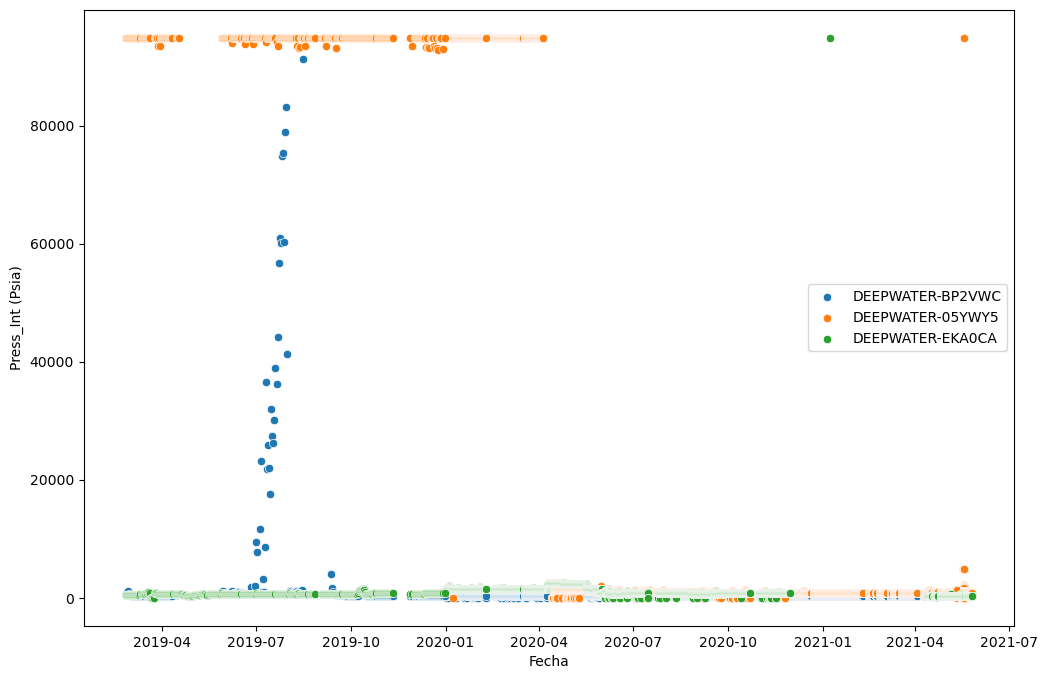

In [67]:
# Intake Pressure

well_0= train_data[train_data['WELL_ID'] == 'DEEPWATER-05YWY5']
well_ek = train_data[train_data['WELL_ID'] == 'DEEPWATER-EKA0CA']

fig, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(x='DATE', y='PRESS_INT', data=well_bp, ax=ax, label="DEEPWATER-BP2VWC")
sns.scatterplot(x='DATE', y='PRESS_INT', data=well_0, ax=ax, label="DEEPWATER-05YWY5")
sns.scatterplot(x='DATE', y='PRESS_INT', data=well_ek, ax=ax, label="DEEPWATER-EKA0CA")
ax.set_xlabel("Fecha")
ax.set_ylabel("Press_Int (Psia)")
plt.show()

# transformar a 20000

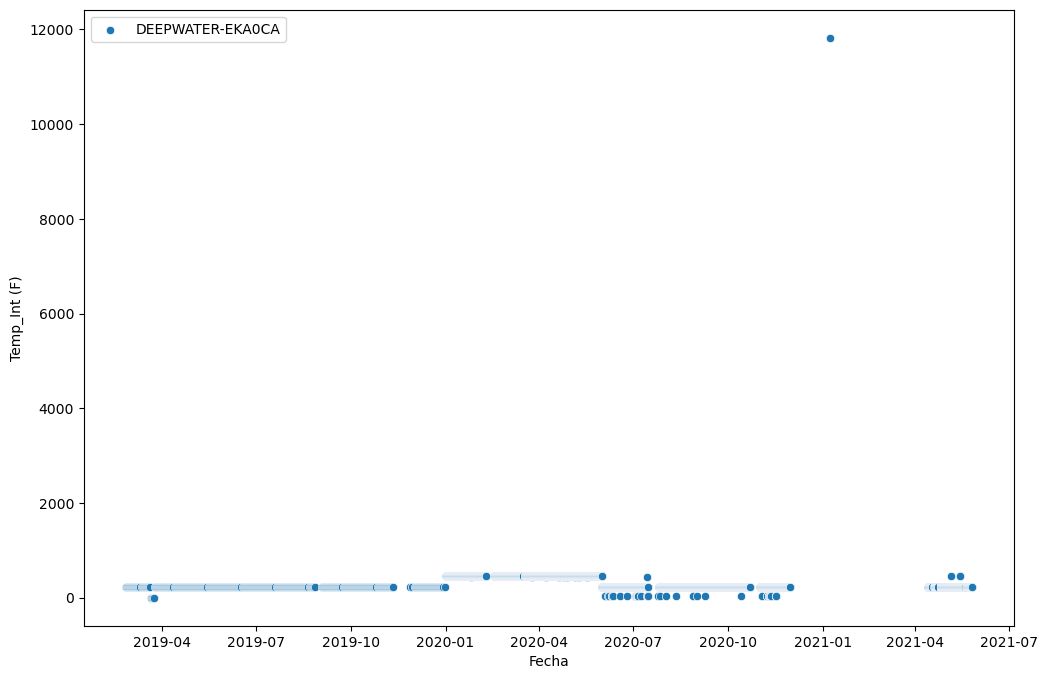

In [68]:
# Intake Temperature
well_ek = train_data[train_data['WELL_ID'] == 'DEEPWATER-EKA0CA']

fig, ax = plt.subplots(figsize=(12, 8))

sns.scatterplot(x='DATE', y='TEMP_INT', data=well_ek, ax=ax, label="DEEPWATER-EKA0CA")
ax.set_xlabel("Fecha")
ax.set_ylabel("Temp_Int (F)")
plt.show()


## 3.3 Filtering Test ESP data

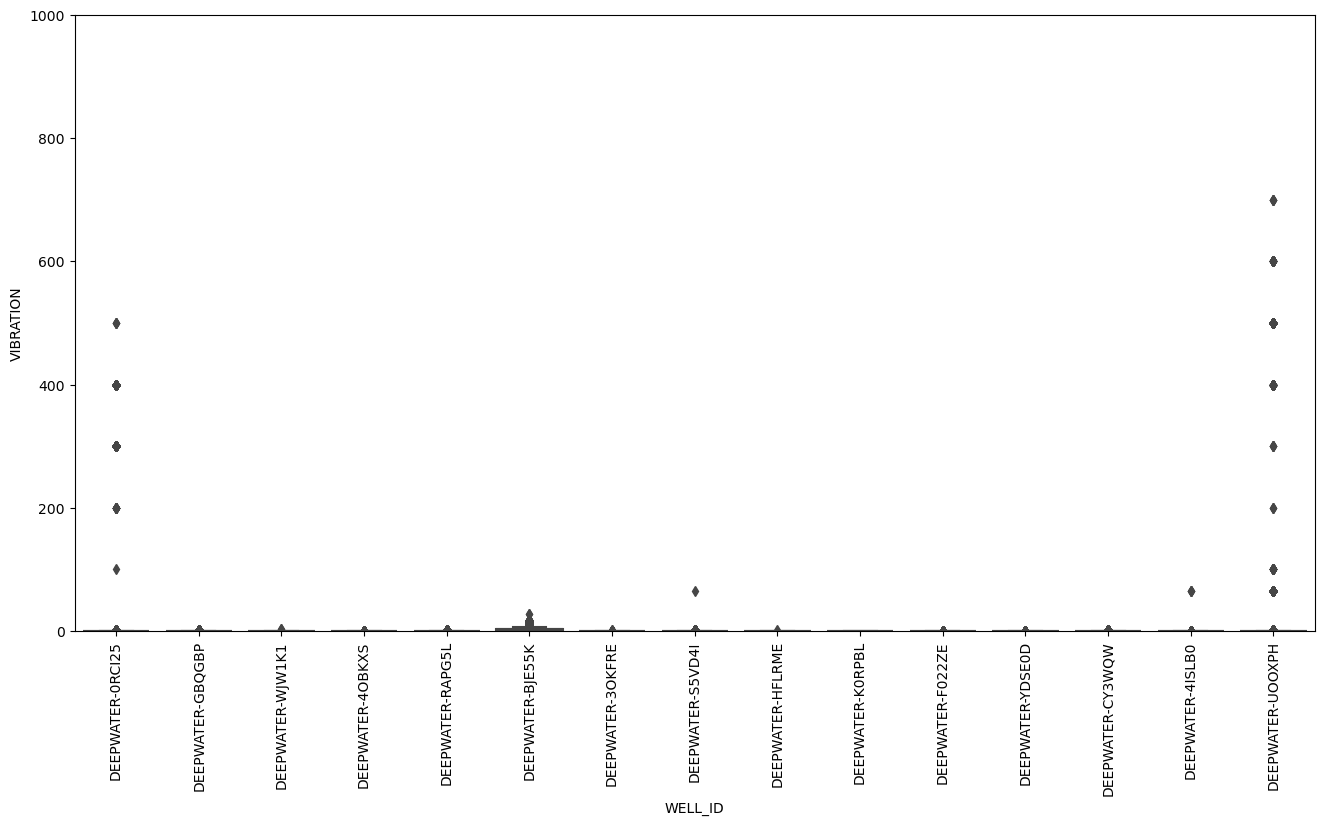

In [69]:
box_plot(esp_test, 'WELL_ID', 'VIBRATION', "VIBRATION", 1000)

# 4. Outliers treatment

## 4.1 Train Data

In [70]:
# As you saw previously, there are still outliers in our dataset so the have to be treated.

In [71]:
# Define upper limits to replace outliers
transf_train = train_data.copy()
transf_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7810960 entries, 0 to 7866956
Data columns (total 11 columns):
 #   Column       Dtype         
---  ------       -----         
 0   WELL_ID      object        
 1   DATE         datetime64[ns]
 2   CURRENT      float64       
 3   PRESS_DESC   float64       
 4   FREQUENCY    float64       
 5   PRESS_INT    float64       
 6   TEMP_INT     float64       
 7   TEMP_MOT     float64       
 8   OUT_VOLT     float64       
 9   VIBRATION    float64       
 10  WellFailure  object        
dtypes: datetime64[ns](1), float64(8), object(2)
memory usage: 715.1+ MB


In [72]:
# Transforming values
transf_train['PRESS_DESC'] = np.where(transf_train['PRESS_DESC'] > 20000, 20000, transf_train['PRESS_DESC'])
transf_train['PRESS_INT'] = np.where(transf_train['PRESS_INT'] > 20000, 20000, transf_train['PRESS_INT'])
transf_train['TEMP_INT'] = np.where(transf_train['TEMP_INT'] > 800, 700, transf_train['TEMP_INT'])
transf_train['VIBRATION'] = np.where(transf_train['VIBRATION'] > 1000, 1000, transf_train['VIBRATION'])

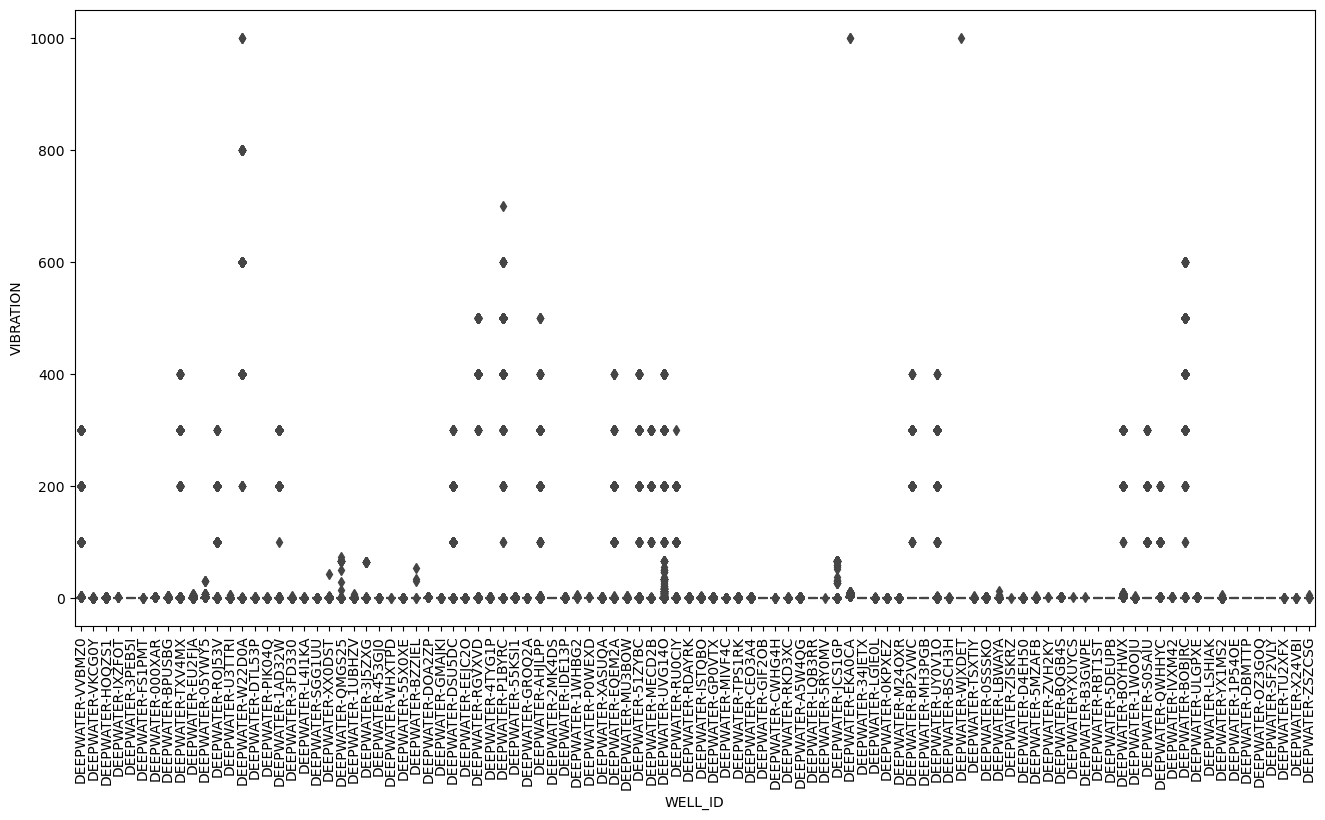

In [73]:
# Checking variables distribution after transformation
box_plot(transf_train, 'WELL_ID', 'VIBRATION', "VIBRATION")

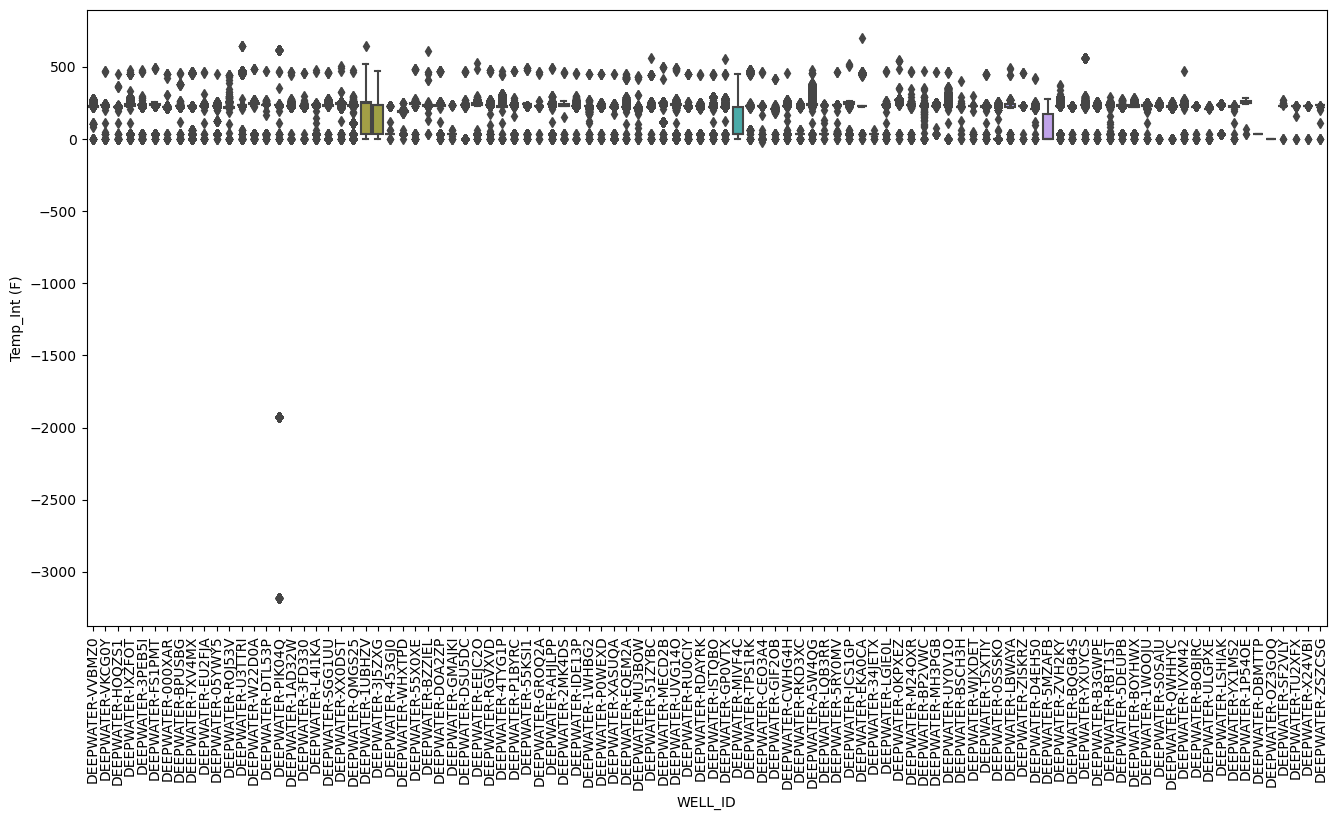

In [169]:
# Checking variables distribution after transformation
box_plot(transf_train, 'WELL_ID', 'TEMP_INT', "Temp_Int (F)")

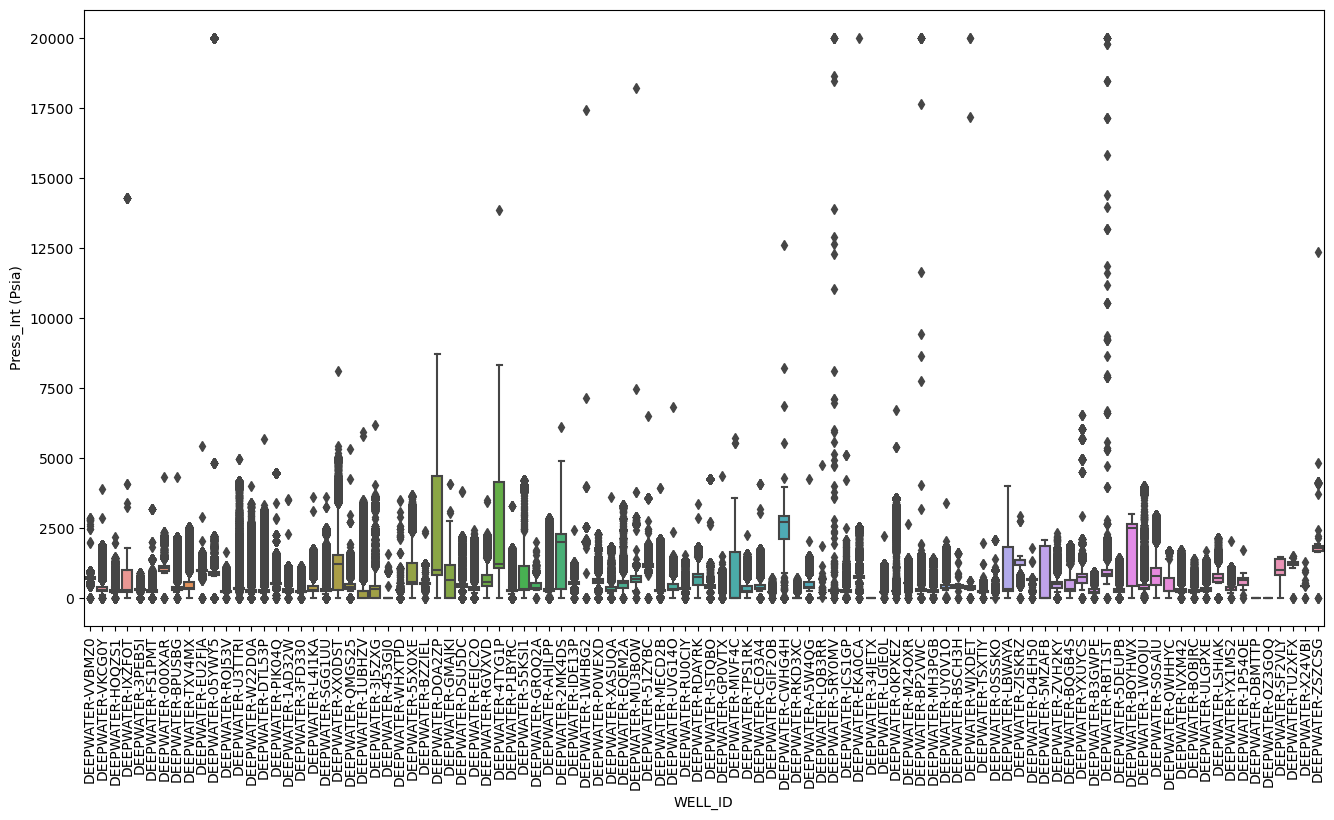

In [170]:
# Checking variables distribution after transformation
box_plot(transf_train, 'WELL_ID', 'PRESS_INT', "Press_Int (Psia)")

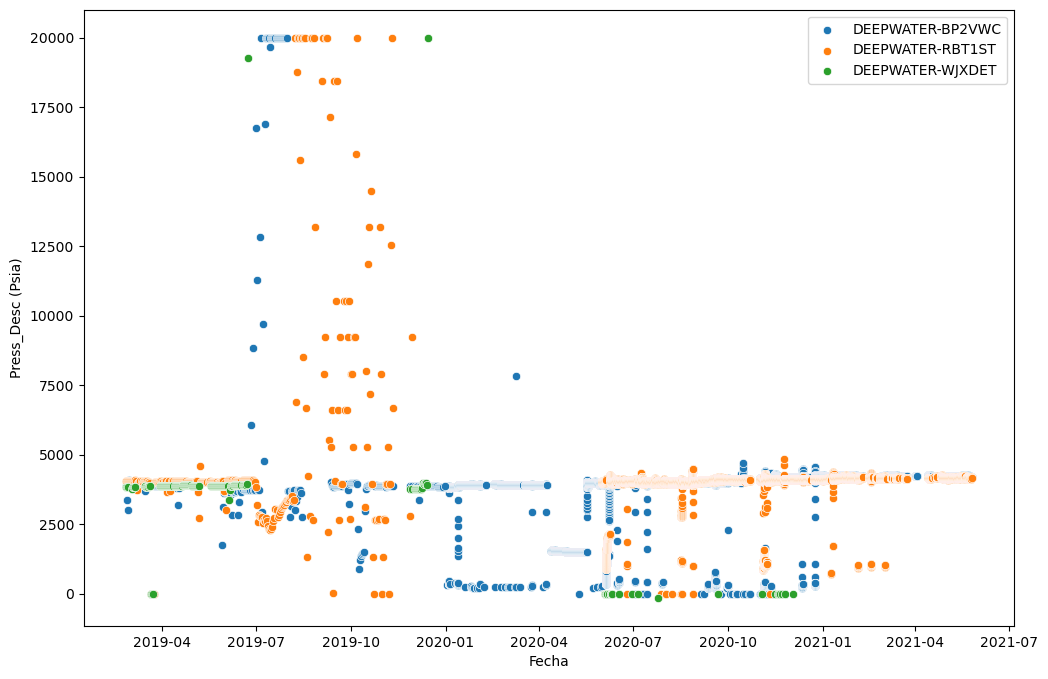

In [74]:
wells_bp = transf_train[transf_train['WELL_ID'] == 'DEEPWATER-BP2VWC']
wells_rb = transf_train[transf_train['WELL_ID'] == 'DEEPWATER-RBT1ST']
wells_wj = transf_train[transf_train['WELL_ID'] == 'DEEPWATER-WJXDET']
wells_tp = transf_train[transf_train['WELL_ID'] == 'DEEPWATER-TPS1RK']

fig, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(x='DATE', y='PRESS_DESC', data=wells_bp, ax=ax, label='DEEPWATER-BP2VWC')
sns.scatterplot(x='DATE', y='PRESS_DESC', data=wells_rb, ax=ax, label='DEEPWATER-RBT1ST')
sns.scatterplot(x='DATE', y='PRESS_DESC', data=wells_wj, ax=ax, label='DEEPWATER-WJXDET')
ax.set_xlabel("Fecha")
ax.set_ylabel("Press_Desc (Psia)")
plt.show()

# transformar a 20000

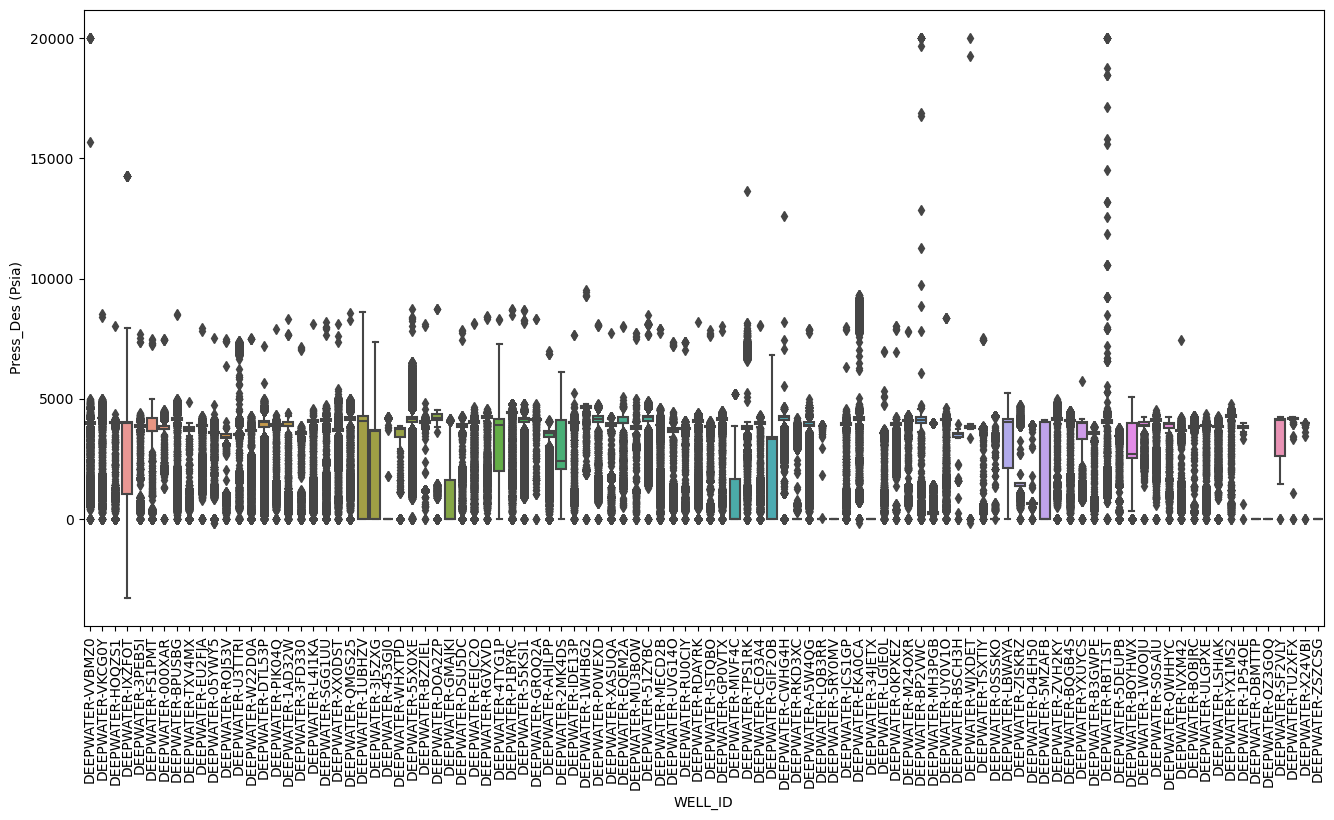

In [75]:
box_plot(transf_train, 'WELL_ID', 'PRESS_DESC', "Press_Des (Psia)")

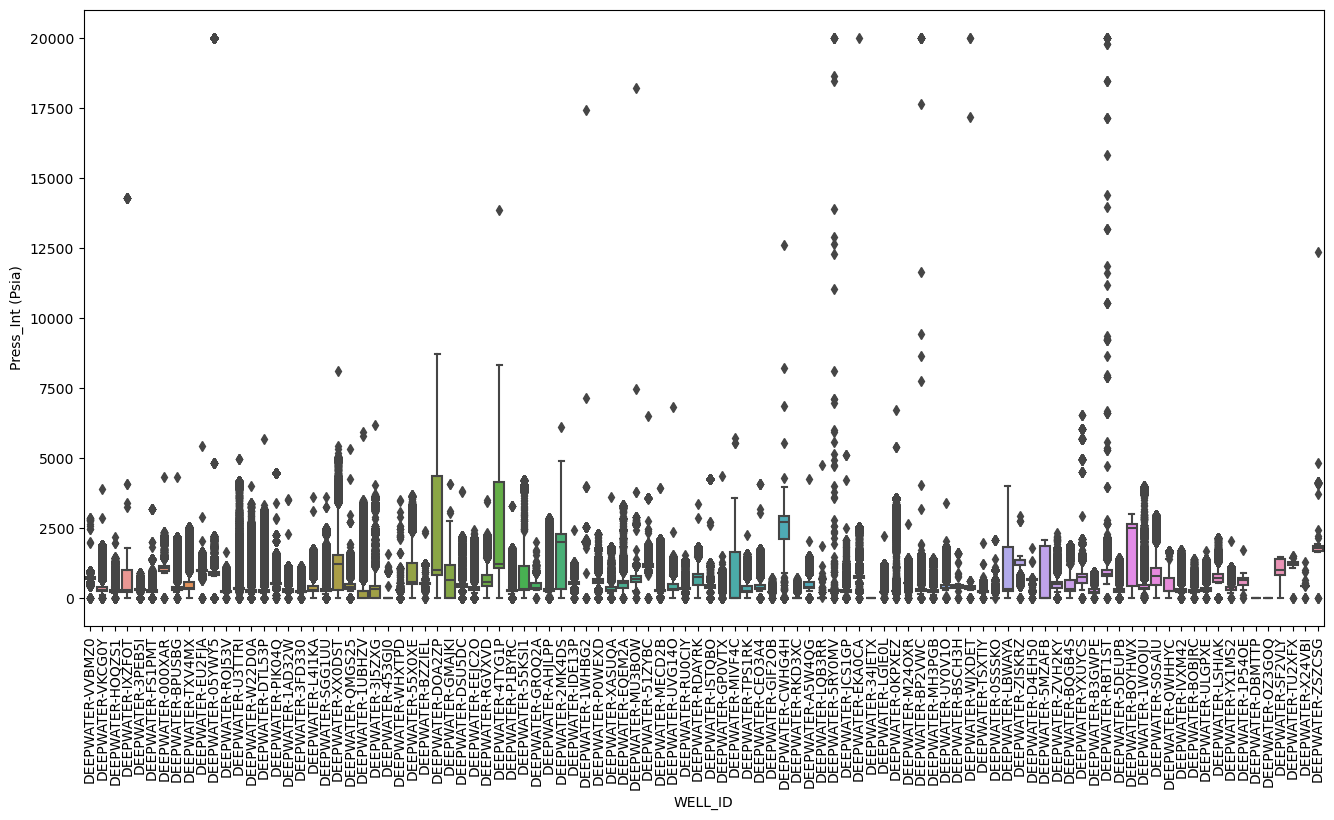

In [76]:
box_plot(transf_train, 'WELL_ID', 'PRESS_INT', "Press_Int (Psia)")

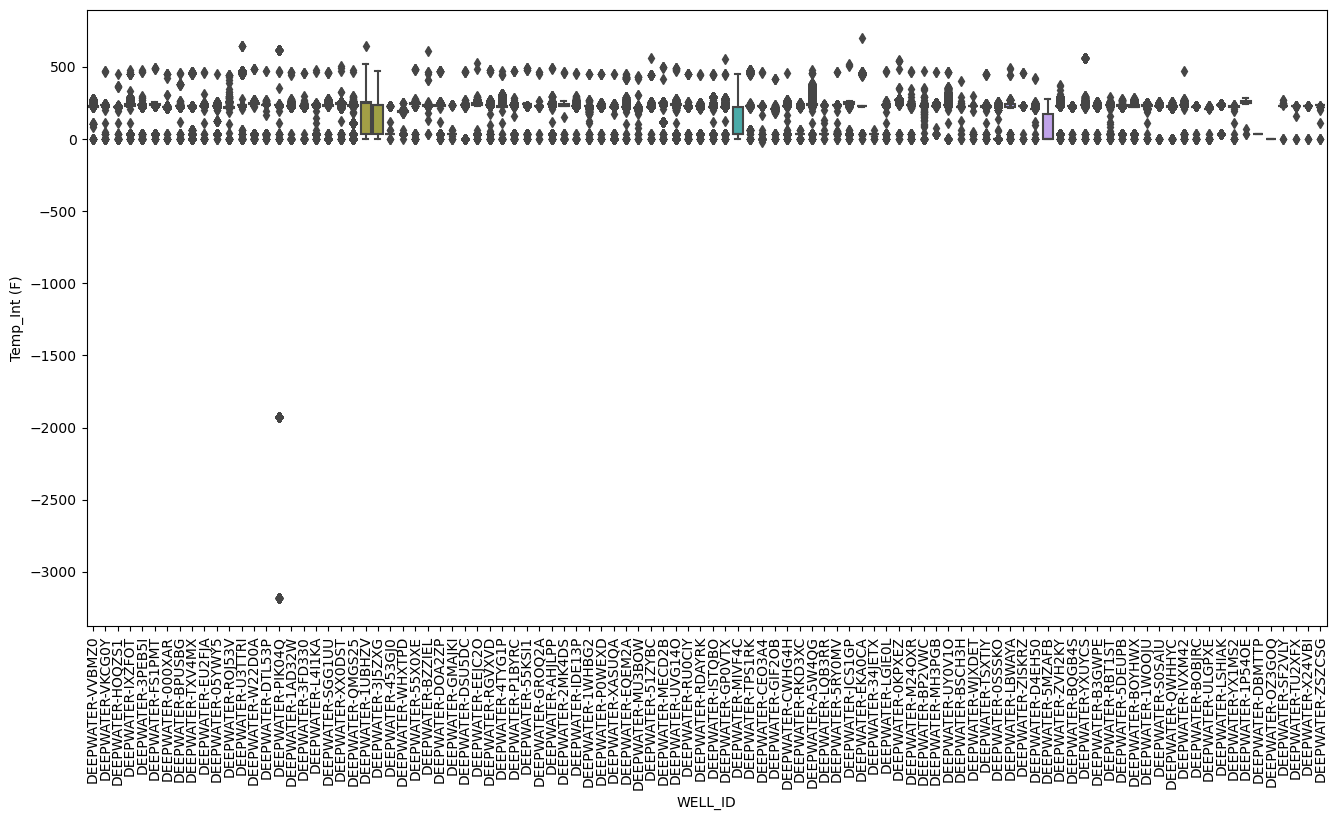

In [77]:
box_plot(transf_train, 'WELL_ID', 'TEMP_INT', "Temp_Int (F)")

## 4.2 Test Data

In [78]:
transf_test = esp_test.copy()

In [79]:
# Transforming values

transf_test['PRESS_INT'] = np.where(transf_test['PRESS_INT'] > 20000, 20000, transf_test['PRESS_INT'])
transf_test['TEMP_INT'] = np.where(transf_test['TEMP_INT'] > 800, 700, transf_test['TEMP_INT'])
transf_test['TEMP_MOT'] = np.where(transf_test['TEMP_MOT'] > 800, 700, transf_test['TEMP_MOT'])
transf_test['VIBRATION'] = np.where(transf_test['VIBRATION'] > 1000, 1000, transf_test['VIBRATION'])

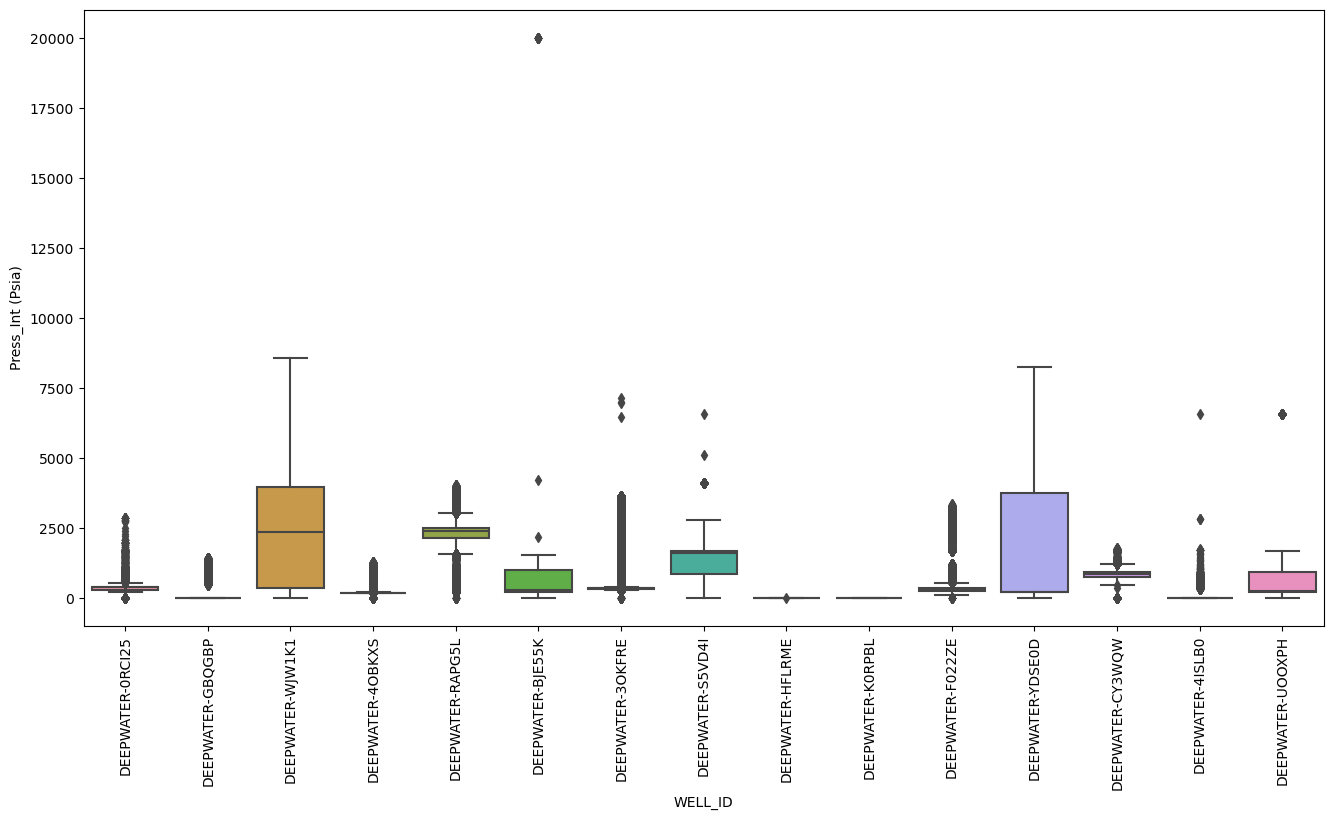

In [80]:
box_plot(transf_test, 'WELL_ID', 'PRESS_INT', "Press_Int (Psia)")

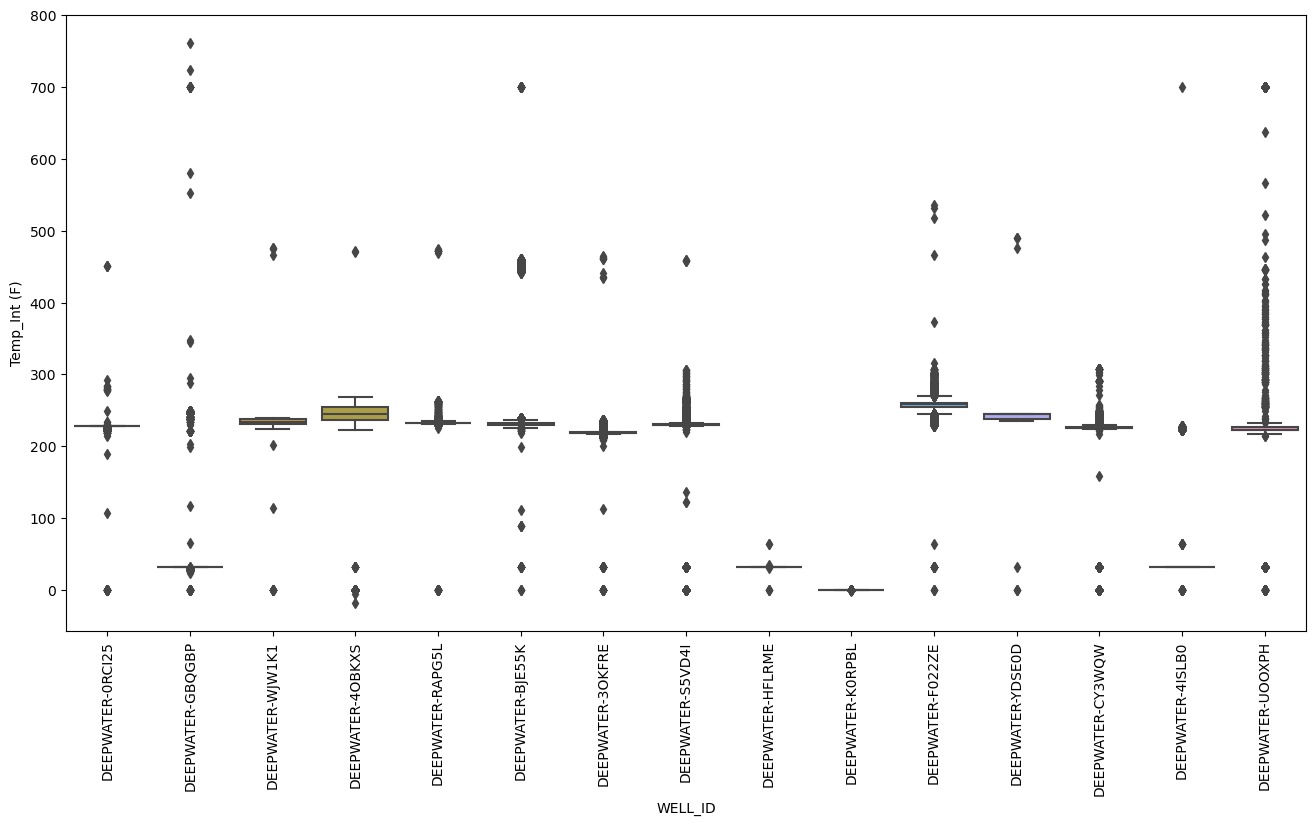

In [81]:
box_plot(transf_test, 'WELL_ID', 'TEMP_INT', "Temp_Int (F)")

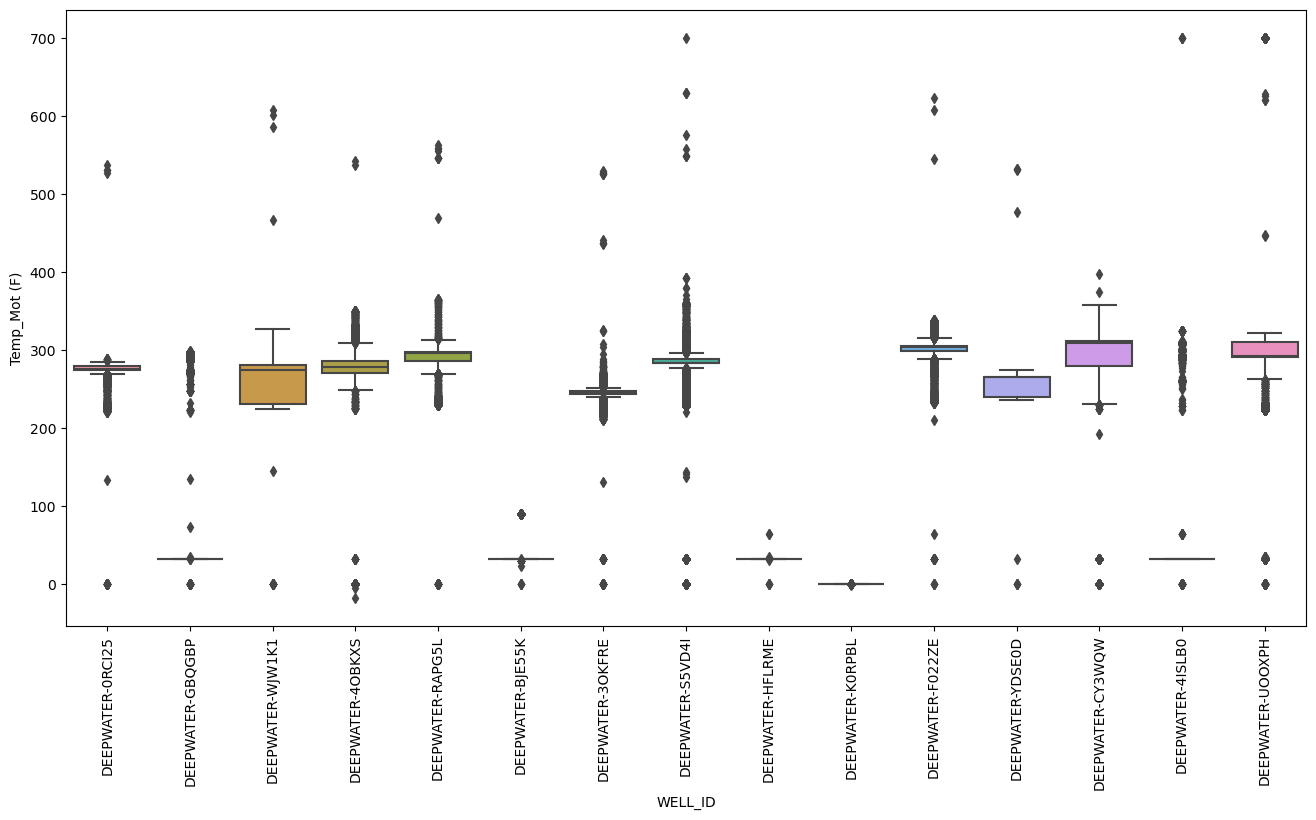

In [82]:
box_plot(transf_test, 'WELL_ID', 'TEMP_MOT', "Temp_Mot (F)")

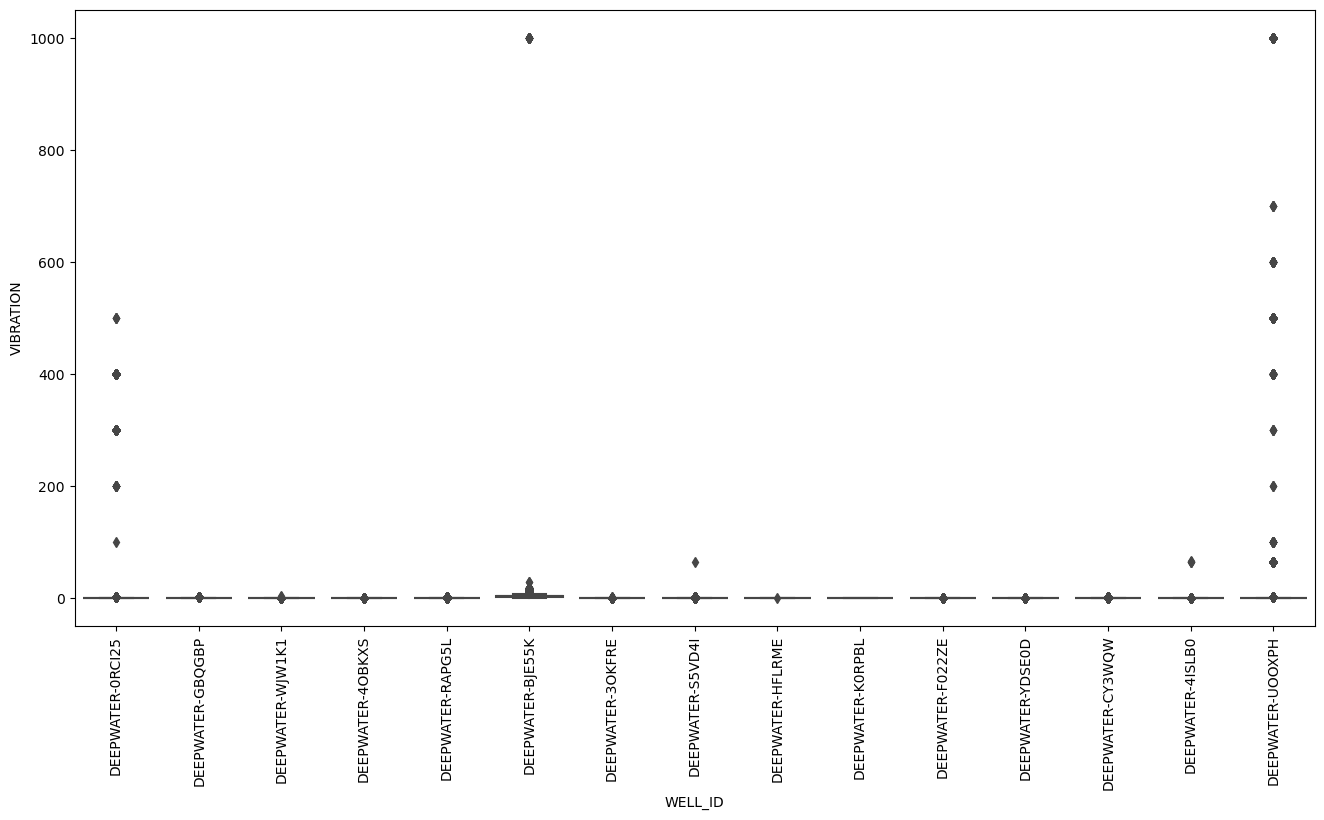

In [83]:
box_plot(transf_test, 'WELL_ID', 'VIBRATION', "VIBRATION")

# 5. Filling null values

In [84]:
# Making a copy of the transf_data
train_df = transf_train.copy()
train_df

WELL_ID                DATE    CURRENT  PRESS_DESC  \
0        DEEPWATER-VVBMZ0 2020-01-01 00:00:00   4.480000   2659.0600   
1        DEEPWATER-VKCG0Y 2020-01-01 08:00:31  24.799999   4172.1997   
2        DEEPWATER-HOQZS1 2020-01-01 08:01:14  39.200001   4008.9998   
3        DEEPWATER-IXZFOT 2020-01-01 08:01:54  20.900000   3996.2000   
4        DEEPWATER-3PEB5I 2020-01-01 08:02:22        NaN   3742.3000   
...                   ...                 ...        ...         ...   
7866952  DEEPWATER-ZSZCSG 2019-11-07 00:00:00   0.000000      0.0000   
7866953  DEEPWATER-ZSZCSG 2019-11-08 00:00:00   0.000000      0.0000   
7866954  DEEPWATER-ZSZCSG 2019-11-09 00:00:00   0.000000      0.0000   
7866955  DEEPWATER-ZSZCSG 2019-11-10 00:00:00   0.000000      0.0000   
7866956  DEEPWATER-ZSZCSG 2019-11-11 00:00:00   0.000000      0.0000   

         FREQUENCY   PRESS_INT   TEMP_INT   TEMP_MOT   OUT_VOLT  VIBRATION  \
0             0.55  1966.80000   80.64000  105.57000    0.00000   2.550000   
1            54.00   460.50000  235.39999  279.09998  425.10001   0.200136   
2            59.00   354.20001  223.50000  280.19998  459.89999        NaN   
3           133.00   518.39996  243.50000  319.10001  304.00000        NaN   
4              NaN         NaN  232.20000  276.39999        NaN        NaN   
...            ...         ...        ...        ...        ...        ...   
7866952       0.00  4127.67000  223.00000  223.24000    0.00000   0.110000   
7866953       0.00  4127.75000  222.98000  223.20000    0.00000   0.110000   
7866954       0.00  4125.95000  222.84000  223.11000    0.00000   0.150000   
7866955       0.00  4126.17000  222.79000  223.12000    0.00000   0.110000   
7866956       0.00  4122.66000  222.63000  222.84000    0.00000   0.130000   

        WellFailure  
0               yes  
1               NaN  
2               NaN  
3               NaN  
4               NaN  
...             ...  
7866952         NaN  
7866953         NaN  
7866954         NaN  
7866955         NaN  
7866956         NaN  

[7810960 rows x 11 columns]

## 5.1.1 Filling WellFailure column - Train dataset

In [85]:
# Count Values for each well failure label
train_df.WellFailure.value_counts()

WellFailure
yes           88
Manual off    23
Name: count, dtype: int64

In [86]:
train_df.WellFailure.unique()

array(['yes', nan, 'Manual off'], dtype=object)

In [87]:
# Filling column WellFailure

# train_df['WellFailure'].fillna('No', inplace=True)
# train_df.isna().sum()

In [88]:
# Count Values for each well failure label after filling null values
train_df.WellFailure.value_counts()

WellFailure
yes           88
Manual off    23
Name: count, dtype: int64

## 5.1.2 Filling other columns - Train dataset

## 5.1.2.1 Encoding categorical variables: WELL_ID and WellFailure

In [89]:
# Encoding categorical variables
# enc = OrdinalEncoder()
# enc.fit(train_df[["WellFailure"]])
# train_df[["WellFailure"]] = enc.transform(train_df[["WellFailure"]])

In [90]:
# Checking results
train_df

WELL_ID                DATE    CURRENT  PRESS_DESC  \
0        DEEPWATER-VVBMZ0 2020-01-01 00:00:00   4.480000   2659.0600   
1        DEEPWATER-VKCG0Y 2020-01-01 08:00:31  24.799999   4172.1997   
2        DEEPWATER-HOQZS1 2020-01-01 08:01:14  39.200001   4008.9998   
3        DEEPWATER-IXZFOT 2020-01-01 08:01:54  20.900000   3996.2000   
4        DEEPWATER-3PEB5I 2020-01-01 08:02:22        NaN   3742.3000   
...                   ...                 ...        ...         ...   
7866952  DEEPWATER-ZSZCSG 2019-11-07 00:00:00   0.000000      0.0000   
7866953  DEEPWATER-ZSZCSG 2019-11-08 00:00:00   0.000000      0.0000   
7866954  DEEPWATER-ZSZCSG 2019-11-09 00:00:00   0.000000      0.0000   
7866955  DEEPWATER-ZSZCSG 2019-11-10 00:00:00   0.000000      0.0000   
7866956  DEEPWATER-ZSZCSG 2019-11-11 00:00:00   0.000000      0.0000   

         FREQUENCY   PRESS_INT   TEMP_INT   TEMP_MOT   OUT_VOLT  VIBRATION  \
0             0.55  1966.80000   80.64000  105.57000    0.00000   2.550000   
1            54.00   460.50000  235.39999  279.09998  425.10001   0.200136   
2            59.00   354.20001  223.50000  280.19998  459.89999        NaN   
3           133.00   518.39996  243.50000  319.10001  304.00000        NaN   
4              NaN         NaN  232.20000  276.39999        NaN        NaN   
...            ...         ...        ...        ...        ...        ...   
7866952       0.00  4127.67000  223.00000  223.24000    0.00000   0.110000   
7866953       0.00  4127.75000  222.98000  223.20000    0.00000   0.110000   
7866954       0.00  4125.95000  222.84000  223.11000    0.00000   0.150000   
7866955       0.00  4126.17000  222.79000  223.12000    0.00000   0.110000   
7866956       0.00  4122.66000  222.63000  222.84000    0.00000   0.130000   

        WellFailure  
0               yes  
1               NaN  
2               NaN  
3               NaN  
4               NaN  
...             ...  
7866952         NaN  
7866953         NaN  
7866954         NaN  
7866955         NaN  
7866956         NaN  

[7810960 rows x 11 columns]

In [91]:
# Variable WellFailure = 2 is equivalent to label 'yes'
len(train_df[train_df['WellFailure'] == "yes"].WELL_ID.unique())

83

In [92]:
# Variable WellFailure = 0 is equivalent to label 'Manual off'
len(train_df[train_df['WellFailure'] == 'Manual off'].WELL_ID.unique())

23

In [93]:
# Variable WellFailure = 1 is equivalent to label 'No'

In [94]:
#Checking new well names
train_df.WELL_ID.unique()

array(['DEEPWATER-VVBMZ0', 'DEEPWATER-VKCG0Y', 'DEEPWATER-HOQZS1',
       'DEEPWATER-IXZFOT', 'DEEPWATER-3PEB5I', 'DEEPWATER-FS1PMT',
       'DEEPWATER-000XAR', 'DEEPWATER-BPUSBG', 'DEEPWATER-TXV4MX',
       'DEEPWATER-EU2FJA', 'DEEPWATER-05YWY5', 'DEEPWATER-ROJ53V',
       'DEEPWATER-U3TTRI', 'DEEPWATER-W22D0A', 'DEEPWATER-DTL53P',
       'DEEPWATER-PIK04Q', 'DEEPWATER-1AD32W', 'DEEPWATER-3FD330',
       'DEEPWATER-L4I1KA', 'DEEPWATER-SGG1UU', 'DEEPWATER-XX0DST',
       'DEEPWATER-QMGS25', 'DEEPWATER-1UBHZV', 'DEEPWATER-3J5ZXG',
       'DEEPWATER-453GJ0', 'DEEPWATER-WHXTPD', 'DEEPWATER-55X0XE',
       'DEEPWATER-BZZIEL', 'DEEPWATER-DOA2ZP', 'DEEPWATER-GMAJKI',
       'DEEPWATER-DSU5DC', 'DEEPWATER-EEJC2O', 'DEEPWATER-RGVXVD',
       'DEEPWATER-4TYG1P', 'DEEPWATER-P1BYRC', 'DEEPWATER-55KSI1',
       'DEEPWATER-GROQ2A', 'DEEPWATER-AHJLPP', 'DEEPWATER-2MK4DS',
       'DEEPWATER-IDE13P', 'DEEPWATER-1WHBG2', 'DEEPWATER-P0WEXD',
       'DEEPWATER-XASUQA', 'DEEPWATER-EQEM2A', 'DEEPWATER-MU3B

## 5.1.2.2 Using MICE to fill null values

In [95]:
# Selecting only numerical variables 
num_data = train_df.iloc[:, [2, 3, 4, 5, 6, 7, 8, 9]]

In [96]:
num_data

CURRENT  PRESS_DESC  FREQUENCY   PRESS_INT   TEMP_INT   TEMP_MOT  \
0         4.480000   2659.0600       0.55  1966.80000   80.64000  105.57000   
1        24.799999   4172.1997      54.00   460.50000  235.39999  279.09998   
2        39.200001   4008.9998      59.00   354.20001  223.50000  280.19998   
3        20.900000   3996.2000     133.00   518.39996  243.50000  319.10001   
4              NaN   3742.3000        NaN         NaN  232.20000  276.39999   
...            ...         ...        ...         ...        ...        ...   
7866952   0.000000      0.0000       0.00  4127.67000  223.00000  223.24000   
7866953   0.000000      0.0000       0.00  4127.75000  222.98000  223.20000   
7866954   0.000000      0.0000       0.00  4125.95000  222.84000  223.11000   
7866955   0.000000      0.0000       0.00  4126.17000  222.79000  223.12000   
7866956   0.000000      0.0000       0.00  4122.66000  222.63000  222.84000   

          OUT_VOLT  VIBRATION  
0          0.00000   2.550000  
1        425.10001   0.200136  
2        459.89999        NaN  
3        304.00000        NaN  
4              NaN        NaN  
...            ...        ...  
7866952    0.00000   0.110000  
7866953    0.00000   0.110000  
7866954    0.00000   0.150000  
7866955    0.00000   0.110000  
7866956    0.00000   0.130000  

[7810960 rows x 8 columns]

In [97]:
# Using MICE to fill null values
mice_impute = IterativeImputer()
traindatafill = mice_impute.fit_transform(num_data)

In [98]:
# Converting traindatafill to dataframe
train_fill = pd.DataFrame(traindatafill)
train_fill.head()

0          1           2            3          4          5  \
0   4.480000  2659.0600    0.550000  1966.800000   80.64000  105.57000   
1  24.799999  4172.1997   54.000000   460.500000  235.39999  279.09998   
2  39.200001  4008.9998   59.000000   354.200010  223.50000  280.19998   
3  20.900000  3996.2000  133.000000   518.399960  243.50000  319.10001   
4  37.279441  3742.3000   56.671786   546.726796  232.20000  276.39999   

            6          7  
0    0.000000   2.550000  
1  425.100010   0.200136  
2  459.899990   5.290423  
3  304.000000 -14.250129  
4  404.612455   1.784293

In [99]:
# Renaming columns
train_fill = train_fill.rename(columns={0:'CURRENT', 1:'PRESS_DESC', 2:'FREQUENCY', 3:'PRESS_INT', 4:'TEMP_INT',
                                       5:'TEMP_MOT', 6:'OUT_VOLT', 7:'VIBRATION'})

In [100]:
# Checking null values
train_fill.isna().sum()

CURRENT       0
PRESS_DESC    0
FREQUENCY     0
PRESS_INT     0
TEMP_INT      0
TEMP_MOT      0
OUT_VOLT      0
VIBRATION     0
dtype: int64

In [101]:
train_fill.head()

CURRENT  PRESS_DESC   FREQUENCY    PRESS_INT   TEMP_INT   TEMP_MOT  \
0   4.480000   2659.0600    0.550000  1966.800000   80.64000  105.57000   
1  24.799999   4172.1997   54.000000   460.500000  235.39999  279.09998   
2  39.200001   4008.9998   59.000000   354.200010  223.50000  280.19998   
3  20.900000   3996.2000  133.000000   518.399960  243.50000  319.10001   
4  37.279441   3742.3000   56.671786   546.726796  232.20000  276.39999   

     OUT_VOLT  VIBRATION  
0    0.000000   2.550000  
1  425.100010   0.200136  
2  459.899990   5.290423  
3  304.000000 -14.250129  
4  404.612455   1.784293

In [102]:
date= train_df[['DATE', 'WELL_ID', 'WellFailure']].reset_index()
date.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7810960 entries, 0 to 7810959
Data columns (total 4 columns):
 #   Column       Dtype         
---  ------       -----         
 0   index        int64         
 1   DATE         datetime64[ns]
 2   WELL_ID      object        
 3   WellFailure  object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 238.4+ MB


In [103]:
# Adding time column
train_fill = pd.concat([train_fill, date], axis=1)

In [104]:
train_fill = train_fill[['DATE', 'WELL_ID', 'CURRENT', 'PRESS_DESC', 'FREQUENCY', 
                         'PRESS_INT', 'TEMP_INT', 'TEMP_MOT', 'OUT_VOLT', 'VIBRATION', 'WellFailure']]

In [105]:
train_fill.head()

DATE           WELL_ID    CURRENT  PRESS_DESC   FREQUENCY  \
0 2020-01-01 00:00:00  DEEPWATER-VVBMZ0   4.480000   2659.0600    0.550000   
1 2020-01-01 08:00:31  DEEPWATER-VKCG0Y  24.799999   4172.1997   54.000000   
2 2020-01-01 08:01:14  DEEPWATER-HOQZS1  39.200001   4008.9998   59.000000   
3 2020-01-01 08:01:54  DEEPWATER-IXZFOT  20.900000   3996.2000  133.000000   
4 2020-01-01 08:02:22  DEEPWATER-3PEB5I  37.279441   3742.3000   56.671786   

     PRESS_INT   TEMP_INT   TEMP_MOT    OUT_VOLT  VIBRATION WellFailure  
0  1966.800000   80.64000  105.57000    0.000000   2.550000         yes  
1   460.500000  235.39999  279.09998  425.100010   0.200136         NaN  
2   354.200010  223.50000  280.19998  459.899990   5.290423         NaN  
3   518.399960  243.50000  319.10001  304.000000 -14.250129         NaN  
4   546.726796  232.20000  276.39999  404.612455   1.784293         NaN

In [106]:
train_fill.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7810960 entries, 0 to 7810959
Data columns (total 11 columns):
 #   Column       Dtype         
---  ------       -----         
 0   DATE         datetime64[ns]
 1   WELL_ID      object        
 2   CURRENT      float64       
 3   PRESS_DESC   float64       
 4   FREQUENCY    float64       
 5   PRESS_INT    float64       
 6   TEMP_INT     float64       
 7   TEMP_MOT     float64       
 8   OUT_VOLT     float64       
 9   VIBRATION    float64       
 10  WellFailure  object        
dtypes: datetime64[ns](1), float64(8), object(2)
memory usage: 655.5+ MB


## 5.2.1 Filling other columns - Test dataset

In [107]:
test_df = transf_test.copy()
test_df.head()

WELL_ID                DATE    CURRENT  PRESS_DESC  FREQUENCY  \
0  DEEPWATER-0RCI25 2020-01-01 08:06:20        NaN   4032.7000  53.000000   
1  DEEPWATER-GBQGBP 2020-01-01 08:08:10        NaN         NaN  59.900002   
2  DEEPWATER-WJW1K1 2020-01-01 08:16:07  36.799999   4066.3999  65.000000   
3  DEEPWATER-4OBKXS 2020-01-01 08:17:34  51.299999      0.0000  49.000000   
4  DEEPWATER-RAPG5L 2020-01-01 08:20:00        NaN   4251.5000  57.000000   

   PRESS_INT    TEMP_INT    TEMP_MOT   OUT_VOLT  VIBRATION  WellFailure  
0        NaN  225.700010  269.399990        NaN        NaN          NaN  
1        NaN         NaN         NaN        NaN        NaN          NaN  
2  629.99994  237.700000  292.300020  438.60001   0.300204          NaN  
3    0.00000   -0.000002   -0.000002  398.00000   0.000000          NaN  
4  393.20001  235.899990  280.600010        NaN   0.700475          NaN

In [108]:
# Encoding categorical variables
# enc = OrdinalEncoder()
# enc.fit(test_df[["WELL_ID"]])
# test_df[["WELL_ID"]] = enc.transform(test_df[["WELL_ID"]])

In [109]:
test_df

WELL_ID                DATE    CURRENT  PRESS_DESC  \
0        DEEPWATER-0RCI25 2020-01-01 08:06:20        NaN   4032.7000   
1        DEEPWATER-GBQGBP 2020-01-01 08:08:10        NaN         NaN   
2        DEEPWATER-WJW1K1 2020-01-01 08:16:07  36.799999   4066.3999   
3        DEEPWATER-4OBKXS 2020-01-01 08:17:34  51.299999      0.0000   
4        DEEPWATER-RAPG5L 2020-01-01 08:20:00        NaN   4251.5000   
...                   ...                 ...        ...         ...   
1143015  DEEPWATER-YDSE0D 2019-12-27 00:00:00  29.890000      0.0000   
1143016  DEEPWATER-YDSE0D 2019-12-28 00:00:00  29.890000      0.0000   
1143017  DEEPWATER-YDSE0D 2019-12-29 00:00:00  29.880000      0.0000   
1143018  DEEPWATER-YDSE0D 2019-12-30 00:00:00  29.890000      0.0000   
1143019  DEEPWATER-YDSE0D 2019-12-31 00:00:00  29.860000      0.0000   

         FREQUENCY  PRESS_INT    TEMP_INT    TEMP_MOT   OUT_VOLT  VIBRATION  \
0        53.000000        NaN  225.700010  269.399990        NaN        NaN   
1        59.900002        NaN         NaN         NaN        NaN        NaN   
2        65.000000  629.99994  237.700000  292.300020  438.60001   0.300204   
3        49.000000    0.00000   -0.000002   -0.000002  398.00000   0.000000   
4        57.000000  393.20001  235.899990  280.600010        NaN   0.700475   
...            ...        ...         ...         ...        ...        ...   
1143015  57.000000  229.22000  244.910000  265.410000  482.14000   0.270000   
1143016  57.000000  229.45000  244.930000  265.360000  482.01000   0.270000   
1143017  57.000000  229.53000  244.930000  265.370000  482.23000   0.270000   
1143018  57.000000  229.65000  244.970000  265.320000  482.15000   0.270000   
1143019  57.000000  229.84000  244.950000  265.310000  482.19000   0.270000   

         WellFailure  
0                NaN  
1                NaN  
2                NaN  
3                NaN  
4                NaN  
...              ...  
1143015          NaN  
1143016          NaN  
1143017          NaN  
1143018          NaN  
1143019          NaN  

[1143020 rows x 11 columns]

In [110]:
# Selecting only numerical variables 
num_data_test = test_df.iloc[:, [2, 3, 4, 5, 6, 7, 8, 9]]
num_data_test

CURRENT  PRESS_DESC  FREQUENCY  PRESS_INT    TEMP_INT    TEMP_MOT  \
0              NaN   4032.7000  53.000000        NaN  225.700010  269.399990   
1              NaN         NaN  59.900002        NaN         NaN         NaN   
2        36.799999   4066.3999  65.000000  629.99994  237.700000  292.300020   
3        51.299999      0.0000  49.000000    0.00000   -0.000002   -0.000002   
4              NaN   4251.5000  57.000000  393.20001  235.899990  280.600010   
...            ...         ...        ...        ...         ...         ...   
1143015  29.890000      0.0000  57.000000  229.22000  244.910000  265.410000   
1143016  29.890000      0.0000  57.000000  229.45000  244.930000  265.360000   
1143017  29.880000      0.0000  57.000000  229.53000  244.930000  265.370000   
1143018  29.890000      0.0000  57.000000  229.65000  244.970000  265.320000   
1143019  29.860000      0.0000  57.000000  229.84000  244.950000  265.310000   

          OUT_VOLT  VIBRATION  
0              NaN        NaN  
1              NaN        NaN  
2        438.60001   0.300204  
3        398.00000   0.000000  
4              NaN   0.700475  
...            ...        ...  
1143015  482.14000   0.270000  
1143016  482.01000   0.270000  
1143017  482.23000   0.270000  
1143018  482.15000   0.270000  
1143019  482.19000   0.270000  

[1143020 rows x 8 columns]

In [111]:
# Using MICE to fill null values
mice_impute = IterativeImputer()
testdatafill = mice_impute.fit_transform(num_data_test)

In [112]:
# Converting traindatafill to dataframe
test_fill = pd.DataFrame(testdatafill)
test_fill.head()

0            1          2            3           4           5  \
0  32.630668  4032.700000  53.000000  1094.124282  225.700010  269.399990   
1  30.371455  3082.609511  59.900002   757.590405  190.185364  197.049294   
2  36.799999  4066.399900  65.000000   629.999940  237.700000  292.300020   
3  51.299999     0.000000  49.000000     0.000000   -0.000002   -0.000002   
4  38.232807  4251.500000  57.000000   393.200010  235.899990  280.600010   

            6         7  
0  368.393351  0.780524  
1  421.093662  1.524148  
2  438.600010  0.300204  
3  398.000000  0.000000  
4  381.433594  0.700475

In [113]:
# Renaming columns
test_fill = test_fill.rename(columns={0:'CURRENT', 1:'PRESS_DESC', 2:'FREQUENCY', 3:'PRESS_INT', 4:'TEMP_INT',
                                       5:'TEMP_MOT', 6:'OUT_VOLT', 7:'VIBRATION'})

In [114]:
# Checking null values
test_fill.isna().sum()

CURRENT       0
PRESS_DESC    0
FREQUENCY     0
PRESS_INT     0
TEMP_INT      0
TEMP_MOT      0
OUT_VOLT      0
VIBRATION     0
dtype: int64

In [115]:
# Selecting date and wellfailure columns
cols = test_df[['WELL_ID', 'DATE', 'WellFailure']].reset_index()
cols.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143020 entries, 0 to 1143019
Data columns (total 4 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   index        1143020 non-null  int64         
 1   WELL_ID      1143020 non-null  object        
 2   DATE         1143020 non-null  datetime64[ns]
 3   WellFailure  0 non-null        float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 34.9+ MB


In [116]:
# Adding time and wellfailure columns
test_fill = pd.concat([test_fill, cols], axis=1)

In [117]:
test_fill = test_fill[['DATE', 'WELL_ID', 'CURRENT', 'PRESS_DESC', 'FREQUENCY', 
                         'PRESS_INT', 'TEMP_INT', 'TEMP_MOT', 'OUT_VOLT', 'VIBRATION', 'WellFailure']]

In [118]:
test_fill.head()

DATE           WELL_ID    CURRENT   PRESS_DESC  FREQUENCY  \
0 2020-01-01 08:06:20  DEEPWATER-0RCI25  32.630668  4032.700000  53.000000   
1 2020-01-01 08:08:10  DEEPWATER-GBQGBP  30.371455  3082.609511  59.900002   
2 2020-01-01 08:16:07  DEEPWATER-WJW1K1  36.799999  4066.399900  65.000000   
3 2020-01-01 08:17:34  DEEPWATER-4OBKXS  51.299999     0.000000  49.000000   
4 2020-01-01 08:20:00  DEEPWATER-RAPG5L  38.232807  4251.500000  57.000000   

     PRESS_INT    TEMP_INT    TEMP_MOT    OUT_VOLT  VIBRATION  WellFailure  
0  1094.124282  225.700010  269.399990  368.393351   0.780524          NaN  
1   757.590405  190.185364  197.049294  421.093662   1.524148          NaN  
2   629.999940  237.700000  292.300020  438.600010   0.300204          NaN  
3     0.000000   -0.000002   -0.000002  398.000000   0.000000          NaN  
4   393.200010  235.899990  280.600010  381.433594   0.700475          NaN

# 6. Feature Selection

In [119]:
# Drop FREQUENCY & OUT_VOLT columns
train = train_fill.drop(['FREQUENCY', 'OUT_VOLT'], axis=1)
train.head()

DATE           WELL_ID    CURRENT  PRESS_DESC    PRESS_INT  \
0 2020-01-01 00:00:00  DEEPWATER-VVBMZ0   4.480000   2659.0600  1966.800000   
1 2020-01-01 08:00:31  DEEPWATER-VKCG0Y  24.799999   4172.1997   460.500000   
2 2020-01-01 08:01:14  DEEPWATER-HOQZS1  39.200001   4008.9998   354.200010   
3 2020-01-01 08:01:54  DEEPWATER-IXZFOT  20.900000   3996.2000   518.399960   
4 2020-01-01 08:02:22  DEEPWATER-3PEB5I  37.279441   3742.3000   546.726796   

    TEMP_INT   TEMP_MOT  VIBRATION WellFailure  
0   80.64000  105.57000   2.550000         yes  
1  235.39999  279.09998   0.200136         NaN  
2  223.50000  280.19998   5.290423         NaN  
3  243.50000  319.10001 -14.250129         NaN  
4  232.20000  276.39999   1.784293         NaN

In [120]:
test = test_fill.drop(['FREQUENCY', 'OUT_VOLT'], axis=1)
test.head()

DATE           WELL_ID    CURRENT   PRESS_DESC    PRESS_INT  \
0 2020-01-01 08:06:20  DEEPWATER-0RCI25  32.630668  4032.700000  1094.124282   
1 2020-01-01 08:08:10  DEEPWATER-GBQGBP  30.371455  3082.609511   757.590405   
2 2020-01-01 08:16:07  DEEPWATER-WJW1K1  36.799999  4066.399900   629.999940   
3 2020-01-01 08:17:34  DEEPWATER-4OBKXS  51.299999     0.000000     0.000000   
4 2020-01-01 08:20:00  DEEPWATER-RAPG5L  38.232807  4251.500000   393.200010   

     TEMP_INT    TEMP_MOT  VIBRATION  WellFailure  
0  225.700010  269.399990   0.780524          NaN  
1  190.185364  197.049294   1.524148          NaN  
2  237.700000  292.300020   0.300204          NaN  
3   -0.000002   -0.000002   0.000000          NaN  
4  235.899990  280.600010   0.700475          NaN

In [121]:
# Our Classifier requires a balanced training dataset. Therefore we procced to oversampling the training data.

# Define the shuffling and oversampling functions
def shuffle_df(df, random_seed=42):
    return df.sample(frac=1, random_state=random_seed, replace=False)

def oversample(df, y_col, n=None, random_state=42):
    """Sample an equal amount from each class, with replacement"""
    gs = [g for _, g in df.groupby(y_col)]
    if n is None:
        n = max(len(g) for g in gs)

    # sample equal number of each group
    gs = [g.sample(n, random_state=random_state, replace=True) for g in gs]
    # concat, and shuffle
    df = pd.concat(gs, axis=0)
    df = shuffle_df(df)
    return df

In [122]:
train = train.sort_values(by=['DATE','WELL_ID']).set_index('DATE')
test = test.sort_values(by=['DATE','WELL_ID']).set_index('DATE')

In [123]:
train = oversample(train, "WellFailure")

In [124]:
# Split Data
X = train.drop(["WELL_ID", 'WellFailure'],axis=1)
y = train['WellFailure']

In [125]:
# Validation set
X_val = test.drop(["WELL_ID", 'WellFailure'],axis=1)

In [126]:
# Split the data in training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [171]:
print(len(X_train), len(X_test))

132 44


In [127]:
# Encode the target variable
label_encoder = LabelEncoder()
y_encoded_train = label_encoder.fit_transform(y_train)

In [128]:
# Encode the target variable

y_encoded_test = label_encoder.fit_transform(y_test)

# 7. Prediction

## 7.1 Random Forest

In [129]:
# Random forest
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)

RandomForestClassifier()

In [130]:
# Predictions on test set
y_predict_rfc = pd.Series(rfc.predict(X_test),index=X_test.index)
y_predict_rfc

DATE
2020-03-02 00:00:00           yes
2019-07-13 00:00:00    Manual off
2019-07-13 00:00:00           yes
2019-09-15 00:00:00           yes
2019-10-15 00:00:00    Manual off
2019-07-13 00:00:00    Manual off
2021-02-16 00:18:49           yes
2020-11-20 00:00:34    Manual off
2019-03-11 00:00:00           yes
2019-10-04 00:00:00    Manual off
2019-07-13 00:00:00    Manual off
2019-09-09 00:00:00    Manual off
2021-01-11 00:18:58    Manual off
2021-01-11 00:18:58    Manual off
2019-10-15 00:00:00    Manual off
2020-02-08 00:00:00    Manual off
2020-09-25 00:19:02    Manual off
2020-01-05 00:05:31    Manual off
2021-05-13 00:15:15           yes
2020-02-20 00:25:38    Manual off
2019-12-04 00:00:00    Manual off
2019-07-08 00:00:00           yes
2021-03-21 00:00:58    Manual off
2019-07-13 00:00:00    Manual off
2020-01-23 00:11:11           yes
2020-06-01 00:19:47           yes
2019-06-06 00:00:00    Manual off
2020-04-17 11:13:36    Manual off
2019-12-08 00:00:00    Manual off
2019-03-1

In [131]:
# Make predictions on the training data
y_pred_proba_rfc = rfc.predict_proba(X_train)[:, 1]
y_pred_proba_rfc

array([0.96, 0.82, 0.  , 0.98, 0.92, 0.78, 0.99, 0.03, 0.01, 0.2 , 0.  ,
       0.  , 0.01, 0.96, 0.98, 0.88, 0.  , 0.14, 0.94, 0.94, 0.87, 0.03,
       0.01, 0.01, 0.99, 0.17, 0.98, 0.82, 0.  , 0.07, 0.25, 0.08, 1.  ,
       0.78, 0.85, 0.  , 0.  , 0.98, 0.  , 0.9 , 0.91, 0.  , 0.13, 0.2 ,
       0.01, 0.01, 0.74, 0.01, 0.87, 0.99, 0.99, 0.87, 0.01, 0.84, 0.91,
       0.25, 0.95, 0.01, 0.  , 0.88, 0.81, 0.94, 0.  , 0.98, 0.92, 0.  ,
       0.01, 0.  , 0.  , 0.07, 0.21, 0.  , 0.9 , 0.78, 0.94, 0.  , 0.06,
       0.  , 0.2 , 0.96, 0.14, 0.01, 0.  , 0.06, 0.57, 0.  , 0.85, 0.  ,
       0.18, 1.  , 0.1 , 0.99, 0.85, 0.9 , 0.13, 0.96, 0.83, 0.9 , 0.  ,
       0.86, 0.93, 0.88, 0.99, 0.89, 0.  , 0.03, 0.96, 0.04, 0.07, 0.08,
       0.91, 0.  , 0.  , 0.83, 0.96, 0.97, 0.78, 0.04, 0.83, 0.9 , 0.94,
       0.04, 0.97, 0.74, 0.94, 0.13, 0.93, 0.1 , 0.99, 0.13, 0.96, 0.99])

In [132]:
# Make predictions on the training data
y_pred_proba_rfc_test = rfc.predict_proba(X_test)[:, 1]
y_pred_proba_rfc_test

array([0.99, 0.13, 0.94, 0.78, 0.25, 0.13, 0.87, 0.13, 0.57, 0.  , 0.13,
       0.21, 0.  , 0.  , 0.25, 0.18, 0.2 , 0.08, 0.87, 0.06, 0.14, 0.94,
       0.07, 0.13, 0.96, 0.72, 0.  , 0.25, 0.43, 0.57, 0.96, 0.1 , 0.98,
       0.  , 0.88, 0.65, 0.06, 0.81, 0.98, 0.99, 0.98, 0.  , 0.81, 0.  ])

In [133]:
# Performance
accuracy_rf = accuracy_score(y_test, y_predict_rfc)
roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rfc_test)

In [134]:
print(f"Accuracy: {accuracy_rf:.2f}")
print(f"ROC-AUC: {roc_auc_rf:.2f}")

Accuracy: 0.98
ROC-AUC: 1.00


In [135]:
# Evaluating performance
rfc_cv_score = cross_val_score(rfc, X_train, y_train, cv=10, scoring='roc_auc')
rfc_cv_score

array([1.        , 1.        , 0.9047619 , 0.95238095, 1.        ,
       0.9047619 , 0.95238095, 1.        , 1.        , 1.        ])

In [136]:
# Calculate ROC curve on training data
fpr, tpr, thresholds = roc_curve(y_encoded_train, y_pred_proba_rfc)
roc_auc_train = auc(fpr, tpr)

In [137]:
# Calculate ROC curve on testing data
fpr, tpr, thresholds = roc_curve(y_encoded_test, y_pred_proba_rfc_test)
roc_auc_test = auc(fpr, tpr)

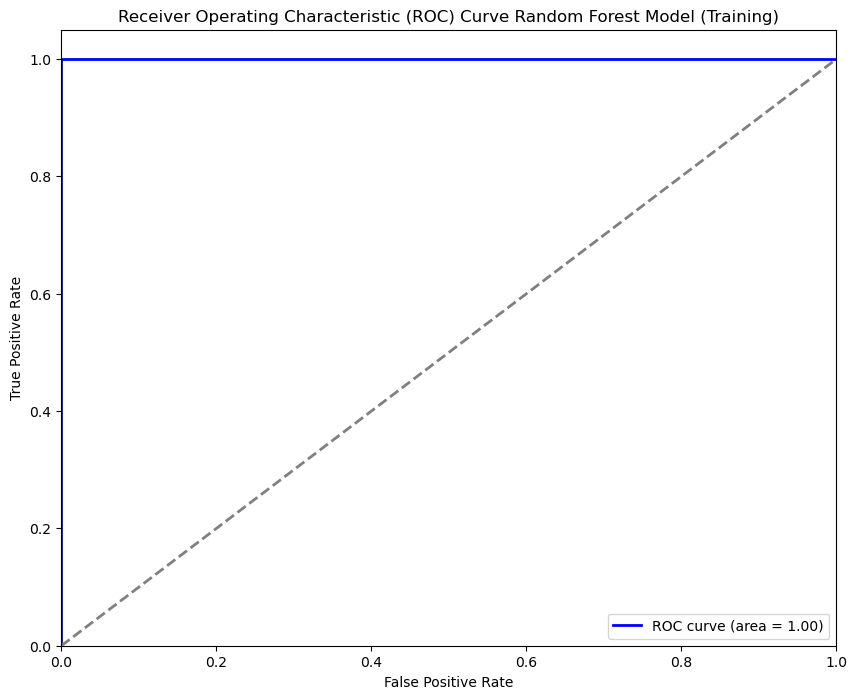

In [138]:
# Plot ROC curve on training dataset
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc_train:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve Random Forest Model (Training)')
plt.legend(loc="lower right")
plt.show()

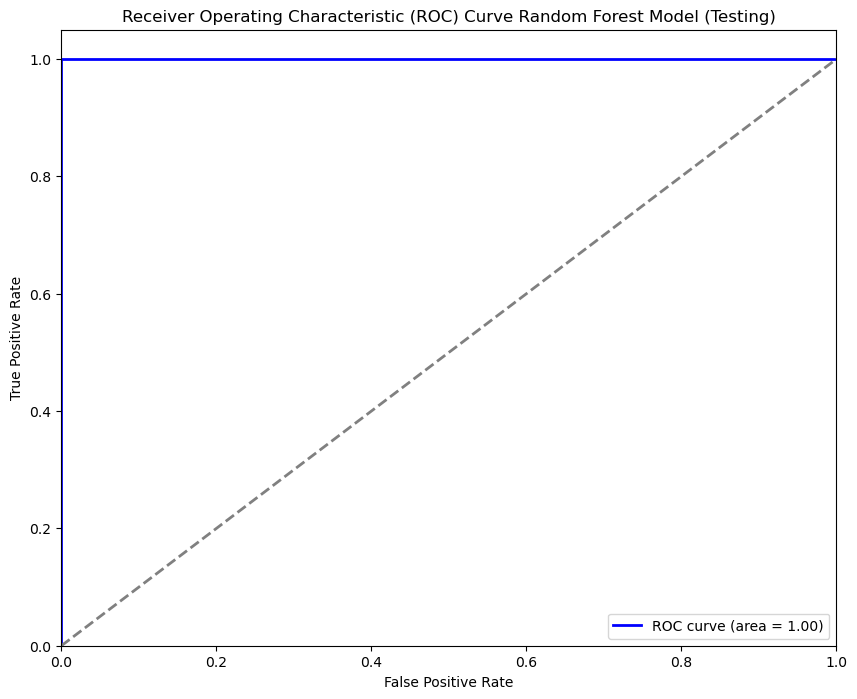

In [139]:
# Plot ROC curve on testing set
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve Random Forest Model (Testing)')
plt.legend(loc="lower right")
plt.show()

---

In [140]:
# predictions on Validation set
rfc_predict = pd.Series(rfc.predict(X_val),index=test.index)
rfc_predict

DATE
2019-02-25 00:00:00           yes
2019-02-25 00:00:00           yes
2019-02-25 00:00:00    Manual off
2019-02-25 00:00:00    Manual off
2019-02-25 00:00:00           yes
                          ...    
2021-05-25 09:19:49           yes
2021-05-25 09:19:51           yes
2021-05-25 09:19:51    Manual off
2021-05-25 09:19:54           yes
2021-05-25 09:24:34           yes
Length: 1143020, dtype: object

In [141]:
rfc_predict.unique()

array(['yes', 'Manual off'], dtype=object)

In [142]:
test['WellFailure'] = rfc_predict
test = test.reset_index()
test

DATE           WELL_ID  CURRENT  PRESS_DESC  PRESS_INT  \
0       2019-02-25 00:00:00  DEEPWATER-0RCI25    59.14     4112.53       0.00   
1       2019-02-25 00:00:00  DEEPWATER-3OKFRE    23.03     3675.48     253.34   
2       2019-02-25 00:00:00  DEEPWATER-4ISLB0    41.21     4009.70     529.51   
3       2019-02-25 00:00:00  DEEPWATER-4OBKXS    44.64        0.00       0.00   
4       2019-02-25 00:00:00  DEEPWATER-BJE55K     9.37     3717.13     322.43   
...                     ...               ...      ...         ...        ...   
1143015 2021-05-25 09:19:49  DEEPWATER-0RCI25    59.00     4255.00     228.00   
1143016 2021-05-25 09:19:51  DEEPWATER-4ISLB0    58.00        0.00       0.00   
1143017 2021-05-25 09:19:51  DEEPWATER-UOOXPH    67.00     4236.00     244.00   
1143018 2021-05-25 09:19:54  DEEPWATER-GBQGBP    26.00     4096.00     573.00   
1143019 2021-05-25 09:24:34  DEEPWATER-GBQGBP    26.00     4098.00     574.00   

         TEMP_INT  TEMP_MOT  VIBRATION WellFailure  
0          226.20    274.98       0.00         yes  
1          236.45    267.97       0.24         yes  
2          223.68    261.97       0.22  Manual off  
3            0.00      0.00       0.00  Manual off  
4          231.69     32.00       0.00         yes  
...           ...       ...        ...         ...  
1143015    229.00    280.00       0.00         yes  
1143016     32.00     32.00       0.00         yes  
1143017    228.00    301.00       1.00  Manual off  
1143018    248.00    295.00       1.00         yes  
1143019    248.00    295.00       1.00         yes  

[1143020 rows x 9 columns]

In [143]:
# # Iterate over unique values in 'WELL_ID'
# for well_id in test['WELL_ID'].unique():
#     df = test[test['WELL_ID'] == well_id]
#     x_test_well = df.drop(columns=['WELL_ID'])  # Drop non-feature columns

#     # Make predictions
#     y_pred = rfc.predict(x_test_well)
#     y_pred_proba = rfc.predict_proba(x_test_well)[:, 1]

In [144]:
result = []
for i in test["WELL_ID"].unique():
    df = test[test['WELL_ID']==i][['WELL_ID','DATE','WellFailure']].reset_index().drop('index',axis=1)
    result.append(df.sample(1))

result = np.vstack(result)
result = pd.DataFrame(result,columns=['WELL_ID','DATE','WellFailure'])
result

WELL_ID                DATE WellFailure
0   DEEPWATER-0RCI25 2020-03-05 21:20:00         yes
1   DEEPWATER-3OKFRE 2021-01-03 07:59:25         yes
2   DEEPWATER-4ISLB0 2020-07-01 22:11:29         yes
3   DEEPWATER-4OBKXS 2020-06-14 11:39:07         yes
4   DEEPWATER-BJE55K 2020-12-07 17:42:23  Manual off
5   DEEPWATER-F022ZE 2020-01-16 12:40:00         yes
6   DEEPWATER-GBQGBP 2020-06-18 03:39:03         yes
7   DEEPWATER-HFLRME 2020-02-01 14:00:00         yes
8   DEEPWATER-K0RPBL 2020-03-25 09:20:00         yes
9   DEEPWATER-RAPG5L 2020-10-19 23:01:05         yes
10  DEEPWATER-S5VD4I 2020-08-23 17:59:02         yes
11  DEEPWATER-UOOXPH 2020-09-29 01:26:04         yes
12  DEEPWATER-WJW1K1 2020-06-08 07:14:42         yes
13  DEEPWATER-YDSE0D 2020-01-30 16:40:00  Manual off
14  DEEPWATER-CY3WQW 2020-12-23 20:50:00         yes

---

## 7.2. Explainable Boosting Classifier

In [145]:
ebc = ExplainableBoostingClassifier(random_state=42, interactions=0)
ebc.fit(X_train, y_train)

ExplainableBoostingClassifier(interactions=0)

In [146]:
# Predictions on testing set
y_pred_ebc = pd.Series(ebc.predict(X_test),index=X_test.index)
y_pred_ebc

DATE
2020-03-02 00:00:00           yes
2019-07-13 00:00:00    Manual off
2019-07-13 00:00:00           yes
2019-09-15 00:00:00           yes
2019-10-15 00:00:00    Manual off
2019-07-13 00:00:00    Manual off
2021-02-16 00:18:49           yes
2020-11-20 00:00:34    Manual off
2019-03-11 00:00:00           yes
2019-10-04 00:00:00    Manual off
2019-07-13 00:00:00    Manual off
2019-09-09 00:00:00    Manual off
2021-01-11 00:18:58    Manual off
2021-01-11 00:18:58    Manual off
2019-10-15 00:00:00    Manual off
2020-02-08 00:00:00    Manual off
2020-09-25 00:19:02    Manual off
2020-01-05 00:05:31    Manual off
2021-05-13 00:15:15           yes
2020-02-20 00:25:38    Manual off
2019-12-04 00:00:00    Manual off
2019-07-08 00:00:00           yes
2021-03-21 00:00:58    Manual off
2019-07-13 00:00:00    Manual off
2020-01-23 00:11:11           yes
2020-06-01 00:19:47           yes
2019-06-06 00:00:00    Manual off
2020-04-17 11:13:36    Manual off
2019-12-08 00:00:00    Manual off
2019-03-1

In [147]:
# Make predictions on the testing dataset
y_pred_proba_ebc = ebc.predict_proba(X_test)[:, 1]
y_pred_proba_ebc

array([0.91715404, 0.13717187, 0.99721394, 0.78692657, 0.32608314,
       0.13717187, 0.97482135, 0.15944185, 0.63673494, 0.03299298,
       0.13717187, 0.35472443, 0.14701681, 0.14701681, 0.32608314,
       0.06509775, 0.18378445, 0.13832647, 0.92321178, 0.24030172,
       0.41183161, 0.86525882, 0.22138351, 0.13717187, 0.85941849,
       0.92508187, 0.05203036, 0.4903678 , 0.11205597, 0.63673494,
       0.92362541, 0.18342866, 0.80973435, 0.10651857, 0.96237842,
       0.8557328 , 0.24030172, 0.98424346, 0.97630801, 0.97477153,
       0.80973435, 0.10651857, 0.98424346, 0.03299298])

In [148]:
# Performance
accuracy_ebc = accuracy_score(y_test, y_pred_ebc)
roc_auc_ebc = roc_auc_score(y_test, y_pred_proba_ebc)

In [149]:
print(f"Accuracy: {accuracy_ebc:.2f}")
print(f"ROC-AUC: {roc_auc_ebc:.2f}")

Accuracy: 0.98
ROC-AUC: 0.96


In [150]:
# Evaluating performance
ebc_cv_score = cross_val_score(ebc, X_train, y_train, cv=10, scoring='roc_auc')
ebc_cv_score

array([1.        , 0.97959184, 0.80952381, 0.95238095, 0.88095238,
       0.9047619 , 0.88095238, 0.80952381, 0.85714286, 0.92857143])

In [151]:
# Calculate ROC curve on testing data
fpr, tpr, thresholds = roc_curve(y_encoded_test, y_pred_proba_ebc)
roc_auc_ebc = auc(fpr, tpr)

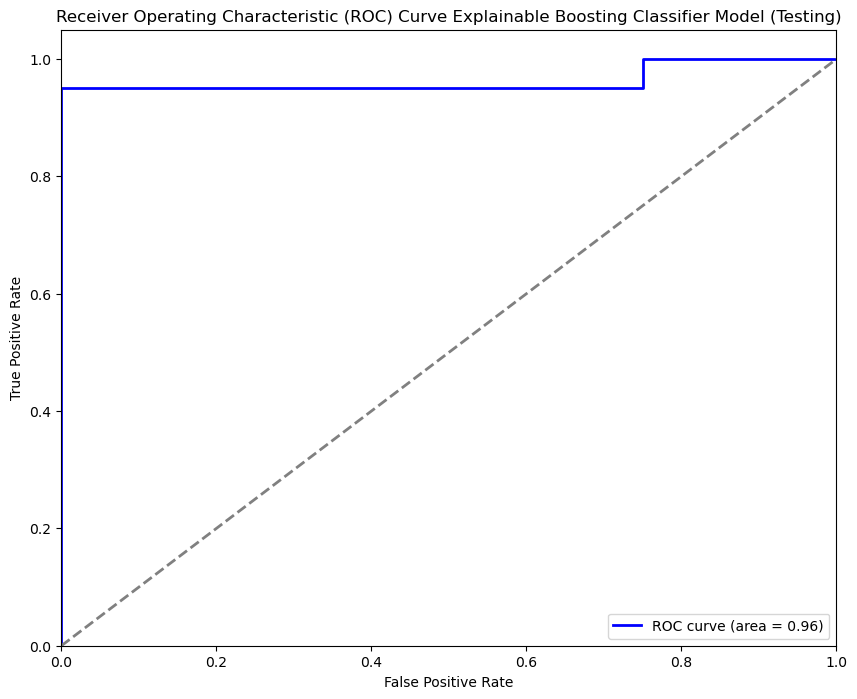

In [152]:
# Plot ROC curve on test dataset
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc_ebc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve Explainable Boosting Classifier Model (Testing)')
plt.legend(loc="lower right")
plt.show()

---

In [153]:
# predictions on Validation set
ebc_predict = pd.Series(ebc.predict(X_val),index=test.index)
ebc_predict

0                 yes
1                 yes
2                 yes
3          Manual off
4                 yes
              ...    
1143015           yes
1143016           yes
1143017           yes
1143018           yes
1143019           yes
Length: 1143020, dtype: object

In [154]:
test['WellFailure'] = ebc_predict
test = test.reset_index()
test

index                DATE           WELL_ID  CURRENT  PRESS_DESC  \
0              0 2019-02-25 00:00:00  DEEPWATER-0RCI25    59.14     4112.53   
1              1 2019-02-25 00:00:00  DEEPWATER-3OKFRE    23.03     3675.48   
2              2 2019-02-25 00:00:00  DEEPWATER-4ISLB0    41.21     4009.70   
3              3 2019-02-25 00:00:00  DEEPWATER-4OBKXS    44.64        0.00   
4              4 2019-02-25 00:00:00  DEEPWATER-BJE55K     9.37     3717.13   
...          ...                 ...               ...      ...         ...   
1143015  1143015 2021-05-25 09:19:49  DEEPWATER-0RCI25    59.00     4255.00   
1143016  1143016 2021-05-25 09:19:51  DEEPWATER-4ISLB0    58.00        0.00   
1143017  1143017 2021-05-25 09:19:51  DEEPWATER-UOOXPH    67.00     4236.00   
1143018  1143018 2021-05-25 09:19:54  DEEPWATER-GBQGBP    26.00     4096.00   
1143019  1143019 2021-05-25 09:24:34  DEEPWATER-GBQGBP    26.00     4098.00   

         PRESS_INT  TEMP_INT  TEMP_MOT  VIBRATION WellFailure  
0             0.00    226.20    274.98       0.00         yes  
1           253.34    236.45    267.97       0.24         yes  
2           529.51    223.68    261.97       0.22         yes  
3             0.00      0.00      0.00       0.00  Manual off  
4           322.43    231.69     32.00       0.00         yes  
...            ...       ...       ...        ...         ...  
1143015     228.00    229.00    280.00       0.00         yes  
1143016       0.00     32.00     32.00       0.00         yes  
1143017     244.00    228.00    301.00       1.00         yes  
1143018     573.00    248.00    295.00       1.00         yes  
1143019     574.00    248.00    295.00       1.00         yes  

[1143020 rows x 10 columns]

In [155]:
result = []
for i in test["WELL_ID"].unique():
    df = test[test['WELL_ID']==i][['WELL_ID','DATE','WellFailure']].reset_index().drop('index',axis=1)
    result.append(df.sample(1))

result = np.vstack(result)
result = pd.DataFrame(result,columns=['WELL_ID','DATE','WellFailure'])
result

WELL_ID                DATE WellFailure
0   DEEPWATER-0RCI25 2020-09-18 17:22:32         yes
1   DEEPWATER-3OKFRE 2020-11-03 09:27:47         yes
2   DEEPWATER-4ISLB0 2020-10-12 02:19:02  Manual off
3   DEEPWATER-4OBKXS 2020-02-22 20:00:00  Manual off
4   DEEPWATER-BJE55K 2020-10-27 20:09:03         yes
5   DEEPWATER-F022ZE 2020-01-10 15:14:00         yes
6   DEEPWATER-GBQGBP 2020-05-22 10:41:30         yes
7   DEEPWATER-HFLRME 2020-01-29 19:20:00         yes
8   DEEPWATER-K0RPBL 2020-02-05 07:20:00         yes
9   DEEPWATER-RAPG5L 2020-10-18 20:22:05         yes
10  DEEPWATER-S5VD4I 2020-05-29 17:20:00         yes
11  DEEPWATER-UOOXPH 2021-01-19 07:21:20         yes
12  DEEPWATER-WJW1K1 2020-07-14 12:53:33         yes
13  DEEPWATER-YDSE0D 2019-07-25 00:00:00         yes
14  DEEPWATER-CY3WQW 2020-01-30 11:35:30         yes

---

## 7.3. XGBoost

In [156]:
# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_train)

In [157]:
xb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xb.fit(X_train, y_encoded)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [158]:
# Predictions
y_pred_xb = pd.Series(xb.predict(X_test),index=X_test.index)
y_pred_xb

DATE
2020-03-02 00:00:00    1
2019-07-13 00:00:00    0
2019-07-13 00:00:00    1
2019-09-15 00:00:00    1
2019-10-15 00:00:00    0
2019-07-13 00:00:00    0
2021-02-16 00:18:49    1
2020-11-20 00:00:34    0
2019-03-11 00:00:00    1
2019-10-04 00:00:00    0
2019-07-13 00:00:00    0
2019-09-09 00:00:00    0
2021-01-11 00:18:58    0
2021-01-11 00:18:58    0
2019-10-15 00:00:00    0
2020-02-08 00:00:00    0
2020-09-25 00:19:02    0
2020-01-05 00:05:31    0
2021-05-13 00:15:15    1
2020-02-20 00:25:38    0
2019-12-04 00:00:00    0
2019-07-08 00:00:00    1
2021-03-21 00:00:58    0
2019-07-13 00:00:00    0
2020-01-23 00:11:11    1
2020-06-01 00:19:47    1
2019-06-06 00:00:00    0
2020-04-17 11:13:36    0
2019-12-08 00:00:00    0
2019-03-11 00:00:00    1
2020-06-03 00:19:25    1
2021-04-09 08:19:52    0
2020-06-10 00:19:00    1
2020-03-04 00:00:00    0
2019-08-16 00:00:00    1
2020-11-22 00:18:56    1
2020-02-20 00:25:38    0
2020-03-25 00:00:00    1
2021-05-10 00:19:43    1
2019-03-05 00:00:00 

In [159]:
# Make predictions on the testing data
y_pred_proba_xb = xb.predict_proba(X_test)[:, 1]
y_pred_proba_xb

array([0.988837  , 0.02394552, 0.9951185 , 0.92152065, 0.1650478 ,
       0.02394552, 0.9317078 , 0.03466702, 0.839672  , 0.00773311,
       0.02394552, 0.05994607, 0.01518193, 0.01518193, 0.1650478 ,
       0.08563779, 0.09021422, 0.04474652, 0.9641364 , 0.06366865,
       0.10274842, 0.98851484, 0.02251823, 0.02394552, 0.96217805,
       0.98861796, 0.01884387, 0.27611536, 0.04538793, 0.839672  ,
       0.96776164, 0.09233848, 0.9720195 , 0.04264088, 0.97956777,
       0.7738574 , 0.06366865, 0.8426525 , 0.9932794 , 0.9846506 ,
       0.9720195 , 0.04264088, 0.8426525 , 0.00773311], dtype=float32)

In [160]:
# Performance
accuracy_xb = accuracy_score(y_encoded_test, y_pred_xb)
roc_auc_xb = roc_auc_score(y_test, y_pred_proba_xb)

In [161]:
print(f"Accuracy: {accuracy_xb:.2f}")
print(f"ROC-AUC: {roc_auc_xb:.2f}")

Accuracy: 0.98
ROC-AUC: 0.98


In [162]:
# Evaluating performance
xb_cv_score = cross_val_score(xb, X_train, y_encoded, cv=10, scoring='roc_auc')
xb_cv_score

array([1.        , 1.        , 0.85714286, 0.97619048, 1.        ,
       0.97619048, 0.95238095, 0.88095238, 1.        , 1.        ])

In [163]:
# Calculate ROC curve testing data
fpr, tpr, thresholds = roc_curve(y_encoded_test, y_pred_proba_xb)
roc_auc_xb = auc(fpr, tpr)

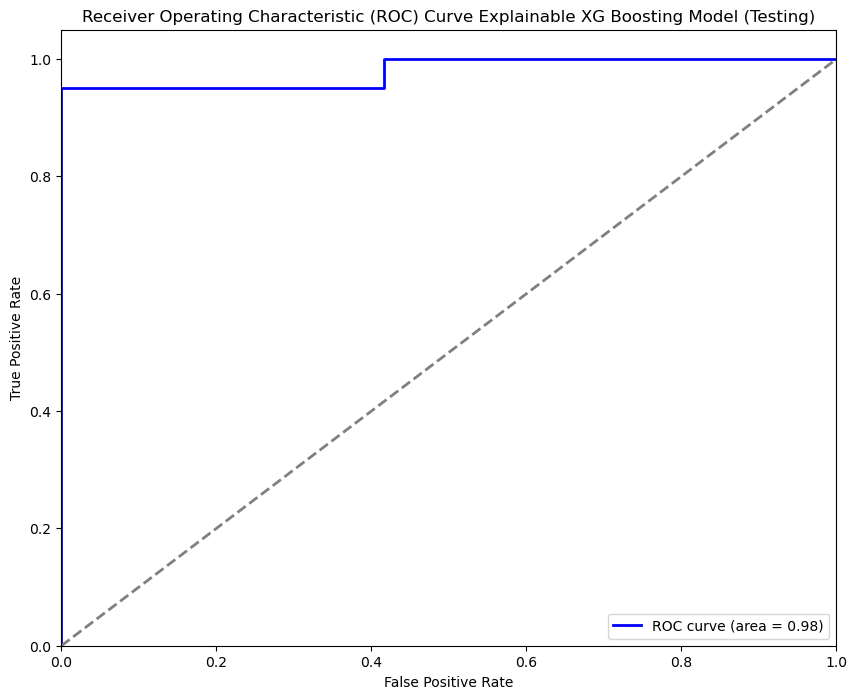

In [164]:
# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc_xb:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve Explainable XG Boosting Model (Testing)')
plt.legend(loc="lower right")
plt.show()

---

In [165]:
# predictions on Validation set
xb_predict = pd.Series(xb.predict(X_val),index=test.index)
xb_predict

0          1
1          1
2          1
3          1
4          1
          ..
1143015    1
1143016    1
1143017    0
1143018    1
1143019    1
Length: 1143020, dtype: int32

In [166]:
test['WellFailure'] = xb_predict
test = test.reset_index()
test

level_0    index                DATE           WELL_ID  CURRENT  \
0              0        0 2019-02-25 00:00:00  DEEPWATER-0RCI25    59.14   
1              1        1 2019-02-25 00:00:00  DEEPWATER-3OKFRE    23.03   
2              2        2 2019-02-25 00:00:00  DEEPWATER-4ISLB0    41.21   
3              3        3 2019-02-25 00:00:00  DEEPWATER-4OBKXS    44.64   
4              4        4 2019-02-25 00:00:00  DEEPWATER-BJE55K     9.37   
...          ...      ...                 ...               ...      ...   
1143015  1143015  1143015 2021-05-25 09:19:49  DEEPWATER-0RCI25    59.00   
1143016  1143016  1143016 2021-05-25 09:19:51  DEEPWATER-4ISLB0    58.00   
1143017  1143017  1143017 2021-05-25 09:19:51  DEEPWATER-UOOXPH    67.00   
1143018  1143018  1143018 2021-05-25 09:19:54  DEEPWATER-GBQGBP    26.00   
1143019  1143019  1143019 2021-05-25 09:24:34  DEEPWATER-GBQGBP    26.00   

         PRESS_DESC  PRESS_INT  TEMP_INT  TEMP_MOT  VIBRATION  WellFailure  
0           4112.53       0.00    226.20    274.98       0.00            1  
1           3675.48     253.34    236.45    267.97       0.24            1  
2           4009.70     529.51    223.68    261.97       0.22            1  
3              0.00       0.00      0.00      0.00       0.00            1  
4           3717.13     322.43    231.69     32.00       0.00            1  
...             ...        ...       ...       ...        ...          ...  
1143015     4255.00     228.00    229.00    280.00       0.00            1  
1143016        0.00       0.00     32.00     32.00       0.00            1  
1143017     4236.00     244.00    228.00    301.00       1.00            0  
1143018     4096.00     573.00    248.00    295.00       1.00            1  
1143019     4098.00     574.00    248.00    295.00       1.00            1  

[1143020 rows x 11 columns]

In [167]:
result = []
for i in test["WELL_ID"].unique():
    df = test[test['WELL_ID']==i][['WELL_ID','DATE','WellFailure']].reset_index().drop('index',axis=1)
    result.append(df.sample(1))

result = np.vstack(result)
result = pd.DataFrame(result,columns=['WELL_ID','DATE','WellFailure'])
result

WELL_ID                DATE WellFailure
0   DEEPWATER-0RCI25 2020-09-16 08:58:01           1
1   DEEPWATER-3OKFRE 2020-12-13 05:54:30           1
2   DEEPWATER-4ISLB0 2020-02-24 09:20:00           1
3   DEEPWATER-4OBKXS 2020-10-10 21:19:04           1
4   DEEPWATER-BJE55K 2020-06-01 16:59:08           1
5   DEEPWATER-F022ZE 2020-01-17 08:17:00           1
6   DEEPWATER-GBQGBP 2020-08-04 14:09:03           1
7   DEEPWATER-HFLRME 2020-01-19 15:40:00           1
8   DEEPWATER-K0RPBL 2020-04-03 18:20:00           1
9   DEEPWATER-RAPG5L 2020-10-27 06:06:46           1
10  DEEPWATER-S5VD4I 2021-01-01 15:03:08           1
11  DEEPWATER-UOOXPH 2020-07-09 22:27:59           1
12  DEEPWATER-WJW1K1 2020-08-13 08:10:36           1
13  DEEPWATER-YDSE0D 2020-03-07 23:20:00           1
14  DEEPWATER-CY3WQW 2020-10-06 06:47:42           1

# **End of the Project**

---